In [26]:
import pandas as pd
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
from collections import namedtuple
from datetime import datetime, timedelta
import numpy as np
import warnings;
warnings.filterwarnings('ignore');
import seaborn as sns
import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly.offline as offline  
%matplotlib inline
import re
import time
import operator

# Introduction
The aim of our project is to try to help people become more aware of what they consume.  In order to do this, the first thing we have to do is to inform ourselves about the current situation of consumption in Europe.
Once we know the current situation, we are more prepared to realize our goal: to discover hidden information in how we eat. This information can be discovered by making an analysis of the correlation between different foods.
These results can contribute to make people more aware of what they eat, and therefore, have more tools to take care of their food.

In this notebook, we will focus in analyzing several consumption trends in Europe, for example, to check if the population eats healthy or not, and if it follows the medical recommendations, for example the famous food pyramid.
We feel like it is important to do an analysis of how and what the population consumes before delivering a tool to help people eat healthier. 

# Structure of the notebook 

- A) Analysis of dataset "EFSA Comprehensive European Food Consumption Database"
- B) Analysis of dataset "Recipe1M+"
- Conclusions

# A) Analysis of dataset "EFSA Comprehensive European Food Consumption Database"

**Table of content:**

- 1) Dataset Analysis: Check how the data is structured.
- 2) Plot in time of the consumption of Alcohol in Spain
- 3) Plot in time of the consumption of Alcohol for chunks
- 4) Plot in time the healthy and unhealthy products consumption in Spain
- 5) Compare the recommended food pyramid with the real consumption in Spain and UK


## 1) Dataset Analysis: Check how the data is structured.

As the dataset is structured in surveys, we want to do a Gantt chart to visualize when and where the surveys took place, before conducting further analysis of the data

In [27]:
df = pd.read_csv("ESFA/survey_details/survey.csv", encoding="utf_16_le")

In [28]:
df.head()

Country DESC  Start Year ID  \
0      Austria         2005.0   
1      Austria         2010.0   
2      Austria         2010.0   
3      Belgium         2002.0   
4      Belgium         2004.0   

                                         Survey DESC                CODE  \
0       Austrian Study on Nutritional Status 2005-06                ASNS   
1  Austrian Study on Nutritional Status 2010-12 -...       ASNS - ADULTS   
2  Austrian Study on Nutritional Status 2010-12 -...     ASNS - CHILDREN   
3                                  Regional Flanders   REGIONAL FLANDERS   
4                                 Diet National 2004  DIET NATIONAL 2004   

                               Reference publication  Consecutive replicates  \
0  Elmadfa I, Freisling H, Nowak V and Hofstädter...                     NaN   
1  Elmadfa I et al. Österreichischer Ernährungsbe...                    10.0   
2  Elmadfa I et al. Österreichischer Ernährungsbe...                     NaN   
3  Huybrechts I, Matthys C, Pynaert I, De Maeyer ...                     NaN   
4  De Vriese S, Huybrecht I, Moreau M, De Henauw ...                     NaN   

   Replicates  Interview meetings  Response rate (%)  Min age range (years)  \
0           1                 NaN               48.0                   19.0   
1           2                 1.0               65.0                   18.0   
2           3                 1.0               50.0                    6.0   
3           3                 NaN                NaN                    2.5   
4           2                 NaN               41.0                   15.0   

   ...      Survey period  Age range (year)  Survey Comment Survey start  \
0  ...  5-06-01 / 6-06-01           19 - 65             NaN     6/1/2005   
1  ...  0-08-15 / 2-02-15           18 - 80             NaN    8/15/2010   
2  ...  0-08-15 / 2-02-15            6 - 15             NaN    8/15/2010   
3  ...  2-01-01 / 2-12-31         2.5 - 6.5             NaN     1/1/2002   
4  ...  4-01-01 / 4-12-31             15 -              NaN     1/1/2004   

   Survey end                                    Sampling method  Sample unit  \
0    6/1/2006  Random from telephone book, Job centres, gynae...  Individuals   
1   2/15/2012  Quota, Austrian standard population from Censu...  Individuals   
2   2/15/2012  Quota, Austrian standard population from Censu...  Individuals   
3  12/31/2002                                                NaN          NaN   
4  12/31/2004       Random from the national population register  Individuals   

  Over sampled      Dietary software  Method under-reporters  
0          NaN                   NaN                     NaN  
1          NaN  Nutritional software  Schofield cut off 0.81  
2          NaN  Nutritional software            Cut off 0.76  
3          NaN                   NaN                     NaN  
4          NaN                   NaN                     NaN  

[5 rows x 23 columns]

We will use the library `plotly` in order to plot the Gantt chart. We therefore select the necessary columns and we assign the right names, as requested by the library:

In [29]:
df_gantt = (
    df[["Country DESC", "Survey DESC", "Survey start", "Survey end"]]
    .rename(columns={
        "Country DESC":"Task",
        "Survey DESC":"Survey",
        "Survey start":"Start",
        "Survey end":"Finish"})
)
df_gantt.head()

Task                                             Survey      Start  \
0  Austria       Austrian Study on Nutritional Status 2005-06   6/1/2005   
1  Austria  Austrian Study on Nutritional Status 2010-12 -...  8/15/2010   
2  Austria  Austrian Study on Nutritional Status 2010-12 -...  8/15/2010   
3  Belgium                                  Regional Flanders   1/1/2002   
4  Belgium                                 Diet National 2004   1/1/2004   

       Finish  
0    6/1/2006  
1   2/15/2012  
2   2/15/2012  
3  12/31/2002  
4  12/31/2004

We fill in missing values:

In [30]:
df_gantt["Finish"][32] = "2/1/2014"
df_gantt["Start"][45] = "01/01/2014"
df_gantt["Finish"][45] = "01/01/2014"

We transform dates into python dates:

In [31]:
from dateutil import parser

df_gantt["Start"] = df_gantt["Start"].map(lambda x : parser.parse(x))
df_gantt["Finish"] = df_gantt["Finish"].map(lambda x : parser.parse(x))

We filter out nations for which we only have one survey (or multiple surveys done the same year):

In [32]:
df_gantt = (
    df_gantt
    .drop_duplicates()
    .groupby("Task")
    .filter(lambda x : len(x) > 1)
    .reset_index(drop=True)
)

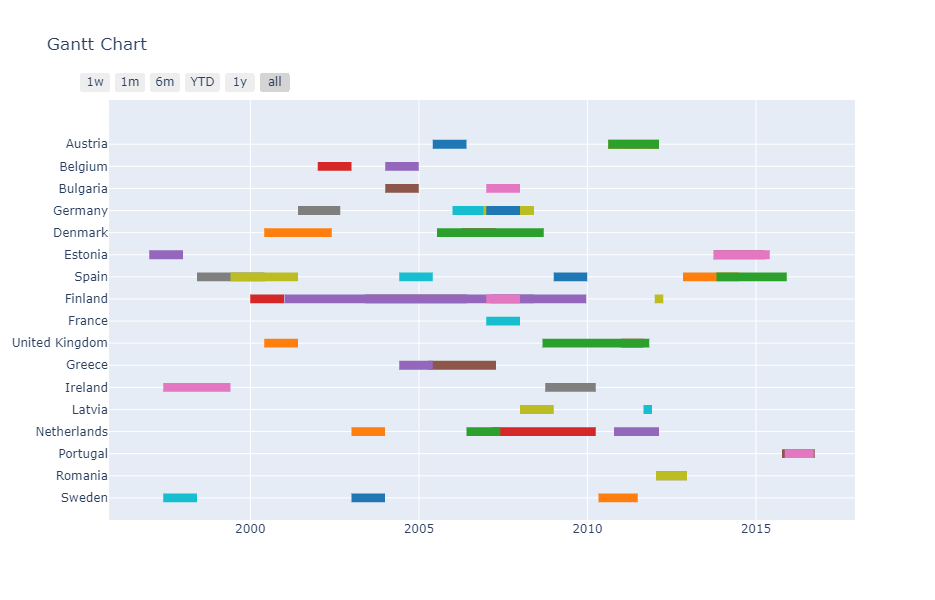

In [33]:
fig = ff.create_gantt(df_gantt, group_tasks=True, showgrid_x=True, showgrid_y=True)
offline.plot(fig, filename="gant1.html")
fig.show()

We notice that we don't have all these surveys in the Chronic Food consumption dataset downloaded by the visualization tool (eg the Estonia 1997 survey is missing), therefore we will use the full dataset.

We can't compare all nations in the dataset, as many nations only have one survey or they don't have surveys spanning over an enough large time chunk. So we restrict the analysis to nations for which we can compare behaviours between distant points in time.

Most promising nations are:
- Estonia
- Spain
- Finland
- UK
- Ireland
- Netherlands
- Sweden

Let's plot a Gantt with only these:

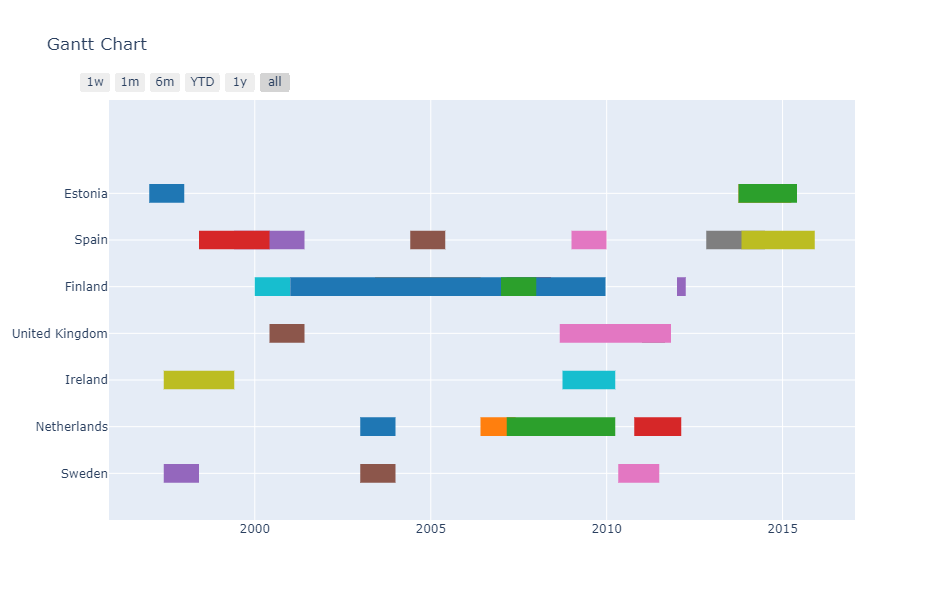

In [34]:
df_gantt_best = (
    df_gantt[df_gantt["Task"].isin(["Estonia","Spain","Finland","United Kingdom","Ireland","Netherlands","Sweden"])]
    .reset_index(drop=True)
)
fig = ff.create_gantt(df_gantt_best, group_tasks=True, showgrid_x=True, showgrid_y=True)
fig.show()

We remove Finland long survey as it can't be associated to a precise chunk of years

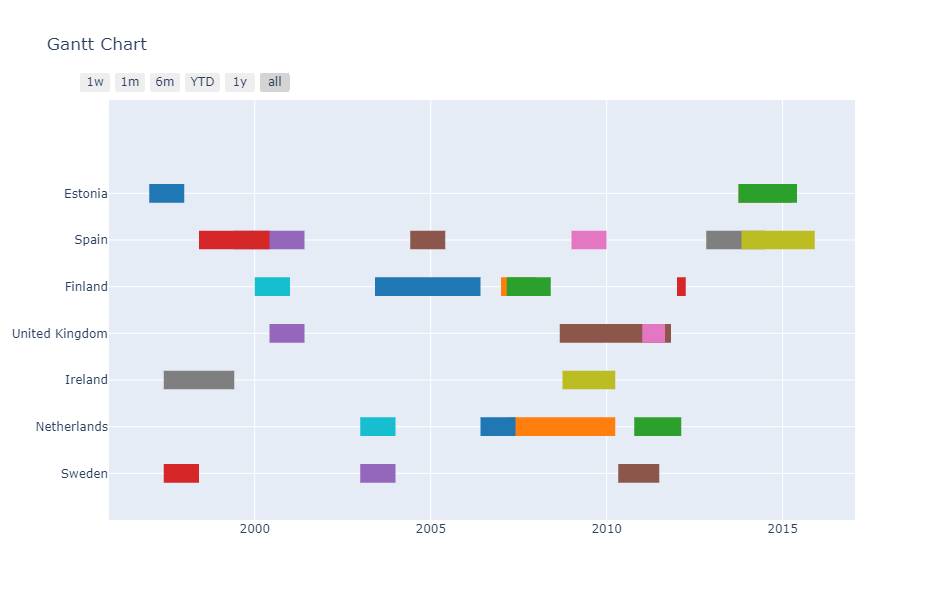

In [35]:
df_gantt_best = (
    df_gantt_best[
        ~(
            (df_gantt_best["Start"] == parser.parse("2001-01-04")) &
            (df_gantt_best["Finish"] == parser.parse("2009-12-19"))
        )]
    .reset_index(drop=True)
)

fig = ff.create_gantt(df_gantt_best, group_tasks=True, showgrid_x=True, showgrid_y=True)
offline.plot(fig, filename="gant2.html")
fig.show()

At this point, we try dividing surveys in chunks, in order to be able to make comparisons on the average over all the nations selected.

We define the following chunks:

- 1997 - 2001
- 2003 - 2007
- 2008 - 2012
- 2012 - 2015

In [36]:
df_surveys = (
    df_gantt_best
    .copy()
    .rename(columns = {
        "Task":"Country",
        "Finish":"End"
    })
)

df_surveys.head()

Country                                             Survey      Start  \
0  Estonia                       National Dietary Survey 1997 1997-01-01   
1  Estonia  National Dietary Survey among 11-74 years old ... 2013-10-01   
2  Estonia  National Dietary Survey among children up to t... 2013-10-01   
3    Spain  Food patterns of Spanish schoolchildren and ad... 1998-06-01   
4    Spain      Spanish Agency for Food Safety (AESAN) Survey 1999-06-01   

         End  
0 1997-12-31  
1 2015-04-01  
2 2015-06-01  
3 2000-06-01  
4 2001-06-01

In [37]:
DateRange = namedtuple("DateRange", ["start","end"])

def get_date_range(start, end):
    return DateRange(start=datetime(start,1,1), end=datetime(end,12,31))

def assign_chunk(row):
    #print("Start: {}, type: {}".format(row["Start"], type(row["Start"])))
    #print("End: {}".format(row["Start"]))
    survey_range = DateRange(start=row["Start"].to_pydatetime(), end=row["End"].to_pydatetime())
    best_chunk = 0
    max_overlap = timedelta()
    for chunk in chunks:
        max_start = max(chunk.start, survey_range.start)
        min_end = min(chunk.end, survey_range.end)
        overlap = (min_end - max_start)
        if overlap > max_overlap:
            max_overlap = overlap
            best_chunk = str(chunk.start.year) + "-" + str(chunk.end.year)
    return best_chunk

In [38]:
chunks = [
    get_date_range(1997, 2001),
    get_date_range(2003, 2007),
    get_date_range(2008, 2011),
    get_date_range(2012, 2015)
]

df_surveys["chunk"] = df_surveys.apply(assign_chunk, axis=1)
df_surveys.sort_values("Start", inplace=True)
df_surveys.head(9)

Country                                             Survey  \
0          Estonia                       National Dietary Survey 1997   
23          Sweden  Swedish National Dietary Survey - RIKSMATEN 19...   
17         Ireland        North/South Ireland Food Consumption Survey   
3            Spain  Food patterns of Spanish schoolchildren and ad...   
4            Spain      Spanish Agency for Food Safety (AESAN) Survey   
9          Finland  Special Turku Coronary Risk Factor Interventio...   
14  United Kingdom                 National Diet and Nutrition Survey   
19     Netherlands                 Dutch National Dietary Survey 2003   
24          Sweden                       National Food Administration   

        Start        End      chunk  
0  1997-01-01 1997-12-31  1997-2001  
23 1997-06-01 1998-06-01  1997-2001  
17 1997-06-01 1999-06-01  1997-2001  
3  1998-06-01 2000-06-01  1997-2001  
4  1999-06-01 2001-06-01  1997-2001  
9  2000-01-01 2000-12-31  1997-2001  
14 2000-06-01 2001-06-01  1997-2001  
19 2003-01-01 2003-12-31  2003-2007  
24 2003-01-01 2003-12-31  2003-2007

We save dataframe to file as later we will use this data for further analysis

In [39]:
df_surveys.to_csv(r"ESFA/surveys_chunks.csv")

Our results with designated chunks are not very meaningful (we miss data), let's try with just two chunks:

In [40]:
chunks = [
    get_date_range(1997, 2006),
    get_date_range(2007, 2015)
]

df_surveys["chunk"] = df_surveys.apply(assign_chunk, axis=1)
df_surveys.sort_values("Start", inplace=True)

We save the chunks, as the results are more meaningful

In [41]:
df_surveys.to_csv(r"ESFA/surveys_chunks_2.csv")

In [42]:
df = pd.read_csv("ESFA/dataset.csv", sep='\t', encoding = "unicode_escape", low_memory=False)

We proceed to do a change of columns name to make it more clear

In [43]:
col_ren = {"SurveyscountryDESC" : "survey_country",
           "SurveystartyearID" : "survey_start_year",
           "SurveyDESC": "survey_desc",
           "SurveyID": "Survey_ID",
           "PopulationGroupL2DESC": "pop_group",
           "ExposurehierarchyL1DESC": "food_type_L1",
           "ExposurehierarchyL2DESC": "food_type_L2",
           "ExposurehierarchyL3DESC": "food_type_L3",
           "ExposurehierarchyL4DESC": "food_type_L4",
           "ExposurehierarchyL7DESC" : "food_type_L7",
           "count_subject_s_pg": "pop_count",
           "count_subject_wg": "cons_count",
           "avg_chronic_bw": "mean_weight",
           "avg_chronic": "avg_chronic",
           "count_days_wg": "count_days_wg",
           "count_days_s_pg":"count_days_s_pg",
           "STD_CH_BW": "std_weight",
           "median_chronic_bw": "med_weight"}

df_sel = df[list(col_ren.keys())].rename(columns=col_ren)
df_sel["survey_start_year"] = df_sel["survey_start_year"].fillna(0).astype(int)

The fields that are more relevant are:
- <strong>survey_country: </strong> Country where the survey was conducted.
- <strong>survey_desc: </strong>Name of the survey.
- <strong>pop_group: </strong>Type of population group, per e.g. Adults or Adolescents.
- <strong>food_type_X : </strong>The different types of food, being X the level of specificity of the grouping.
- <strong>mean_weight: </strong>Is the mean of the grams of product consumed per day and per Kg of body weight of the people polled.
- <strong>avg_chronic: </strong>Is the mean of the grams of product consumed per day of the people polled.

Once we know the how the dataset is organized we will obtain some information about consumption trends.
In most of the cases we will use Spain, because as it can be seen it is the country that has the highest number of surveys, therefore more meaningful data.

---
## 2) Plot in time of the consumption of Alcohol in Spain
We are going to do a bottom-up aproach. First we are going to start with the consumption of a specific category and then broaden the analysis.
We start the analysis of an unhealthy food, in this case a beverage, starting with a single country, Spain.

<br />

In [44]:
df_spain = df_sel[df_sel["survey_country"] == "Spain"]
df_spain.head(4)

survey_country  survey_start_year  \
59137          Spain               1998   
59138          Spain               1998   
59139          Spain               1998   
59140          Spain               1998   

                                             survey_desc  Survey_ID pop_group  \
59137  Food patterns of Spanish schoolchildren and ad...         34  Toddlers   
59138  Food patterns of Spanish schoolchildren and ad...         34  Toddlers   
59139  Food patterns of Spanish schoolchildren and ad...         34  Toddlers   
59140  Food patterns of Spanish schoolchildren and ad...         34  Toddlers   

                                            food_type_L1  \
59137  Animal and vegetable fats and oils and primary...   
59138  Animal and vegetable fats and oils and primary...   
59139  Animal and vegetable fats and oils and primary...   
59140  Animal and vegetable fats and oils and primary...   

                         food_type_L2                     food_type_L3  \
59137  Animal and vegetable fats/oils  Vegetable fats and oils, edible   
59138  Animal and vegetable fats/oils  Vegetable fats and oils, edible   
59139  Animal and vegetable fats/oils  Vegetable fats and oils, edible   
59140  Fat emulsions and blended fats                           Butter   

      food_type_L4                       food_type_L7  pop_count  cons_count  \
59137   Olive oils                         Olive oils         17          10   
59138   Olive oils  Olive oil, virgin or extra-virgin         17           3   
59139    Seed oils         Sunflower seed oil, edible         17           4   
59140       Butter                             Butter         17           2   

       mean_weight  avg_chronic  count_days_wg  count_days_s_pg  std_weight  \
59137     0.729913    10.250000             16               34    0.625989   
59138     0.257095     4.166667              3               34    0.183944   
59139     0.572327     8.750000              6               34    0.170323   
59140     0.173478     2.500000              2               34    0.012734   

       med_weight  
59137    0.511739  
59138    0.166667  
59139    0.637175  
59140    0.173478

We get the mean weight of product consumed per day per body weight relative to the population count for each record.

$\large \sum_{food\_type, year} \frac{mean\_weight \cdot cons\_count}{pop\_count}$

In [45]:
df_spain_alcohol = df_spain[df_spain["food_type_L1"] == "Alcoholic beverages"].copy()
df_spain_alcohol["weight"] = df_spain_alcohol["mean_weight"] * df_spain_alcohol["cons_count"]
df_spain_alcohol["w_weight"] = df_spain_alcohol["weight"] / df_spain_alcohol["pop_count"]
df_spain_alcohol.head()

survey_country  survey_start_year  \
59244          Spain               1998   
59474          Spain               1998   
59475          Spain               1998   
59748          Spain               1999   
59749          Spain               1999   

                                             survey_desc  Survey_ID  \
59244  Food patterns of Spanish schoolchildren and ad...         34   
59474  Food patterns of Spanish schoolchildren and ad...         34   
59475  Food patterns of Spanish schoolchildren and ad...         34   
59748      Spanish Agency for Food Safety (AESAN) Survey          9   
59749      Spanish Agency for Food Safety (AESAN) Survey          9   

            pop_group         food_type_L1                 food_type_L2  \
59244  Other children  Alcoholic beverages    Wine and wine-like drinks   
59474     Adolescents  Alcoholic beverages    Wine and wine-like drinks   
59475     Adolescents  Alcoholic beverages    Wine and wine-like drinks   
59748          Adults  Alcoholic beverages  Beer and beer-like beverage   
59749          Adults  Alcoholic beverages  Beer and beer-like beverage   

      food_type_L3 food_type_L4        food_type_L7  pop_count  cons_count  \
59244         Wine  Wine, white         Wine, white        156           2   
59474         Wine    Wine, red           Wine, red        209           1   
59475         Wine  Wine, white         Wine, white        209           1   
59748         Beer         Beer                Beer        418         101   
59749         Beer   Lager beer  Beer, alcohol-free        418          18   

       mean_weight  avg_chronic  count_days_wg  count_days_s_pg  std_weight  \
59244     0.302507     7.500000              2              312    0.217361   
59474     0.140449     5.000000              1              418    0.000000   
59475     0.096154     5.000000              1              418    0.000000   
59748     4.448947   330.836634            140              828    4.423882   
59749     2.119616   156.111111             22              828    1.442176   

       med_weight      weight  w_weight  
59244    0.302507    0.605014  0.003878  
59474    0.140449    0.140449  0.000672  
59475    0.096154    0.096154  0.000460  
59748    2.774275  449.343657  1.074985  
59749    2.020105   38.153092  0.091275

Then we group over the survey start year and population group, averaging the calculated relative weight, as the consumers count doesn't necessarily sum up to the population count for each survey (it is probably higher)

In [46]:
df_spain_alcohol_g = (
    df_spain_alcohol
    [["survey_start_year","pop_group","w_weight"]]
    .groupby(["survey_start_year","pop_group"])
    .mean()
    .rename(columns={"w_weight":"w_weight_sum"})
)
df_spain_alcohol_g

w_weight_sum
survey_start_year pop_group                   
1998              Adolescents         0.000720
                  Other children      0.003878
1999              Adults              0.137104
2004              Adolescents         0.018895
                  Other children      0.001566
2009              Adolescents         0.056776
                  Adults              0.093409
2013              Adults              0.080136
                  Elderly             0.121321

Now that we have the grams/day/kg of each group we are going to plot them to analyze the trend. We use the same range on the x-axis for better comparison.

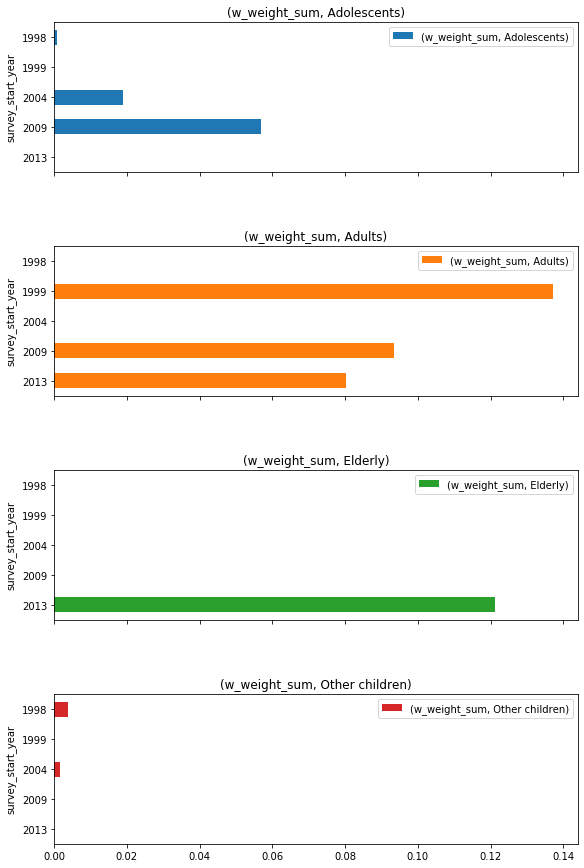

In [47]:
fig, axes = plt.subplots(4,1, figsize=(8,12))
fig.tight_layout()
plt.subplots_adjust(hspace=0.5)

ax = df_spain_alcohol_g.unstack(level=1).plot(kind='barh', subplots=True, ax=axes[0], sharex=True)
for x in ax:
    x.invert_yaxis()

We can see, that the consumption of alcohol in adolescents has increased, at the same time that it has decreased in smaller childrens (Other children). Consumption in adults is also decreasing. Let's see if this results differ a lot when taking more countries into account.

---
## 3) Plot in time of the consumption of Alcohol for chunks

Now that we have analyzed the data in Spain, we will try to analyze it for Europe:

<br />

In [48]:
df_surveys_chunks = df = pd.read_csv(r"ESFA/surveys_chunks.csv", index_col=0)
df_surveys_chunks.head(4)

Country                                             Survey       Start  \
0   Estonia                       National Dietary Survey 1997  1997-01-01   
23   Sweden  Swedish National Dietary Survey - RIKSMATEN 19...  1997-06-01   
17  Ireland        North/South Ireland Food Consumption Survey  1997-06-01   
3     Spain  Food patterns of Spanish schoolchildren and ad...  1998-06-01   

           End      chunk  
0   1997-12-31  1997-2001  
23  1998-06-01  1997-2001  
17  1999-06-01  1997-2001  
3   2000-06-01  1997-2001

In [49]:
df_alcohol = df_sel[df_sel["food_type_L1"] == "Alcoholic beverages"].copy()

In [50]:
df_alcohol_best = df_alcohol.merge(df_surveys_chunks[["Survey","chunk"]], left_on="survey_desc", right_on="Survey", how="inner")
df_alcohol_best.head(4)

survey_country  survey_start_year                   survey_desc  Survey_ID  \
0        Estonia               1997  National Dietary Survey 1997          8   
1        Estonia               1997  National Dietary Survey 1997          8   
2        Estonia               1997  National Dietary Survey 1997          8   
3        Estonia               1997  National Dietary Survey 1997          8   

  pop_group         food_type_L1                 food_type_L2  \
0    Adults  Alcoholic beverages  Beer and beer-like beverage   
1    Adults  Alcoholic beverages  Beer and beer-like beverage   
2    Adults  Alcoholic beverages  Beer and beer-like beverage   
3    Adults  Alcoholic beverages       Mixed alcoholic drinks   

          food_type_L3         food_type_L4         food_type_L7  pop_count  \
0                 Beer           Lager beer        Beer, regular       1866   
1                 Beer           Lager beer          Beer, light       1866   
2  Beer-like beverages  Beer-like beverages  Beer-like beverages       1866   
3       Cocktail drink       Cocktail drink       Cocktail drink       1866   

   cons_count  mean_weight  avg_chronic  count_days_wg  count_days_s_pg  \
0         206    13.698508  1074.029126            206             1866   
1           1     4.714286   330.000000              1             1866   
2          11     2.922928   211.390909             11             1866   
3           3     4.251926   293.333333              3             1866   

   std_weight  med_weight                        Survey      chunk  
0   11.860726    9.090909  National Dietary Survey 1997  1997-2001  
1    0.000000    4.714286  National Dietary Survey 1997  1997-2001  
2    1.856794    2.037662  National Dietary Survey 1997  1997-2001  
3    2.051787    4.925373  National Dietary Survey 1997  1997-2001

In [51]:
df_alcohol_best["survey_country"].unique()

array(['Estonia', 'Finland', 'Ireland', 'Netherlands', 'Spain', 'Sweden',
       'United Kingdom'], dtype=object)

These are the countries that we are going to take into account in the following analysis.

In [52]:
df_alcohol_best["weight"] = df_alcohol_best["mean_weight"] * df_alcohol_best["cons_count"]
df_alcohol_best["w_weight"] = df_alcohol_best["weight"] / df_alcohol_best["pop_count"]

In [53]:
df_alcohol_best_g = (
    df_alcohol_best
    [["chunk","pop_group","w_weight"]]
    .groupby(["chunk","pop_group"])
    .mean()
    .rename(columns={"w_weight":"w_weight_sum"})
)

In [54]:
df_alcohol_best_g.unstack(level=1)

w_weight_sum                                                \
pop_group  Adolescents    Adults   Elderly   Infants Lactating women   
chunk                                                                  
1997-2001     0.000720  0.239507       NaN       NaN             NaN   
2003-2007     0.020160  0.178679  0.065416       NaN             NaN   
2008-2011     0.036902  0.178586  0.177561  0.002326             NaN   
2012-2015     0.112673  0.110722  0.096741       NaN        0.021641   

                                                 
pop_group Other children  Toddlers Very elderly  
chunk                                            
1997-2001       0.029166       NaN          NaN  
2003-2007       0.013372  0.000949          NaN  
2008-2011       0.001442  0.003912     0.120733  
2012-2015       0.041546  0.016259          NaN

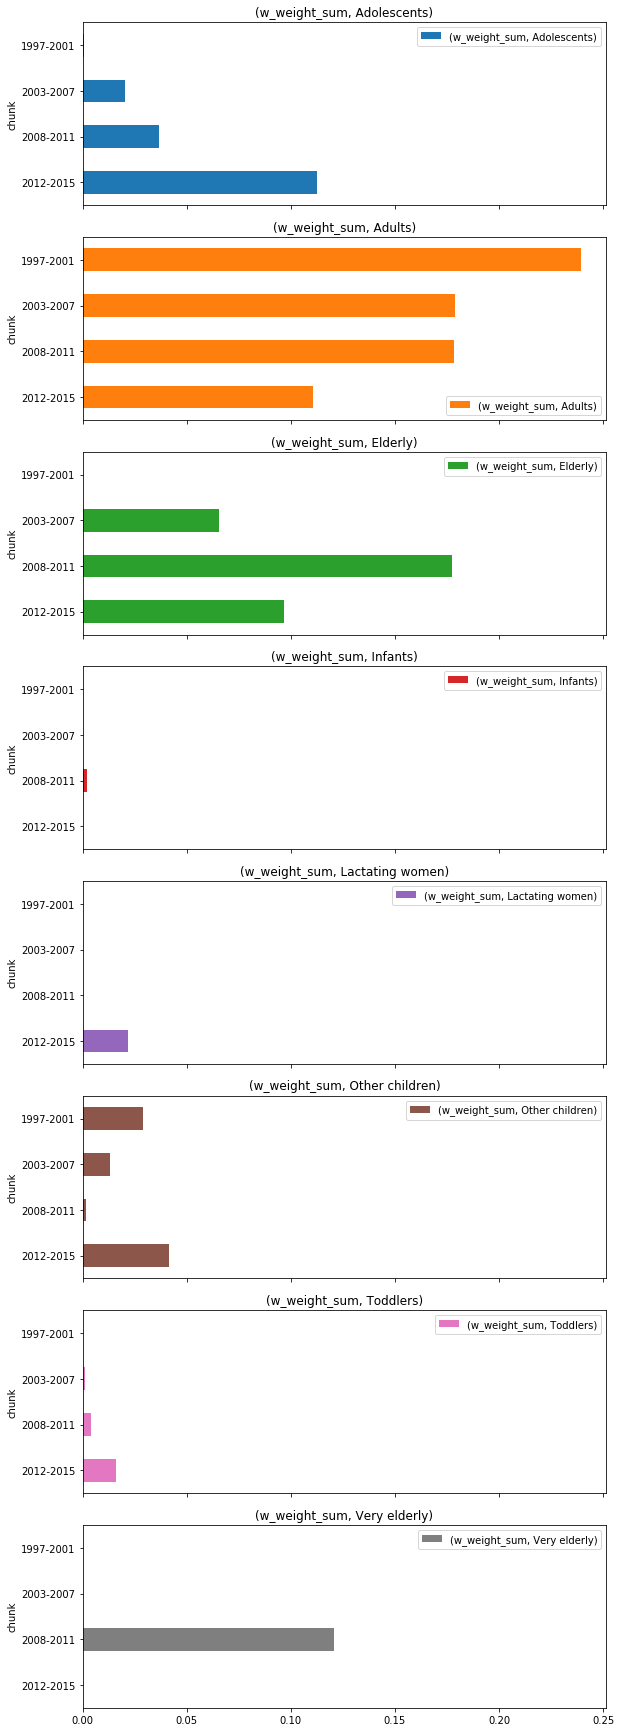

In [55]:
fig, axes = plt.subplots(8,1, figsize=(8,24))
fig.tight_layout()

ax = df_alcohol_best_g.unstack(level=1).plot(kind='barh', subplots=True, ax=axes[0], sharex=True)
for x in ax:
    x.invert_yaxis()

As can be seen, the results are quite striking. The difference between the chunks (and therefore periods of time) is too large. This is probably due to some chunks not having surveys at all.

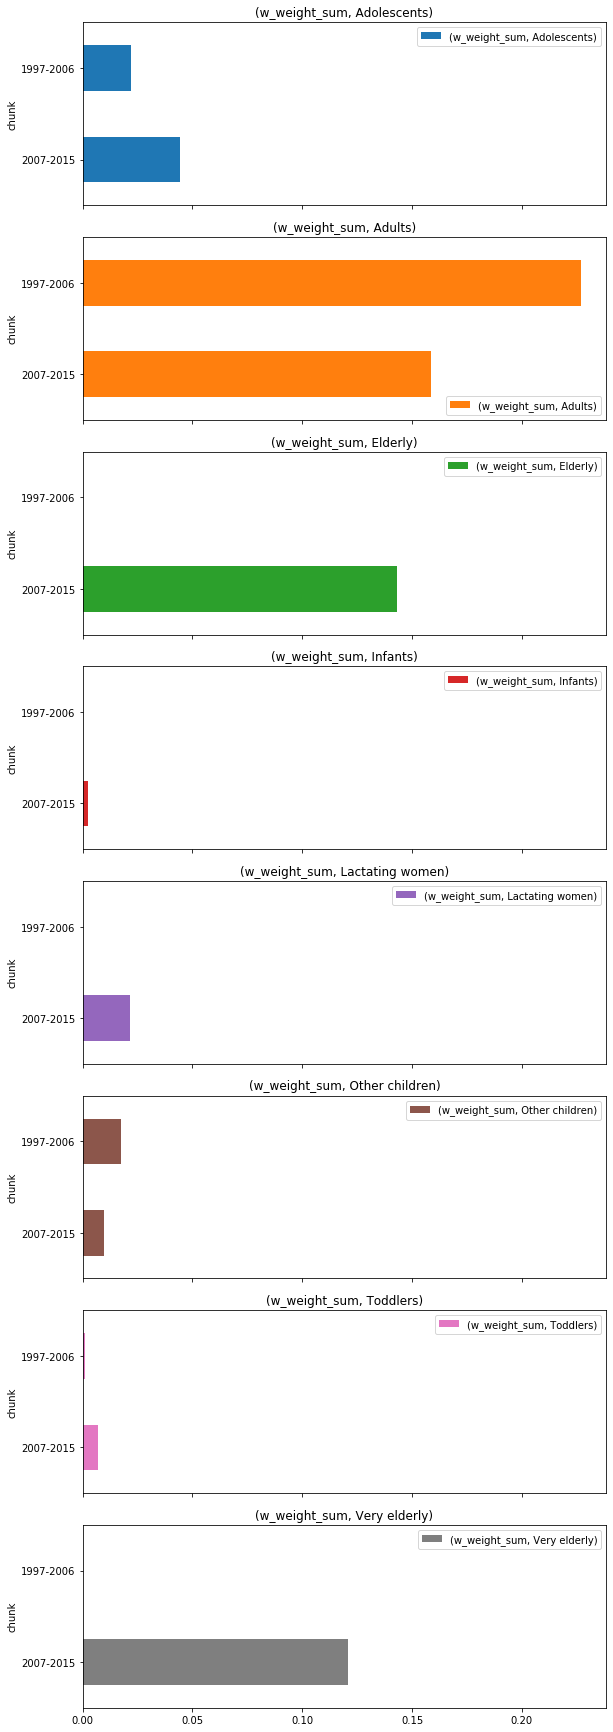

In [56]:
df_surveys_chunks = df = pd.read_csv(r"ESFA/surveys_chunks_2.csv", index_col=0)
df_alcohol = df_sel[df_sel["food_type_L1"] == "Alcoholic beverages"].copy()

df_alcohol_best = df_alcohol.merge(df_surveys_chunks[["Survey","chunk"]], left_on="survey_desc", right_on="Survey", how="inner")
df_alcohol_best["weight"] = df_alcohol_best["mean_weight"] * df_alcohol_best["cons_count"]
df_alcohol_best["w_weight"] = df_alcohol_best["weight"] / df_alcohol_best["pop_count"]

df_alcohol_best_g = (
    df_alcohol_best
    [["chunk","pop_group","w_weight"]]
    .groupby(["chunk","pop_group"])
    .mean()
    .rename(columns={"w_weight":"w_weight_sum"})
)

fig, axes = plt.subplots(8,1, figsize=(8,24))
fig.tight_layout()
#plt.subplots_adjust(hspace=0.5)


ax = df_alcohol_best_g.unstack(level=1).plot(kind='barh', subplots=True, ax=axes[0], sharex=True)
for x in ax:
    x.invert_yaxis()

We see we probably don't have data for Elderly, Very Elderly, Infants and Lactating Women in the first chunk.

We can guess some trends with such data, but we do not have enough data to carry out a detail analysis over all the population groups.

---
## 4) Plot in time the healthy and unhealthy products consumption in Spain

As alcoholic is only one type of unhealthy food, we will try to get two clear groups of healthy and unhealthy food to analyze its consumption:

<br />

In [57]:
#We obtain the names of the different surveys done in Spain
aux = df_sel[df_sel["survey_country"]=="Spain"]
aux[["survey_desc","Survey_ID","survey_start_year"]].drop_duplicates()

survey_desc  Survey_ID  \
59137  Food patterns of Spanish schoolchildren and ad...         34   
59748      Spanish Agency for Food Safety (AESAN) Survey          9   
60171                         Encuesta de nutrición 2005         35   
60797  Spanish Agency for Food Safety (AESAN) - FIAB ...         10   
61479  Spanish National dietary survey on children an...         59   
62881  Spanish National dietary survey in adults, eld...         62   

       survey_start_year  
59137               1998  
59748               1999  
60171               2004  
60797               2009  
61479               2012  
62881               2013

We create two arrays containing some healthy and unhealthy food.

In [58]:
healthyFood = ["Legumes","Fruit used as fruit","Vegetables and vegetable products","Hot drinks and similar (coffee, cocoa, tea and herbal infusions)","Leafy vegetables","Fruit and fruit products"]
unhealthyFood = ["Preserved/processed fat tissues","Artificial sweeteners (e.g., aspartam, saccharine)","Confectionery including chocolate","Spoonable desserts and ice creams (generic)"]


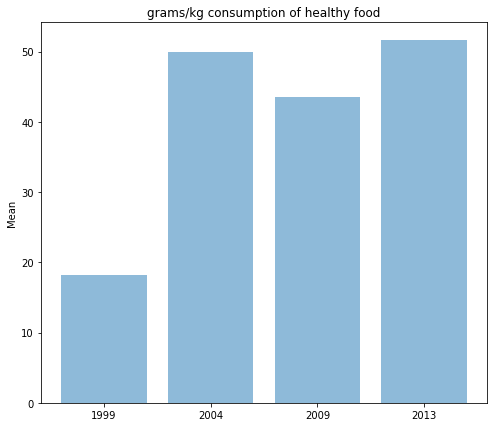

In [59]:
healthy1999= df_sel[(df_sel["food_type_L2"].isin(healthyFood)) & (df_sel["survey_country"]=="Spain")& (df_sel["Survey_ID"]==9)]
df_sel["healthy1999"] = healthy1999["mean_weight"]*healthy1999["cons_count"]/healthy1999["pop_count"]

healthy2004= df_sel[(df_sel["food_type_L2"].isin(healthyFood)) & (df_sel["survey_country"]=="Spain")& (df_sel["Survey_ID"]==35)]
df_sel["healthy2004"] = healthy2004["mean_weight"]*healthy2004["cons_count"]/healthy2004["pop_count"]

healthy2009= df_sel[(df_sel["food_type_L2"].isin(healthyFood)) & (df_sel["survey_country"]=="Spain")& (df_sel["Survey_ID"]==10)]
df_sel["healthy2009"] = healthy2009["mean_weight"]*healthy2009["cons_count"]/healthy2009["pop_count"]

healthy2013= df_sel[(df_sel["food_type_L2"].isin(healthyFood)) & (df_sel["survey_country"]=="Spain")& (df_sel["Survey_ID"]==62)]
df_sel["healthy2013"] = healthy2013["mean_weight"]*healthy2013["cons_count"]/healthy2013["pop_count"]

fig, ax = plt.subplots(figsize=(8, 7))
years = ["1999","2004","2009","2013"]
consumption = [df_sel["healthy1999"].sum(),df_sel["healthy2004"].sum(),df_sel["healthy2009"].sum(),df_sel["healthy2013"].sum()]
ax.bar(years,consumption , align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Mean')

ax.set_title('grams/kg consumption of healthy food')
plt.show(fig)

As we can see, in general the spanish population is increasingly eating healthier. Or at least, more of the aliments that we have considered healthy.

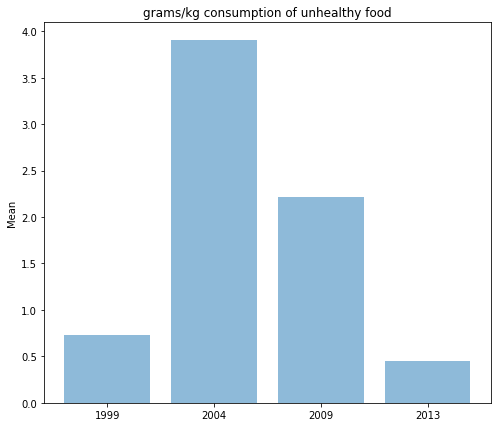

In [60]:
unhealthy1999= df_sel[(df_sel["food_type_L2"].isin(unhealthyFood)) & (df_sel["survey_country"]=="Spain")& (df_sel["Survey_ID"]==9)]
df_sel["unhealthy1999"] = unhealthy1999["mean_weight"]*unhealthy1999["cons_count"]/unhealthy1999["pop_count"]

unhealthy2004= df_sel[(df_sel["food_type_L2"].isin(unhealthyFood)) & (df_sel["survey_country"]=="Spain")& (df_sel["Survey_ID"]==35)]
df_sel["unhealthy2004"] = unhealthy2004["mean_weight"]*unhealthy2004["cons_count"]/unhealthy2004["pop_count"]

unhealthy2009= df_sel[(df_sel["food_type_L2"].isin(unhealthyFood)) & (df_sel["survey_country"]=="Spain")& (df_sel["Survey_ID"]==10)]
df_sel["unhealthy2009"] = unhealthy2009["mean_weight"]*unhealthy2009["cons_count"]/unhealthy2009["pop_count"]

unhealthy2013= df_sel[(df_sel["food_type_L2"].isin(unhealthyFood)) & (df_sel["survey_country"]=="Spain")& (df_sel["Survey_ID"]==62)]
df_sel["unhealthy2013"] = unhealthy2013["mean_weight"]*unhealthy2013["cons_count"]/unhealthy2013["pop_count"]

fig, ax = plt.subplots(figsize=(8, 7))
years = ["1999","2004","2009","2013"]
consumption = [df_sel["unhealthy1999"].sum(),df_sel["unhealthy2004"].sum(),df_sel["unhealthy2009"].sum(),df_sel["unhealthy2013"].sum()]
ax.bar(years,consumption , align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Mean')

ax.set_title('grams/kg consumption of unhealthy food')
plt.show(fig)

As can be seen, spanish population is reducing the amount of unhealthy food in general. However, this does not imply that spanish population is eating healthier, just less grams of unhealthy food, but the grams they consume can be more harmful. Therefore as this analysis is interesting but can be deceptive, we are going to use a more standard consumption measure, the food pyramid.

---
## 5) Compare the recommended food pyramid with the real consumption in Spain and UK

We are going to analyze if the spanish population follows the guidelines of food consumption. Specifically we are going to use the last large survey conducted in Spain, which was carried out from 2013 to 2015 and we are going to look at the consumption of the adult spanish population. Later we are also going to analyze the UK to see the differences in food consumption in the EU.
A really visual way of looking at the food consumtion is using the food pyramid, altought is not perfectly correct, is always informative to check for large deviations.
The guidelines of the food pyramid applied to the way our dataset is organized, FoodEx2 can be found in [FoodEx2 guidelines](https://susfans.eu/system/files/public_files/Publications/Reports/SUSFANS%20D2.2_V1.pdf)
The quantities que have choosen are either the Common set if available or the most conservative one between the rest of the options, usually Czech Republic.
The [reference pyramid](https://www.safefood.eu/Healthy-Eating/The-Food-Pyramid-and-The-Eatwell-Guide/The-Food-Pyramid.aspx) that we are going to use comes from a EU member, Ireland, to maintain consistency with the dataset.

<br />

In [61]:
#Let´s create the piramyd:
descriptions = ['Grains and grain-based products', 'Vegetables and vegetable products','Starchy roots or tubers and products thereof, sugar plants', 'Fruit and fruit products', 'Meat and meat products','Fish, seafood, amphibians, reptiles and invertebrates','Milk and dairy products', 'Eggs and egg products','Sugar and similar, confectionery and water-based sweet desserts','Animal and vegetable fats and oils and primary derivatives thereof','Fruit and vegetable juices and nectars (including concentrates)','Water and water-based beverages','Alcoholic beverages', 'Coffee, cocoa, tea and infusions',]
# Quantities at the web page, the values that are 0 will be analyzed later.
quantities = ['180','300','140','200','125','15','300','15','0','20','0','0','0','0']

#Gather the data from the dataset
df_sel['food_type_L7'].replace(' ', np.nan, inplace=True)
df_sel.dropna(subset=['food_type_L7'], inplace=True)
df_selUK = df_sel.copy()
operations= df_sel[(df_sel["survey_country"]=="Spain")& (df_sel["Survey_ID"]==62)].copy()
df_sel["operations"] = operations["avg_chronic"]*operations["cons_count"]/operations["pop_count"]
df_prueba = (
    df_sel[(df_sel["survey_country"]=="Spain")& (df_sel["Survey_ID"]==62)]
    .groupby(["pop_group","food_type_L1"])
    .sum()
)
df_prueba = df_prueba.reset_index()

In [62]:
data = {'food_type_L1':descriptions, 'idealQuantities':quantities} 
dataFrameJoined = pd.DataFrame(data)
df_prueba = df_prueba[df_prueba["pop_group"]== "Adults"]
dataFrameJoined = dataFrameJoined.merge(df_prueba[["food_type_L1","operations"]], left_on="food_type_L1", right_on="food_type_L1", how="inner")
quantitiesInt = list(map(int, quantities))
# We group the different FoodEx2 groups in the ones described in a typical food pyramid
# Vegetables+fruits, grains+starchy, milk related, meat+fish+eggs, fats
descriptionsOrdered = descriptions[1]+" and "+descriptions[3],descriptions[0]+" and "+descriptions[2],descriptions[6],descriptions[4]+", "+descriptions[5]+" and "+descriptions[7],descriptions[9]
quantitiesOrdered = quantitiesInt[1]+quantitiesInt[3],quantitiesInt[0]+quantitiesInt[2],quantitiesInt[6],quantitiesInt[4]+quantitiesInt[5]+quantitiesInt[7],quantitiesInt[9]

indexOperations = dataFrameJoined.columns.get_loc("operations")
listRealConsum = []
listRealConsum.append(dataFrameJoined.iloc[[1,3],indexOperations].sum())
listRealConsum.append(dataFrameJoined.iloc[[0,2],indexOperations].sum())
listRealConsum.append(dataFrameJoined.iloc[[6],indexOperations].sum())
listRealConsum.append(dataFrameJoined.iloc[[4,5,7],indexOperations].sum())
listRealConsum.append(dataFrameJoined.iloc[[9],indexOperations].sum())
data = list(zip(descriptionsOrdered, quantitiesOrdered,listRealConsum))
dataFrameDef = pd.DataFrame(data,columns = ['Descriptions', 'Ideal Consumption','Real Consumption'])



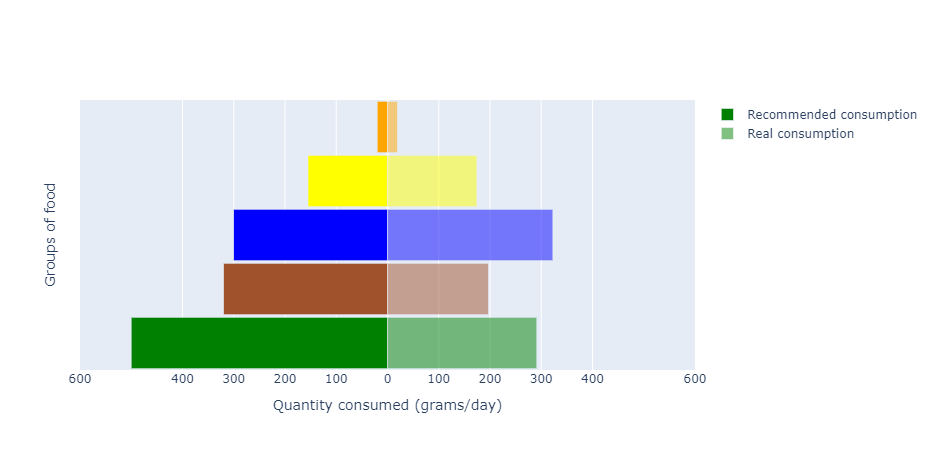

In [63]:
# Let's plot the food pyramid

colors = ['Green','sienna','Blue','Yellow','Orange']
y = dataFrameDef["Descriptions"]
layout = go.Layout(yaxis=go.layout.YAxis(title='Groups of food'),
                   xaxis=go.layout.XAxis(
                       range=[-600, 600],
                       tickvals=[-600 ,-400,-300, -200, -100, 0, 100, 200, 300, 400, 600],
                       ticktext=[600 ,400, 300, 200, 100, 0, 100, 200, 300, 400, 600],
                       title='Quantity consumed (grams/day)'),
                   barmode='overlay',
                   bargap=0.05)

data = [go.Bar(y=y,
               x=-dataFrameDef["Ideal Consumption"],
               orientation='h',
               name='Recommended consumption',
               customdata = dataFrameDef["Descriptions"],
               text = dataFrameDef["Ideal Consumption"],
               hovertemplate = '%{customdata} <br>Recommended: %{text} grams/day <extra></extra>',
               marker_color=colors
               ),
        go.Bar(y=y,
               x=dataFrameDef["Real Consumption"],
               orientation='h',
               hovertext=dataFrameDef["Real Consumption"],
               name='Real consumption',
               customdata = dataFrameDef["Descriptions"],
               text = dataFrameDef["Real Consumption"],
               hovertemplate = '%{customdata} <br>Consumed: %{text:.0f} grams/day<extra></extra>',
               opacity=0.5,
               marker_color=colors
               )]
fig = go.Figure(dict(data=data, layout=layout))
fig.update_yaxes(showticklabels=False)
offline.plot(fig, filename="spainPyramid.html")
fig.show()

As can be seen, the real pyramid is a little bit deviated from the recommended one. For example, the amount of vegetables consumed is almost half of the recommended. Also, the difference in the Grains based products is quite large. However, in general, the real pyramid resembles quite nice the ideal one.

At this point, we also wanted to analyze another country, to double check if our results were consistent, so we decided no analyze a country with well known different food consumption trends, from which we also have enough data, the United Kingdom.

In [64]:
operationsUK= df_selUK[(df_selUK["survey_country"]=="United Kingdom")& (df_selUK["Survey_ID"]==47)]
df_selUK["operationsUK"] = operationsUK["avg_chronic"]*operationsUK["cons_count"]/operationsUK["pop_count"]
df_pruebaUK = (
    df_selUK[(df_selUK["survey_country"]=="United Kingdom")& (df_selUK["Survey_ID"]==47)]
    .groupby(["pop_group","food_type_L1"])
    .sum()
)
df_pruebaUK = df_pruebaUK.reset_index()
data = {'food_type_L1':descriptions, 'idealQuantities':quantities} 
dataFrameJoinedUK = pd.DataFrame(data)
df_pruebaUK = df_pruebaUK[df_pruebaUK["pop_group"]== "Adults"]
dataFrameJoinedUK = dataFrameJoinedUK.merge(df_pruebaUK[["food_type_L1","operationsUK"]], left_on="food_type_L1", right_on="food_type_L1", how="inner")
quantitiesInt = list(map(int, quantities))
# We group the different FoodEx2 groups in the ones described in a typical food pyramid
# Vegetables+fruits, grains+starchy, milk related, meat+fish+eggs, fats
descriptionsOrdered = descriptions[1]+" and "+descriptions[3],descriptions[0]+" and "+descriptions[2],descriptions[6],descriptions[4]+", "+descriptions[5]+" and "+descriptions[7],descriptions[9]
quantitiesOrdered = quantitiesInt[1]+quantitiesInt[3],quantitiesInt[0]+quantitiesInt[2],quantitiesInt[6],quantitiesInt[4]+quantitiesInt[5]+quantitiesInt[7],quantitiesInt[9]

indexoperationsUK = dataFrameJoinedUK.columns.get_loc("operationsUK")
listRealConsumUK = []
listRealConsumUK.append(dataFrameJoinedUK.iloc[[1,3],indexoperationsUK].sum())
listRealConsumUK.append(dataFrameJoinedUK.iloc[[0,2],indexoperationsUK].sum())
listRealConsumUK.append(dataFrameJoinedUK.iloc[[6],indexoperationsUK].sum())
listRealConsumUK.append(dataFrameJoinedUK.iloc[[4,5,7],indexoperationsUK].sum())
listRealConsumUK.append(dataFrameJoinedUK.iloc[[9],indexoperationsUK].sum())
data = list(zip(descriptionsOrdered, quantitiesOrdered,listRealConsumUK))
dataFrameDef = pd.DataFrame(data,columns = ['Descriptions', 'Ideal Consumption','Real Consumption'])

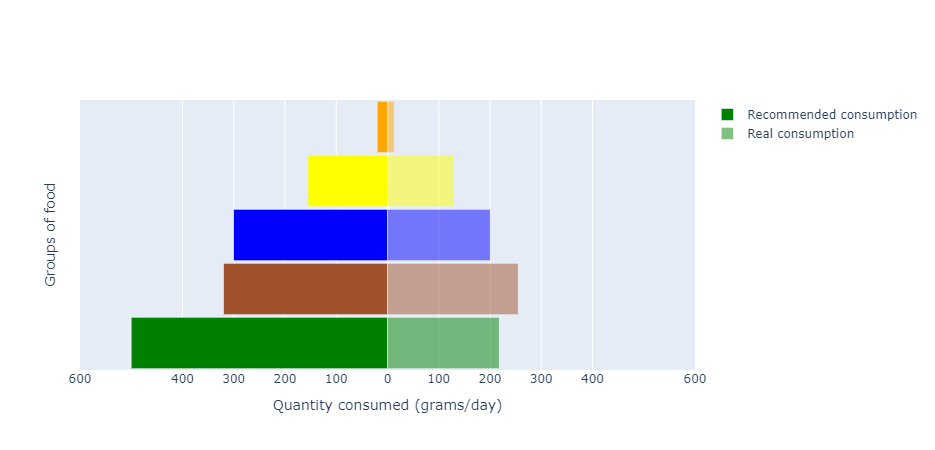

In [65]:
y = dataFrameDef["Descriptions"]
layout = go.Layout(yaxis=go.layout.YAxis(title='Groups of food'),
                   xaxis=go.layout.XAxis(
                       range=[-600, 600],
                       tickvals=[-600 ,-400,-300, -200, -100, 0, 100, 200, 300, 400, 600],
                       ticktext=[600 ,400, 300, 200, 100, 0, 100, 200, 300, 400, 600],
                       title='Quantity consumed (grams/day)'),
                   barmode='overlay',
                   bargap=0.05)

data = [go.Bar(y=y,
               x=-dataFrameDef["Ideal Consumption"],
               orientation='h',
               name='Recommended consumption',
               customdata = dataFrameDef["Descriptions"],
               text = dataFrameDef["Ideal Consumption"],
               hovertemplate = '%{customdata} <br>Recommended: %{text} grams/day <extra></extra>',
               marker_color=colors
               ),
        go.Bar(y=y,
               x=dataFrameDef["Real Consumption"],
               orientation='h',
               hovertext=dataFrameDef["Real Consumption"],
               name='Real consumption',
               customdata = dataFrameDef["Descriptions"],
               text = dataFrameDef["Real Consumption"],
               hovertemplate = '%{customdata} <br>Consumed: %{text:.0f} grams/day<extra></extra>',
               opacity=0.5,
               marker_color=colors
               )]
figUK = go.Figure(dict(data=data, layout=layout))
figUK.update_yaxes(showticklabels=False)
offline.plot(figUK, filename="UKPyramid.html")
figUK.show()

In this case, we can see that the UK population pyramid is more deviated from the ideal one. They eat quite less vegetables and rely more on grains and grain-based products. They also consume less milk related products than Spain and than the ideal amount. Surprisingly, they consume less animal and vegatable fats and oils than Spain, a result we were not expecting

Nonetheless, there are some types of food consumed that don't have a recommended consumption amount, as a result of them being unhealthy or unnecessary. In this group they have a maximum consumption amount. We are going to analyze them for both countries:

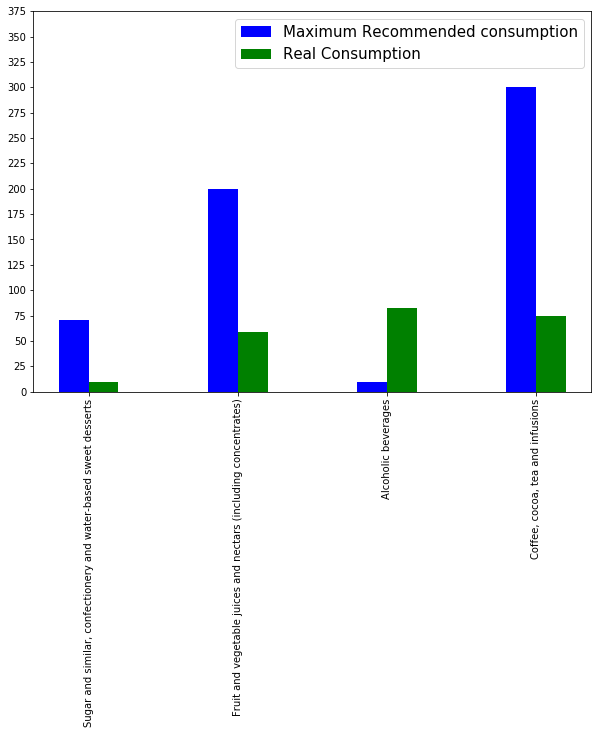

In [66]:
fig, ax = plt.subplots(figsize=(10, 7))
dataFrameMaxConsump = dataFrameJoined.iloc[[8,10,12,13],:]
# Sugar, juices, alcohol, infusions and coffee
maximumConsumption = [71,200,10,300]

dataFrameMaxConsump["Maximum Consumption"] = maximumConsumption
dataFrameMaxConsump = dataFrameMaxConsump.astype({"operations": int})

_keys =  dataFrameMaxConsump["food_type_L1"]
_keys = list(_keys)
_data = dataFrameMaxConsump["Maximum Consumption"]
_data = list(_data)
_data2 = dataFrameMaxConsump["operations"]
_data2 = list(_data2)

ax.bar(np.arange(len(_keys))-0.1, _data, width=0.2, color='b', align='center', label="Maximum Recommended consumption")
ax.bar(np.arange(len(_keys))+0.1, _data2, width=0.2, color='g', align='center', label="Real Consumption")
ax.set_xticks(np.arange(len(_keys)))
ax.set_xticklabels(_keys)
ax.legend(prop={'size': 15})
plt.xticks(rotation=90)
plt.yticks([])
ax.set_yticks(np.arange(0, 400, step=25))
ax.set_yticklabels(np.arange(0, 400, step=25))

plt.show()

In the plot, is very clear that in general the spanish population does not exceed the maximum recommended amount, with one exception, the consumption of the alcoholic beverages

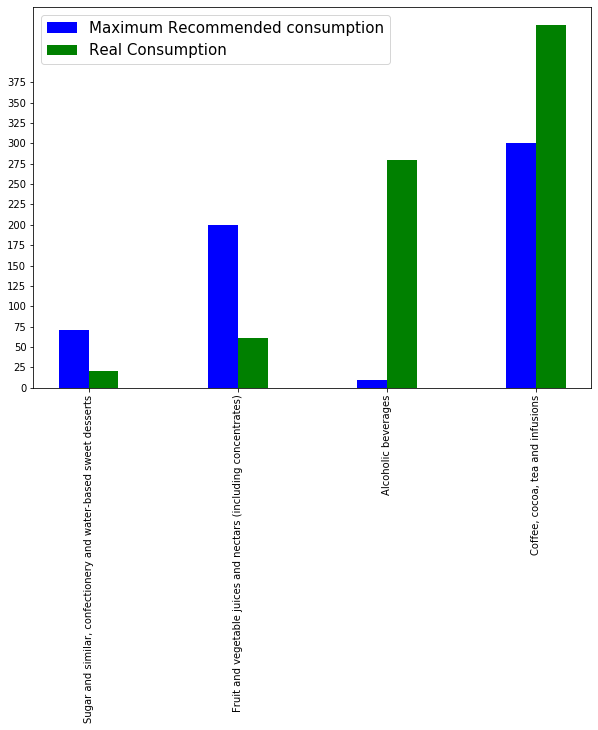

In [65]:
fig, ax = plt.subplots(figsize=(10, 7))
dataFrameMaxConsump = dataFrameJoinedUK.iloc[[8,10,12,13],:]
# Sugar, juices, alcohol, infusions and coffee
maximumConsumption = [71,200,10,300]

dataFrameMaxConsump["Maximum Consumption"] = maximumConsumption
dataFrameMaxConsump = dataFrameMaxConsump.astype({"operationsUK": int})

_keys =  dataFrameMaxConsump["food_type_L1"]
_keys = list(_keys)
_data = dataFrameMaxConsump["Maximum Consumption"]
_data = list(_data)
_data2 = dataFrameMaxConsump["operationsUK"]
_data2 = list(_data2)

ax.bar(np.arange(len(_keys))-0.1, _data, width=0.2, color='b', align='center', label="Maximum Recommended consumption")
ax.bar(np.arange(len(_keys))+0.1, _data2, width=0.2, color='g', align='center', label="Real Consumption")
ax.set_xticks(np.arange(len(_keys)))
ax.set_xticklabels(_keys)
ax.legend(prop={'size': 15})
plt.xticks(rotation=90)
plt.yticks([])
ax.set_yticks(np.arange(0, 400, step=25))
ax.set_yticklabels(np.arange(0, 400, step=25))

plt.show()

As we can see, in the UK the results of the first two groups, sugar related, and fruit juices are similar to Spain. However, when analyzing the alcoholic consumption and the coffee, tea and other infusions consumption the differences are quite remarkable. The alcohol consumption is way higher than the recommended amount, which may be shocking in comparison to the spanish case.
Also, the coffee and tea consumption is much greater, specifically increased by the inusual tea consumption,it seems that after all the cliché that the English drink a lot of tea is true.

As can be seen, there is a lot of consumption of not so healthy things, that should not even be consumed. 

Now that we have finished the analysis of the actual consumption in some EU countries, mostly Spain and also UK, we feel prepared to conduct further investigations to analyze the way we eat, and how it can affect us. We will analyze the different diets and their consequences to try to enlight the people a much as possible with our results, for them to make their decisions based on as much information as possible.

# B) Analysis of dataset "Recipe1M+"

This jupyter notebook corresponds to one part (out of two) of the final report for this milestone. In this notebook we work on the [recpies dataset](http://pic2recipe.csail.mit.edu). Here we will import the dataset, analyze it, search for missing data, clean it, filter it, and start the analysis to ensure that everything is ok for the final milestone. Before starting with all the mentioned tasks, we will present the idea and objectives of this part of the project.

Nowadays, huge advances in medicine and nutrition have led us to understand that the way we eat plays the most important role in our health. Following a diet rich in omega 6, for example, will lead us into different diseases, like cancer. Avoiding bad diets is “easily” achieved by eating a great variety of different food, while minimizing the amount of unhealthy meals. However, things can get harder when we have certain restrictions or obligations in our diet, for instance if we have to counter a lack of iron, or if we are vegan.

In this part of the project, we will use the `Recipe1M+` dataset to find the correlation between ingredients and see which ingredients are more likely to appear together in a recipe. This way, we will investigate how some restriction or obligations in our diets can affect undesired raises in specific aliments. 

These are some of the questions we want to answer in this project:

- What is the presence correlation between ingredients in recipes?
- Are there increases/decreases in the consumption of some ingredients when fighting against a specific disease via nutrition?
- Are there increases/decreases in the consumption of some ingredients when having restrictions in our diet?
- Which recipes are recommended to fight against a specific disease while not resulting in an undesirable increase of some other ingredients?
- Is it easier or harder for people with restrictions in their diets to eat "healthy"?
- Which type of meals (e.g. spicy) are more correlated with unhealthy food?
- More...

In this first approach, we will base our project in 5 specific nutritional situations, expanding it for the third milestone:

- Lactose intolerance
- Gluten intolerance
- Vegan diet
- Countering iron deficiency
- Countering omega 3 deficiency


## Table of contents

**1) Analysis and cleaning of the datasets:** In this part we import the data, look for missing or/and NaN values, clean the data, format it if needed and filter it.

**2) General analysis of the data:** Before going into the analysis we intend to do, we first do a more general analysis of the ingredients in recipes to obtain important information we will need for extracting the proper conclusions. In addition, in this part we will solve any unexpected errors encountered.

**3) Starting the core analysis:** In this part we will really start with the core project in order to see that everything is ok for the final report.

**4) Recipes classification:** In this part we will analyze the different recipes, mostly based on their preparation steps, using unsupervise machine learning techniques as clustering and also language processing.

In [1]:
# Importing libraries
%matplotlib inline
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup
import time
import operator
import json
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as ff
import xlsxwriter
from plotly.graph_objs import Layout
import plotly.offline as py

In [2]:
# For beauty printing
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

In [3]:
# Main printing function
def printMain(to_print):
    print(color.BLUE + color.BOLD + to_print + color.END)

## 1) Analysis and cleaning of the datasets

In this first section we get the datasets into pandas and analyse the structure and the content of them. The we find and handle NaN and missing values, clean and format the data, and filter it to remove unnecesary features or items. Finally we adapt the data for the following analysis.

We have two datasets: `layer1.json` that has information about list of recipes, and `det_ingrs.json` with the ingredients of the recipes from the previous dataset in a cleaner way.

### Importing the data
First of all, let's import both datasets and analyse them.

In [4]:
# Importing layer1.json
initial_time = time.time()
#df_recipes = pd.read_json('data/layer1.json')
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("layer1.json dataset:")
#df_recipes.head()

(Time: 0.0 seconds)
layer1.json dataset:


In [5]:
# Importing det_ingrs.json
initial_time = time.time()
df_ingredients = pd.read_json('data/det_ingrs.json')
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("det_ingrs.json dataset:")
df_ingredients.head()

(Time: 13.44 seconds)
det_ingrs.json dataset:


valid          id  \
0  [True, True, True, True, True, True, True, Tru...  000018c8a5   
1  [True, True, True, True, True, True, True, Tru...  000033e39b   
2  [True, True, True, True, True, True, True, Tru...  000035f7ed   
3         [True, True, True, True, True, True, True]  00003a70b1   
4                     [True, True, True, True, True]  00004320bb   

                                         ingredients  
0  [{'text': 'penne'}, {'text': 'cheese sauce'}, ...  
1  [{'text': 'elbow macaroni'}, {'text': 'America...  
2  [{'text': 'tomatoes'}, {'text': 'kosher salt'}...  
3  [{'text': 'milk'}, {'text': 'water'}, {'text':...  
4  [{'text': 'watermelon gelatin'}, {'text': 'boi...

We can see that the first dataset has no interesting information for our analysis so far. The title, url and instructions are not useful for us, and the ingredients will be taken from the `df_ingredients` as they are more clean, and so, easier to use. We delete the first dataframe.

In [6]:
# Deleting the first dataset
#del df_recipes 

### Removing unnecessary data

In the `df_ingredients` we have 3 columns. The `ingredients` column is the most important one. `id` columns will be kept in the dataset, just in case we need to relate the two datasets in the future. The `valid` column will be deleted as it is not needed. Let's delete that feature.

In [7]:
df_ingredients = df_ingredients.drop(columns=['valid'])
df_ingredients.head()

id                                        ingredients
0  000018c8a5  [{'text': 'penne'}, {'text': 'cheese sauce'}, ...
1  000033e39b  [{'text': 'elbow macaroni'}, {'text': 'America...
2  000035f7ed  [{'text': 'tomatoes'}, {'text': 'kosher salt'}...
3  00003a70b1  [{'text': 'milk'}, {'text': 'water'}, {'text':...
4  00004320bb  [{'text': 'watermelon gelatin'}, {'text': 'boi...

### Dealing with missing data

Before moving on, let's see if the dataframe has NaN data or empty list of ingredients:

In [8]:
# Looking for NaN values
printMain("Are there any null values?")
df_ingredients.isnull().values.any()

Are there any null values?


False

In [9]:
# Looking for empty lists
df_empty_rows = df_ingredients[df_ingredients['ingredients'].map(lambda d: len(d)) == 0]
printMain("What is the number of empty ingredient lists?")
len(df_empty_rows)

What is the number of empty ingredient lists?


0

We can see that there are no missing or empty values. Nothing to clean or fill.

It is true that there can still be missing ingredients, but if this is the case, we will find an ingredient named "". We know this does not happen, this can be seen later in the notebook.

### Reformating data

We can also see that the `ingredients` column is not well formatted. It would be more useful to have only a list of the ingredient of each recipe. Also, we ensure that ingredients are lower case, to avoid having same ingredients in different recipes that are different strings. We will also remove repeated ingredients in the list (*This was detected in the second section, but it is done here for cleaness*)

In this process of reformating the data, we do another thing. We found out in the general analysis that some ingredients sometimes are written in plural or singular. Also, some ingredients are separated into groups with too much granularity, which is not good for us. For example, 'chicken breasts' or 'chicken' for our analysis is the same, just chicken. In the following cell, we present a dictionary whose keys are ingredients that need to be transoformed ('chicken breasts'), and the values are the string into which the ingredients need to be transformed ('chicken').

*The generation of the dictionary was done manually, geting the most common ingredients (~500) and selecting the changes useful for our purpose.*

In [10]:
# Dictionary of format changes
dic_ingredients_changes = {
    "all - purpose flour": "flour",
    "whole wheat flour": "flour",
    "bread flour": "flour",
    "plain flour": "flour",
    "cake flour": "flour",
    "brown sugar": "sugar",
    "granulated sugar": "sugar",
    "white sugar": "sugar",
    "powdered sugar": "sugar",
    "confectioners' sugar": "sugar",
    "light brown sugar": "sugar",
    "dark brown sugar": "sugar",
    "caster sugar": "sugar",
    "extra virgin olive oil": "olive oil",
    "canola oil": "vegetable oil",
    "sesame oil": "vegetable oil",
    "peanut oil": "vegetable oil",
    "kosher salt": "salt",
    "sea salt": "salt",
    "seasoning salt": "salt",
    "coarse salt": "salt",
    "fresh parsley": "parsley",
    "flat leaf parsley": "parsley",
    "fresh parsley leaves": "parsley",
    "onions": "onion",
    "red onion": "onion",
    "red onions": "onion",
    "onion powder": "onion",
    "yellow onion": "onion",
    "yellow onions": "onion",
    "black pepper": "pepper",
    "fresh ground black pepper": "pepper",
    "ground black pepper": "pepper",
    "white pepper": "pepper",
    "crushed red pepper flakes": "red pepper flakes",
    "red bell pepper": "bell pepper",
    "red bell peppers": "bell pepper",
    "green peppers": "bell pepper",
    "green bell pepper": "bell pepper",
    "green bell peppers": "bell pepper",
    "green pepper": "bell pepper",
    "red peppers": "bell pepper",
    "bell peppers": "bell pepper",
    "red pepper": "bell pepper",
    "lemon juice": "lemon",
    "fresh lemon juice": "lemon",
    "lemons": "lemon",
    "lemon zest": "lemon",
    "fresh cilantro": "cilantro",
    "fresh ginger": "ginger",
    "ground ginger": "ginger",
    "boneless skinless chicken breasts": "chicken",
    "chicken breasts": "chicken",
    "cooked chicken": "chicken",
    "boneless skinless chicken breast halves": "chicken",
    "chicken stock": "chicken broth",
    "fresh basil": "basil",
    "dried basil": "basil",
    "fresh basil leaves": "basil",
    "basil leaves": "basil",
    "ground cumin": "cumin",
    "cumin seeds": "cumin",
    "bay leaves": "bay leaf",
    "dried thyme": "thyme",
    "fresh thyme": "thyme",
    "diced tomatoes": "tomatoes",
    "cherry tomatoes": "tomatoes",
    "plum tomatoes": "tomatoes",
    "dijon mustard": "mustard",
    "dry mustard": "mustard",
    "boiling water": "water",
    "cold water": "water",
    "warm water": "water",
    "hot water": "water",
    "ice": "water",
    "ice cubes": "water",
    "parmesan cheese": "cheese",
    "cheddar cheese": "cheese",
    "mozzarella cheese": "cheese",
    "shredded cheddar cheese": "cheese",
    "feta cheese": "cheese",
    "sharp cheddar cheese": "cheese",
    "monterey jack cheese": "cheese",
    "swiss cheese": "cheese",
    "ricotta cheese": "cheese",
    "blue cheese": "cheese",
    "parmigiano - reggiano cheese": "cheese",
    "celery ribs": "celery",
    "balsamic vinegar": "vinegar",
    "red wine vinegar": "vinegar",
    "cider vinegar": "vinegar",
    "white vinegar": "vinegar",
    "white wine vinegar": "vinegar",
    "apple cider vinegar": "vinegar",
    "rice vinegar": "vinegar",
    "heavy cream": "cream",
    "whipping cream": "cream",
    "heavy whipping cream": "cream",
    "whipped cream": "cream",
    "vanilla extract": "vanilla",
    "pure vanilla extract": "vanilla",
    "vanilla ice cream": "vanilla",
    "fresh mushrooms": "mushrooms",
    "sliced mushrooms": "mushrooms",
    "cream of mushroom soup": "mushrooms",
    "maple syrup": "syrup",
    "light corn syrup": "syrup",
    "shallots": "shallot",
    "fresh chives": "chives",
    "banana": "bananas",
    "lime juice": "lime",
    "fresh lime juice": "lime",
    "limes": "lime",
    "orange juice": "orange",
    "orange zest": "orange",
    "oranges": "orange",
    "of fresh mint": "mint",
    "semi - sweet chocolate chips": "chocolate",
    "chocolate chips": "chocolate",
    "semisweet chocolate": "chocolate",
    "ground allspice": "allspice",
    "cooked rice": "rice",
    "granny smith apples": "apple",
    "apples": "apple",
    "sliced almonds": "almonds",
    "slivered almonds": "almonds",
    "spaghetti": "pasta",
    "unsalted butter": "butter",
    "garlic cloves": "garlic",
    "garlic clove": "garlic",
    "garlic powder": "garlic",
    "garlic salt": "garlic",
    "panko breadcrumbs": "breadcrumbs",
    "white bread": "bread",
    "french bread": "bread",
    "black olives": "olives",
    "kalamata olives": "olives",
    "active dry yeast": "yeast",
    "fresh spinach": "spinach",
    "cracked black pepper": "pepper",
    "cream of chicken soup": "chicken broth",
    "cooking oil": "oil",
    "dry white wine": "white wine",
    "dry sherry": "red wine",
    "crushed tomatoes": "tomatoes",
    "goat cheese": "cheese",
    "fresh strawberries": "strawberries",
    "broccoli florets": "broccoli",
    "celery seeds": "celery",
    "bittersweet chocolate": "chocolate",
    "icing sugar": "sugar",
    "red potatoes": "potatoes",
    "russet potatoes": "potatoes",
    "salmon fillets": "salmon",
    "hot pepper sauce": "hot sauce",
    "dried parsley": "parsley",
    "pineapple juice": "pineapple",
    "crushed pineapple": "pineapple",
    "jalapeno peppers": "jalapeno",
    "jalapenos": "jalapeno",
    "low sodium chicken broth": "chicken",
    "chili powder": "chili",
    "green chilies": "chili",
    "whole milk": "milk",
    "low - fat milk": "milk",
    "skim milk": "milk",
    "avocados": "avocado",
    "rolled oats": "oat",
    "unsweetened cocoa powder": "cocoa",
    "cayenne pepper": "cayenne",
    "lean ground beef": "beef",
    "cucumbers": "cucumber",
    "ground nutmeg": "nutmeg",
    "fresh ground pepper": "pepper",
    "tomato paste": "tomatoes",
    "eggs": "egg",
    "egg yolks": "egg",
    "egg whites": "egg",
    "dried oregano": "oregano",
    "green onions": "scallions",
    "ground beef": "beef",
    "ground cinnamon": "cinnamon",
    "carrots": "carrot",    
    "white onions": "onion",
    "white onion": "onion",
    "elbow macaroni": "pasta",
    "roasted red peppers": "bell pepper",
    "pumpkin puree": "pumpkin",
    "plain yogurt": "yogurt",
    "black beans": "beans",
    "kidney beans": "beans",
    "velveeta cheese": "cheese",
    "ground coriander": "coriander",
    "fresh thyme leaves" : "thyme",
    "fresh flat - leaf parsley": "parsley",
    "ground pork": "pork",
    "fresh orange juice": "orange",
    "cinnamon sticks": "cinnamon",
    "prepared mustard": "mustard",
    "frozen chopped spinach": "spinach",
    "pork tenderloin": "pork",
    "fresh oregano": "oregano",
    "ground turkey": "turkey",
    "fresh mint leaves": "mint",
    "vegetable stock": "vegetable broth",
    "beef stock": "beef broth",
    "golden raisins": "raisins",
    "hard - boiled eggs": "egg",
    "philadelphia cream cheese": "cream cheese",
    "chopped tomatoes": "tomatoes",
    "lemon peel": "lemon",
    "apple juice": "apple",
    "dried rosemary": "rosemary",
    "jalapeno pepper": "jalapeno",
    "romaine lettuce": "lettuce",
    "baby spinach": "spinach",
    "gingerroot": "ginger",
    "dry red wine": "red wine",
    "vegetable shortening": "shortening",
    "creamy peanut butter": "peanut butter",
    "frozen corn": "corn",
    "cilantro leaves": "cilantro",
    "unbleached all - purpose flour": "flour",
    "mint leaves": "mint",
    "dark rum": "rum",
    "fresh coarse ground black pepper": "black pepper",
    "low sodium soy sauce": "soy sauce",
    "cool whip topping": "cool whip",
    "nonfat milk": "milk",
    "cinnamon stick": "cinnamon",
    "fresh blueberries": "blueberries",
    "ground pepper": "pepper",
    "sherry wine": "wine",
    "chili sauce": "chili",
    "low - fat sour cream": "sour cream",
    "potato": "potatoes",
    "flaked coconut": "coconut",
    "eggplants": "eggplant",
    "dry breadcrumbs": "breadcrumbs",
    "diced onions": "onion",
    "cottage cheese": "cheese",
    "yellow cornmeal": "cornmeal",
    "roma tomatoes": "tomatoes",
    "black peppercorns": "pepper",
    "rice wine vinegar": "vinegar",
    "crabmeat": "crab",
    "miniature marshmallows": "marshmallows",
    "sherry wine vinegar": "vinegar",
    "chicken thighs": "chicken",
    "pork chops": "pork",
    "grape tomatoes": "tomatoes",
    "vanilla bean": "vanilla",
    "ground red pepper": "red pepper flakes",
    "yukon gold potatoes": "potatoes",
    "baking potatoes": "potatoes",
    "tomato juice": "tomatoes",
    "ice water": "water",
    "corn syrup": "syrup",
    "ground cardamom": "cardamom",
    "fresh cilantro leaves": "cilantro",
    "smoked paprika": "paprika",
    "leeks": "leek",
    "celery salt": "salt",
    "large shrimp": "shrimp",
    "oats": "oat",
    "oatmeal": "oat",
    "baby carrots": "carrot",
    "fresh dill": "dill",
    "green onion": "scallions",
    "green olives": "olives",
    "celery rib": "celery",
    "sweet onions": "onion",
    "quick - cooking oats": "oat",
    "coconut oil": "vegetable oil",
    "old fashioned oats": "oat",  
    "pinto beans": "beans",
    "cannellini beans": "beans",
    "red kidney beans": "beans",
    "refried beans": "beans",
    "garbanzo beans": "chickpeas",
    "whole wheat bread": "bread",
    "dried marjoram": "marjoram",
    "italian bread": "bread",
    "toasted sesame seeds": "sesame seeds",
    "blanched almonds": "almonds",
    "lettuce leaves": "lettuce",
    "iceberg lettuce": "lettuce",
    "fresh breadcrumbs": "breadcrumbs",
    "italian seasoned breadcrumbs": "breadcrumbs",
    "kraft grated parmesan cheese": "cheese",
    "firm tofu": "tofu",
    "sun - dried tomatoes packed in oil": "sun - dried tomatoes",
    "fresh tomatoes": "tomatoes",
    "whole tomatoes": "tomatoes",
    "stewed tomatoes": "tomatoes",
    "portabella mushrooms": "mushrooms",
    "distilled white vinegar": "vinegar",
    "fresh mozzarella cheese": "cheese",
    "whipped topping": "cool whip",
    "smoked salmon": "salmon",
    "asparagus spears": "asparagus",
    "fresh green beans": "green beans",
    "flank steaks": "beef",
    "old bay seasoning": "seasoning",
    "taco seasoning mix": "seasoning",
    "mascarpone cheese": "cheese",
    "pure maple syrup": "syrup",
    "chocolate syrup": "chocolate",
    "simple syrup": "syrup",
    "fresh thyme sprigs": "thyme",
    "fresh coriander": "coriander",
    "cornflour": "cornstarch",
    "ground chuck": "beef",
    "mandarin oranges": "mandarin",
    "white flour": "flour",
    "fresh sage": "sage",
    "dried sage": "sage",
    "sweet potato": "sweet potatoes",
    "table salt": "salt",
    "parsley flakes": "parsley",
    "hamburger": "beef",
    "anchovy fillets": "anchovy",
    "basmati rice": "rice",
    "toasted sesame oil": "vegetable oil",
    "unsweetened cocoa": "cocoa",
    "cocoa powder": "cocoa",
    "long grain rice": "rice",
    "milk chocolate chips": "chocolate",
    "orzo pasta": "pasta",
    "snow peas": "pea",
    "2% low - fat milk": "milk",
    "monterey jack pepper cheese": "cheese",
    "corn kernels": "corn",
    "bean sprouts": "sprouts",
    "brussels sprouts": "sprouts",
    "salad oil": "oil",
    "fine sea salt": "salt",
    "sweet paprika": "paprika",
    "canned pumpkin": "pumpkin",
    "baby spinach leaves": "spinach",
    "chorizo sausage": "chorizo",
    "new potatoes": "potatoes",
    "mashed potatoes": "potatoes",
    "frozen spinach": "spinach",
    "cremini mushrooms": "mushrooms",
    "green chili peppers": "chili",
    "mustard powder": "mustard",
    "yellow mustard": "mustard",
    "italian sausage": "sausage",
    "splenda sugar substitute": "splenda",
    "orange marmalade": "jam",
    "marmalade": "jam",
    "pineapple chunks": "pineapple",
    "shiitake mushrooms": "mushrooms",
    "catsup": "ketchup",
    "fresh italian parsley": "parsley",
    "chipotle chiles in adobo": "jalapeno",
    "light soy sauce": "soy sauce",
    "baguette": "bread",
    "sweetened flaked coconut": "coconut",
    "unflavored gelatin": "gelatin",
    "penne pasta": "pasta",
    "fresh cranberries": "cranberries",
    "lime wedges": "lime",
    "salted butter": "butter",
    "egg noodles": "noodles",
    "american cheese": "cheese",
    "peppercorns": "pepper",
    "yellow bell pepper": "bell pepper",
    "half - and - half cream": "cream",
    "fresh tarragon": "tarragon",
    "fresh garlic": "garlic",
    "italian parsley": "parsley",
    "superfine sugar": "sugar",
    "baker's semi - sweet baking chocolate": "chocolate",
    "brown rice": "rice",
    "dry yeast": "yeast",
    "whole kernel corn": "corn",
    "minced garlic cloves": "garlic",
    "spring onions": "onion",
    "soymilk": "soy",
    "lasagna noodles": "noodles",
    "fresh sage": "sage",
    "pancetta": "bacon",
    "arborio rice": "rice",
    "romano cheese": "cheese",
    "poultry seasoning": "seasoning",
    "self - rising flour": "flour",
    "taco seasoning": "seasoning",
    "white chocolate chips": "chocolate",
    "scallions": "scallion",
    "orange peel": "orange",
    "chicken wings": "chicken",
    "lemon, juice of": "lemon",
    "orange rind": "orange",
    "unsweetened applesauce": "apple",
    "fresh gingerroot": "ginger",
    "medium shrimp": "shrimp",
    "linguine": "pasta",
    "boneless chicken breasts": "chicken",
    "hamburger buns": "bread",
    "pea": "peas",
    "frozen peas": "peas",
    "provolone cheese": "cheese",
    "ground turmeric": "turmeric",
    "lemon rind": "lemon",
    "prepared horseradish": "horseradish",
    "radish": "radishes",
    "lime zest": "lime",
    "white rice": "rice",
    "fresh raspberries": "raspberries",
    "lemon wedges": "lemon",
    "cooked ham": "ham",
    "gruyere cheese": "cheese",
    "hazelnuts": "hazelnut",
    "nonstick cooking spray": "vegetable oil",
    "light cream": "cream",
    "sweet onion": "onion",
    "maraschino cherries": "cherries",
    "button mushrooms": "mushrooms",
    "mustard seeds": "mustard",
    "dark chocolate": "cocoa",
    "tomato puree": "tomatoes",
    "coriander seeds": "coriander",
    "shredded coconut": "coconut",
    "grapeseed oil": "vegetable oil",
    "cooked chicken breasts": "chicken",
    "frozen mixed vegetables": "vegetables",
    "light mayonnaise": "mayonnaise",
    "mixed salad greens": "vegetables",
    "vanilla essence": "vanilla",
    "instant coffee": "coffee",
    "chicken breast halves": "chicken",
    "rice flour": "rice",
    "lemon extract": "lemon",
    "blackberries": "blueberries",
    "chicken bouillon cubes": "chicken",
    "macaroni": "pasta",
    "sweet red pepper": "bell pepper",
    "sweet red peppers": "bell pepper",
    "sifted flour": "flour",
    "cranberry juice": "cranberries",
    "boneless skinless chicken thighs": "chicken",
    "reduced - sodium chicken broth": "chicken broth",
    "cooked bacon": "bacon",
    "gorgonzola": "cheese",
    "whole wheat pastry flour": "flour",
    "saffron threads": "saffron",
    "condensed cream of mushroom soup": "mushroom",
    "apricot preserves": "apricot",
    "pecorino romano cheese": "cheese",
    "chilies": "chili",
    "diced green chilies": "chili",
    "asiago cheese": "cheese",
    "sourdough bread": "bread",
    "quick oats": "oat",
    "vegetable oil cooking spray": "vegetable oil",
    "fresh pineapple": "pineapple",
    "cherry pie filling": "cherries",
    "currants": "raisins",
    "light sour cream": "sour cream",
    "dried tarragon": "tarragon",
    "dried oregano leaves": "oregano",
    "yellow bell peppers": "bell pepper",
    "sea scallops": "scallops",
    "frozen whipped topping": "cool whip",
    "tomatillos": "tomatoes",
    "1% low - fat milk": "milk",   
    "minced ginger": "ginger",
    "ground cayenne pepper": "chili",
    "crystallized ginger": "ginger",
    "feta": "cheese",
    "whole black peppercorns": "papper",
    "dried cherries": "cherries",
    "red chili pepper": "chili",
    "fresh ground white pepper": "pepper",
    "mashed bananas": "bananas",
    "canned tomatoes": "tomatoes",
    "tomato": "tomatoes",
    "tomato soup": "tomatoes",
    "pea": "peas",
    "corn flake crumbs": "corn flakes",
    "tahini paste": "tahini",
    "tahini sauce": "tahini",
    "fresh mussels": "mussels",
    "oreo cookie crumbs": "oreo cookies",
    "virgin olive oil": "olive oil",
    "fennel bulbs": "fennel bulbs",
    "liquid smoke flavoring": "smoke flavoring",
    "hickory liquid smoke": "smoke",
    "watercress leaves": "watercress",
    "spanish chorizo": "chorizo",
    "chorizo sausages": "chorizo",
    "classico tomato and basil pasta sauce": "pasta sauce",
    "red pasta sauce": "pasta sauce",
    "tomato and basil pasta sauce": "pasta sauce",
    "pasta sauce with mushrooms": "pasta sauce",
    "sliced water chestnuts": "water chestnuts",
    "whole wheat pizza dough": "pizza dough",
    "basic pizza dough": "pizza dough",
    "frozen pizza dough": "pizza dough",
    "recipe pizza dough": "pizza dough",
    "honey graham crackers": "graham crackers",
    "cinnamon graham crackers": "graham crackers",
    "low - fat graham crackers": "graham crackers",
    "chocolate graham crackers": "graham crackers",
    "splenda granular": "splenda",
    "splenda brown sugar blend": "splenda",
    "splenda sugar blend for baking": "splenda",
    "toasted wheat germ": "wheat germ",
    "frozen rhubarb": "rhubarb",
    "fresh rhubarb": "rhubarb",
    "green food coloring": "food coloring", 
    "red food coloring": "food coloring",
    "yellow food coloring": "food coloring",
    "pink food coloring": "food coloring",
    "blue food coloring": "food coloring",
    "orange food coloring": "food coloring",
    "unbaked pie crusts": "pie crusts",
    "refrigerated pie crusts": "pie crusts",
    "frozen pie crusts": "pie crusts",
    "double crust pie crusts": "pie crusts",
    "ready - made pie crusts": "pie crusts",
    "mangoes": "mangoes",
    "mango juice": "mangoes",
    "mango pulp": "mangoes",
    "frozen mango chunks": "mangoes",
    "mango sorbet": "mangoes",
    "fresh mango": "mangoes",
    "mango chutney": "mangoes",
    "dried mango": "mangoes",
    "mango puree": "mangoes",
    "mango nectar": "mangoes",
    "mango salsa": "mangoes",
    "mango powder": "mangoes",
    "green mangoes": "mangoes",
    "pepperoni slices": "pepperoni",
    "turkey pepperoni": "pepperoni",
    "golden beets": "beets",
    "red beets": "beets",
    "baby beets": "beets",
    "canned beets": "beets",
    "pickled beets": "beets",
    "cooked beets": "beets",
    "raw beets": "beets",
    "kraft zesty italian dressing": "italian dressing",
    "1 env. good seasons italian dressing mix": "italian dressing",
    "light italian dressing": "italian dressing",
    "creamy italian dressing": "italian dressing",
    "good seasons italian dressing": "italian dressing",
    "tuna steaks": "tuna",
    "canned tuna": "tuna",
    "tuna in water": "tuna",
    "solid white tuna packed in water": "tuna",
    "tuna in olive oil": "tuna",
    "solid white tuna": "tuna",
    "albacore tuna": "tuna",
    "fresh tuna": "tuna",
    "ahi tuna steaks": "tuna",
    "chunk tuna": "tuna",
    "fresh ahi tuna": "tuna",
    "tuna steak": "tuna",
    "tuna in vegetable oil": "tuna",
    "1 can tuna": "tuna",
    "light chunk tuna in water": "tuna",
    "1 can canned tuna": "tuna",
    "yellowfin tuna fillets": "tuna",
    "tuna fish": "tuna",
    "albacore tuna in water": "tuna",
    "tuna packed in oil": "tuna",
    "chunk light tuna": "tuna",
    "tuna fillets": "tuna",
    "pesto sauce": "pesto",
    "sun - dried tomato pesto": "pesto",
    "basil pesto": "pesto",
    "dark soy sauce": "soy sauce",
    "reduced sodium soy sauce": "soy sauce",
    "kikkoman soy sauce": "soy sauce",
    "black soy sauce": "soy sauce",
    "japanese soy sauce": "soy sauce",
    "thin soy sauce": "soy sauce",
    "sweet soy sauce": "soy sauce",
    "tamari soy sauce": "soy sauce",
    "gluten - free soy sauce": "soy sauce",
    "mushroom soy sauce": "soy sauce",
    "soy yogurt": "soy",
    "plain soymilk": "soy",
    "unsweetened soymilk": "soy",
    "soy crumbles": "soy",
    "soybeans": "soy",
    "soy flour": "soy",
    "vanilla - flavored soymilk": "soy",
    "roasted soybeans": "soy",
    "dark soya sauce": "soy",
    "soy mayonnaise": "soy",
    "light vanilla soymilk": "soy",
    "soybean oil": "soy",
    "soy oil": "soy",
    "soy cheese": "soy",
    "soya milk": "soy",
    "israeli couscous": "couscous",
    "whole wheat couscous": "couscous",
    "cooked couscous": "couscous",
    "instant couscous": "couscous",
    "roasted sunflower seeds": "sunflower seeds",
    "unsalted sunflower seeds": "sunflower seeds",
    "salted sunflower seeds": "sunflower seeds",
     "mushroom soup": "mushroom",
    "mushrooms": "mushroom",
    "campbell's cream of mushroom soup": "mushroom",
    "1 can cream of mushroom soup": "mushroom",
    "white mushrooms": "mushroom",
    "dried wood ear mushrooms": "mushroom",
    "king oyster mushrooms": "mushroom",
    "dried chinese mushrooms": "mushroom",
    "dried porcini mushrooms": "mushroom",
    "fresh shiitake mushrooms": "mushroom",
    "portabella mushroom caps": "mushroom",
    "1 can mushroom soup": "mushroom",
    "canned mushrooms": "mushroom",
    "shiitake mushroom": "mushroom",
    "98% fat - free cream of mushroom soup": "mushroom",
    "shimeji mushrooms": "mushroom",
    "whole mushrooms": "mushroom",
    "mixed mushrooms": "mushroom",
    "porcini mushrooms": "mushroom",
    "enoki mushrooms": "mushroom",
    "dried black mushrooms": "mushroom",
    "mushroom stems and pieces": "mushroom",
    "mushroom caps": "mushroom",
    "brown button mushrooms": "mushroom",
    "condensed golden mushroom soup": "mushroom",
    "fresh large mushrooms": "mushroom",
    "onion and mushroom soup mix": "mushroom",
    "low - fat cream of mushroom soup": "mushroom",
    "baby bella mushrooms": "mushroom",
    "shiitake mushroom caps": "mushroom",
    "white button mushrooms": "mushroom",
    "1 can soup, cream of mushroom": "mushroom",
    "wild mushrooms": "mushroom",
    "mushroom broth": "mushroom",
    "mushroom cap": "mushroom",
    "1 can cream of mushroom": "mushroom",
    "dried shiitake mushrooms": "mushroom",
    "marinated mushrooms": "mushroom",
    "dried mushrooms": "mushroom",
    "wood ear mushrooms": "mushroom",
    "condensed cream of mushroom & garlic soup": "mushroom",
    "mushroom pieces": "mushroom",
    "oyster mushrooms": "mushroom",
    "field mushrooms": "mushroom",
    "fresh button mushrooms": "mushroom",
    "chinese black mushrooms": "mushroom",
    "2 cans cream of mushroom soup": "mushroom",
    "chanterelle mushrooms": "mushroom",
    "fresh white mushrooms": "mushroom",
    "fat - free cream of mushroom soup": "mushroom",
    "mushroom gravy": "mushroom",
    "baby portabella mushrooms": "mushroom",
    "canned mushroom slices": "mushroom",
    "button mushroom": "mushroom",
    "chestnut mushrooms": "mushroom",
    "small mushrooms": "mushroom",
    "1 packet shimeji mushrooms": "mushroom",
    "portabella mushroom": "mushroom",
    "condensed mushroom soup": "mushroom",
    "1 can mushrooms": "mushroom",
    "maitake mushrooms": "mushroom",
    "black mushrooms": "mushroom",
    "straw mushrooms": "mushroom",
    "mushroom stems": "mushroom",
    "cream of chicken and mushroom soup": "mushroom",
    "1 can condensed cream of mushroom soup": "mushroom",
    "pasta sauce with mushrooms": "mushroom",
    "dried wild mushrooms": "mushroom",
    "dry dill weed": "dill weed",
    "dried dill weed": "dill weed",
    "fresh dill weed": "dill weed",
    "crookneck yellow squash": "yellow squash",
    "bay scallops": "scallop",
    "veal scallops": "scallop",
    "large scallops": "scallop",
    "fresh scallops": "scallop",
    "fresh sea scallops": "scallop",
    "veal scallopini": "scallop",
    "white tequila": "tequila",
    "gold tequila": "tequila",
    "garam masala powder": "garam masala",
    "cooked quinoa": "quinoa",
    "quinoa flour": "quinoa",
    "toasted hazelnuts": "hazelnut",
    "hazelnut oil": "vegetable oil",
    "hazelnut meal": "hazelnut",
    "ground hazelnuts": "hazelnut",
    "hazelnut - flavored liqueur": "hazelnut",
    "kale leaves": "kale",
    "fresh kale": "kale",
    "1 box yellow cake mix": "yellow cake mix",
    "yellow cake mix with pudding": "yellow cake mix",
    "1 pkg. yellow cake mix": "yellow cake mix",
    "1 package yellow cake mix": "yellow cake mix",
    "dried pears": "pears",
    "asian pears": "pears",
    "bosc pears": "pears",
    "bartlett pears": "pears",
    "fresh pears": "pears",
    "red pears": "pears",
    "daikon radishes": "radishes",
    "red radishes": "radishes",
    "artichoke hearts": "artichoke",
    "marinated artichoke hearts": "artichoke",
    "artichoke bottoms": "artichoke",
    "artichokes": "artichoke",
    "water - packed artichoke hearts": "artichoke",
    "frozen artichoke hearts": "artichoke",
    "artichoke heart": "artichoke",
    "artichoke": "artichoke",
    "canned artichoke hearts": "artichoke",
    "jerusalem artichokes": "artichoke",
    "baby artichokes": "artichoke",
    "marinated artichokes": "artichoke",
    "spaghetti sauce": "pasta sauce",
    "spaghetti sauce mix": "pasta sauce",
    "1 jar spaghetti sauce": "pasta sauce",
    "meatless spaghetti sauce": "pasta sauce",
    "extra firm tofu": "tofu",
    "baked tofu": "tofu",
    "silken tofu": "tofu",
    "soft silken tofu": "tofu",
    "1 block tofu": "tofu",
    "soft tofu": "tofu",
    "firm silken tofu": "tofu",
    "1 block silken tofu": "tofu",
    "1 block firm tofu": "tofu",
    "1/2 block tofu": "tofu",
    "corn tortilla chips": "tortilla chips",
    "1 bag tortilla chips": "tortilla chips",
    "baked corn tortilla chips": "tortilla chips",
    "nacho cheese flavored tortilla chips": "tortilla chips",
    "blue corn tortilla chips": "tortilla chips",
    "arugula leaves": "arugula",
    "baby arugula": "arugula",
    "unsweetened chocolate squares": "cocoa",
    "unsweetened chocolate square": "cocoa",
    "unsweetened chocolate": "cocoa",
    "sparkling apple cider": "apple cider",
    "sweet apple cider": "apple cider",
    "heinz apple cider vinegar": "apple cider",
    "hard apple cider": "apple cider",
    "bourbon whiskey": "bourbon",
    "green mangoes": "mangoes",
    "black pepper": "pepper",
    "apricot jam": "jam",
    "peach jam": "jam",
    "raspberry jam": "jam",
    "fig jam": "jam",
    "seedless raspberry jam": "jam",
    "jamaican jerk spice": "jam",
    "strawberry jam": "jam",
    "fruit jam": "jam",
    "jamaican rum": "jam",
    "cherry jam": "jam",
    "plum jam": "jam",
    "blueberry jam": "jam",
    "blackberry jam": "jam",
    "seedless strawberry jam": "jam",
    "seedless red raspberry jam": "jam",
    "saffron thread": "saffron",
    "powdered saffron": "saffron",
    "saffron strands": "saffron",
    "white chocolate baking squares": "white chocolate",
    "imported white chocolate": "white chocolate",
    "white chocolate chunks": "white chocolate",
    "white chocolate curls": "white chocolate",
    "white chocolate baking bar": "white chocolate",
    "white chocolate liqueur": "white chocolate",
    "dry roasted peanuts": "peanuts",
    "spanish peanuts": "peanuts",
    "unsalted peanuts": "peanuts",
    "dry roasted salted peanuts": "peanuts",
    "roasted peanuts": "peanuts",
    "unsalted dry roasted peanuts": "peanuts",
    "salted peanuts": "peanuts",
    "raw peanuts": "peanuts",
    "honey roasted peanuts": "peanuts",
    "roasted unsalted peanuts": "peanuts",
    "dry - roasted unsalted peanuts": "peanuts",
    "honey - roasted peanuts": "peanuts",
    "strong black coffee": "coffee",
    "brewed coffee": "coffee",
    "instant coffee powder": "coffee",
    "non - dairy coffee creamer": "coffee",
    "instant coffee granules": "coffee",
    "strong coffee": "coffee",
    "coffee ice cream": "coffee",
    "coffee liqueur": "coffee",
    "coffee beans": "coffee",
    "instant coffee crystals": "coffee",
    "coffee creamer": "coffee",
    "chocolate - covered coffee beans": "coffee",
    "hot coffee": "coffee",
    "espresso coffee": "coffee",
    "coffee - flavored liqueur": "coffee",
    "powdered coffee creamer": "coffee",
    "very strong coffee": "coffee",
    "ground coffee": "coffee",
    "black coffee": "coffee",
    "coffee extract": "coffee",
    "non - dairy powdered coffee creamer": "coffee",
    "powdered instant coffee": "coffee",
    "instant espresso coffee powder": "coffee",
    "crab boil seasoning": "crab",
    "lump crabmeat": "crab",
    "fresh crabmeat": "crab",
    "imitation crabmeat": "crab",
    "dungeness crabmeat": "crab",
    "crabs": "crab",
    "imitation crab sticks": "crab",
    "canned crabmeat": "crab",
    "crab boil": "crab",
    "white crab meat": "crab",
    "blue crabs": "crab",
    "backfin crab meat": "crab",
    "jumbo lump crab meat": "crab",
    "crab claws": "crab",
    "fresh lump crabmeat": "crab",
    "king crab legs": "crab",
    "crab legs": "crab",
    "soft shelled crabs": "crab",
    "dungeness crabs": "crab",
    "pitted dates": "dates",
    "dried dates": "dates",
    "fresh marjoram": "marjoram",
    "ground marjoram": "marjoram",
    "marjoram leaves": "marjoram",
    "prosciutto di parma": "prosciutto",
    "prosciutto ham": "prosciutto",
    "fresh rosemary": "rosemary",
    "rosemary sprig": "rosemary",
    "rosemary sprigs": "rosemary",
    "fresh rosemary leaves": "rosemary",
    "ground rosemary": "rosemary",
    "dried rosemary leaves": "rosemary",
    "fresh rosemary needles": "rosemary",
    "cloves": "cloves",
    "whole cloves": "cloves",
    "fresh garlic cloves": "cloves",
    "roasted garlic cloves": "cloves",
    "powdered cloves": "cloves",
    "clove": "cloves",
    "ground cloves": "cloves",
    "frozen broccoli carrots cauliflower mix": "cauliflower",
    "cauliflower florets": "cauliflower",
    "head cauliflower": "cauliflower",
    "cauliflower floret": "cauliflower",
    "frozen cauliflower": "cauliflower",
    "heads cauliflower": "cauliflower",
    "cardamom powder": "cardamom",
    "green cardamom pods": "cardamom",
    "cardamom pod": "cardamom",
    "cardamom seeds": "cardamom",
    "cardamom pods": "cardamom",
    "green cardamoms": "cardamom",
    "black cardamom pods": "cardamom",
    "cardamoms": "cardamom",
    "whole cardamom pods": "cardamom",
    "white wine": "wine",
    "rose wine": "wine",
    "red wine": "wine",
    "rice wine": "wine",
    "marsala wine": "wine",
    "dry marsala wine": "wine",
    "cabernet sauvignon wine": "wine",
    "shaoxing wine": "wine",
    "wine vinegar": "wine",
    "burgundy wine": "wine",
    "madeira wine": "wine",
    "sauvignon blanc wine": "wine",
    "port wine": "wine",
    "full - bodied red wine": "wine",
    "cooking wine": "wine",
    "chinese wine": "wine",
    "sparkling wine": "wine",
    "riesling wine": "wine",
    "chinese rice wine": "wine",
    "muscat wine": "wine",
    "kitchen twine": "wine",
    "seasoned rice wine vinegar": "wine",
    "sauternes wine": "wine",
    "chardonnay wine": "wine",
    "sweet marsala wine": "wine",
    "dry wine": "wine",
    "white zinfandel wine": "wine",
    "pinot noir wine": "wine",
    "plum wine": "wine",
    "sweet white wine": "wine",
    "pinot grigio wine": "wine",
    "red burgundy wine": "wine",
    "chianti wine": "wine",
    "sweet red wine": "wine",
    "sweet wine": "wine",
    "sparkling white wine": "wine",
    "white wine worcestershire sauce": "wine",
    "strawberry jell - o gelatin dessert": "gelatin",
    "lemon jell - o gelatin": "gelatin",
    "1 envelope unflavored gelatin": "gelatin",
    "lime gelatin": "gelatin",
    "jello gelatin": "gelatin",
    "sugar - free strawberry gelatin": "gelatin",
    "lime jell - o gelatin": "gelatin",
    "gelatin powder": "gelatin",
    "sugar - free orange gelatin": "gelatin",
    "strawberry gelatin": "gelatin",
    "cherry gelatin": "gelatin",
    "gelatin sheets": "gelatin",
    "orange gelatin": "gelatin",
    "raspberry gelatin powder": "gelatin",
    "lemon gelatin": "gelatin",
    "raspberry jell - o gelatin": "gelatin",
    "1 env. knox unflavored gelatine": "gelatin",
    "sugar - free lemon gelatin": "gelatin",
    "plain gelatin": "gelatin",
    "sugar - free raspberry gelatin": "gelatin",
    "vanilla greek yogurt": "greek yogurt",
    "low - fat greek yogurt": "greek yogurt",
    "fat free greek yogurt": "greek yogurt",
    "canned peaches": "peaches",
    "fresh peaches": "peaches",
    "peaches in light syrup": "peaches",
    "dried peaches": "peaches",
    "white peaches": "peaches",
    "sliced peaches in juice": "peaches",
    "frozen peaches": "peaches",
    "frozen sliced peaches": "peaches",
    "chunky applesauce": "applesauce",
    "natural applesauce": "applesauce",
    "thai fish sauce": "fish sauce",
    "brandy extract": "brandy",
    "apricot brandy": "brandy",
    "apple brandy": "brandy",
    "cherry brandy": "brandy",
    "pear brandy": "brandy",
    "blackberry brandy": "brandy",
    "peach brandy": "brandy",
    "dried sweetened cranberries": "cranberries",
    "dried cranberries": "cranberries",
    "frozen cranberries": "cranberries",
    "raw cranberries": "cranberries",
    "light beer": "beer",
    "dark beer": "beer",
    "stout beer": "beer",
    "lager beer": "beer",
    "root beer": "beer",
    "ginger beer": "beer",
    "mexican beer": "beer",
    "1 can beer": "beer",
    "pilsner beer": "beer",
    "amber beer": "beer",
    "mixed vegetables": "vegetables",
    "assorted fresh vegetables": "vegetables",
    "frozen vegetables": "vegetables",
    "stir fry vegetables": "vegetables",
    "root vegetables": "vegetables",
    "california - blend frozen vegetables": "vegetables",
    "pickled vegetables": "vegetables",
    "chinese vegetables": "vegetables",
    "fresh horseradish": "horseradish",
    "creamed horseradish": "horseradish",
    "horseradish sauce": "horseradish",
    "horseradish mustard": "horseradish",
    "horseradish cream": "horseradish",
    "horseradish root": "horseradish",
    "white horseradish": "horseradish",
    "orange - infused vodka": "vodka",
    "citrus - infused vodka": "vodka",
    "vanilla vodka": "vodka",
    "lemon - flavored vodka": "vodka",
    "raspberry vodka": "vodka",
    "absolut citron vodka": "vodka",
    "mini marshmallows": "marshmallow",
    "marshmallows": "marshmallow",
    "marshmallow cream": "marshmallow",
    "large marshmallows": "marshmallow",
    "marshmallow creme": "marshmallow",
    "colored miniature marshmallows": "marshmallow",
    "miniature marshmallow": "marshmallow",
    "small marshmallows": "marshmallow",
    "unsweetened coconut milk": "coconut milk",
    "light coconut milk": "coconut milk",
    "reduced - fat coconut milk": "coconut milk",
    "canned unsweetened coconut milk": "coconut milk",
    "1 can coconut milk": "coconut milk",
    "fresh tarragon leaves": "tarragon",
    "tarragon vinegar": "tarragon",
    "dry tarragon": "tarragon",
    "dried tarragon leaves": "tarragon",
    "tarragon leaves": "tarragon",
    "fresh tarragon sprigs": "tarragon",
    "frozen unsweetened raspberries": "raspberries",
    "frozen raspberries": "raspberries",
    "frozen raspberries in light syrup": "raspberries",
    "frozen sweetened raspberries": "raspberries",
    "red raspberries": "raspberries",
    "italian turkey sausage": "turkey",
    "ground turkey breast": "turkey",
    "lean ground turkey": "turkey",
    "smoked turkey breast": "turkey",
    "turkey breast tenderloins": "turkey",
    "turkey breast cutlets": "turkey",
    "turkey stuffing mix": "turkey",
    "turkey neck": "turkey",
    "deli turkey": "turkey",
    "turkey gravy": "turkey",
    "cooked turkey": "turkey",
    "turkey breast": "turkey",
    "turkey sausage": "turkey",
    "whole turkey": "turkey",
    "turkey bacon": "turkey",
    "turkey drippings": "turkey",
    "turkey legs": "turkey",
    "turkey broth": "turkey",
    "smoked turkey": "turkey",
    "turkey stock": "turkey",
    "turkey meat": "turkey",
    "sweet italian turkey sausage": "turkey",
    "turkey carcass": "turkey",
    "smoked turkey sausage": "turkey",
    "whole turkey breast": "turkey",
    "turkey cutlets": "turkey",
    "turkey giblets": "turkey",
    "turkey wings": "turkey",
    "turkey kielbasa": "turkey",
    "turkey drumsticks": "turkey",
    "cooked turkey breast": "turkey",
    "skinless boneless turkey breasts": "turkey",
    "italian turkey sausage links": "turkey",
    "turkey ham": "turkey",
    "turkey pepperoni": "turkey",
    "turkey tenderloins": "turkey",
    "boneless turkey breast": "turkey",
    "turkey thighs": "turkey",
    "roasted turkey": "turkey",
    "hot italian turkey sausage": "turkey",
    "turkey hot dogs": "turkey",
    "dried italian seasoning": "italian seasoning",
    "italian seasoning mix": "italian seasoning",
    "fat - free sweetened condensed milk": "sweetened condensed milk",
    "1 can sweetened condensed milk": "sweetened condensed milk",
    "japanese eggplants": "eggplant",
    "baby eggplants": "eggplant",
    "japanese eggplant": "eggplant",
    "chickpea flour": "chickpeas",
    "hickory flavored barbecue sauce": "barbecue sauce",
    "tabasco sauce": "tabasco",
    "tabasco brand chipotle pepper sauce": "tabasco",
    "tabasco jalapeno sauce": "tabasco",
    "fresh asparagus": "asparagus",
    "asparagus spear": "asparagus",
    "asparagus tips": "asparagus",
    "white asparagus": "asparagus",
    "green asparagus": "asparagus",
    "dark sweet cherries": "cherries",
    "candied cherries": "cherries",
    "frozen cherries": "cherries",
    "glace cherries": "cherries",
    "candied red cherries": "cherries",
    "sour cherries": "cherries",
    "tart cherries": "cherries",
    "fresh cherries": "cherries",
    "sweet cherries": "cherries",
    "bing cherries": "cherries",
    "red cherries": "cherries",
    "dried tart cherries": "cherries",
    "red maraschino cherries": "cherries",
    "dried sour cherries": "cherries",
    "green maraschino cherries": "cherries",
    "sour pitted cherries": "cherries",
    "tart red cherries": "cherries",
    "black cherries": "cherries",
    "green glazed cherries": "cherries",
    "small capers": "capers",
    "capers packed in salt": "capers",
    "capers in brine": "capers",
    "blackstrap molasses": "molasses",
    "unsulphured molasses": "molasses",
    "light molasses": "molasses",
    "pomegranate molasses": "molasses",
    "dark molasses": "molasses",
    "carnation evaporated milk": "evaporated milk",
    "fat - free evaporated milk": "evaporated milk",
    "low - fat evaporated milk": "evaporated milk",
    "1 can evaporated milk": "evaporated milk",
    "2% evaporated milk": "evaporated milk",
    "frozen french - cut green beans": "green beans",
    "green beans": "green beans",
    "1 can green beans": "green beans",
    "french style green beans": "green beans",
    "frozen green beans": "green beans",
    "cut green beans": "green beans",
    "frozen cut green beans": "green beans",
    "canned green beans": "green beans",
    "italian cut green beans": "green beans",
    "boneless skinless salmon fillets": "salmon",
    "salmon steaks": "salmon",
    "salmon steak": "salmon",
    "salmon roe": "salmon",
    "canned salmon": "salmon",
    "skinless salmon fillet": "salmon",
    "salmon fillet": "salmon",
    "sockeye salmon": "salmon",
    "cooked salmon": "salmon",
    "salmon caviar": "salmon",
    "pink salmon": "salmon",
    "whole salmon": "salmon",
    "wild salmon": "salmon",
    "fresh salmon": "salmon",
    "red salmon": "salmon",
    "boneless salmon fillets": "salmon",
    "baby leeks": "leek",
    "leek soup mix": "leek",
    "turmeric powder": "turmeric",
    "fresh turmeric": "turmeric",
    "dry dill weed": "dill",
    "dried dill weed": "dill",
    "dried dill": "dill",
    "dill weed": "dill",
    "dill pickle": "dill",
    "dill sprigs": "dill",
    "dill pickle slices": "dill",
    "dill pickles": "dill",
    "dill relish": "dill",
    "dill pickle spears": "dill",
    "fresh dill weed": "dill",
    "fresh dill sprigs": "dill",
    "dill seeds": "dill",
    "fresh dill leaves": "dill",
    "dill pickle relish": "dill",
    "kosher dill pickles": "dill",
    "sour dill pickles": "dill",
    "dill leaves": "dill",
    "fat - free half - and - half": "half - and - half",
    "white sesame seeds": "sesame seeds",
    "sesame seeds": "sesame seeds",
    "black sesame seeds": "sesame seeds",
    "roasted sesame seeds": "sesame seeds",
    "pumpkin pie spice": "pumpkin",
    "libby's canned pumpkin": "pumpkin",
    "pumpkin pie filling": "pumpkin",
    "unsalted pumpkin seeds": "pumpkin",
    "solid pack pumpkin": "pumpkin",
    "canned pumpkin puree": "pumpkin",
    "solid - pack pumpkin": "pumpkin",
    "butternut pumpkin": "pumpkin",
    "fresh pumpkin puree": "pumpkin",
    "pumpkin pie": "pumpkin",
    "canned solid - pack pumpkin": "pumpkin",
    "sugar pumpkin": "pumpkin",
    "pumpkin pie mix": "pumpkin",
    "pumpkin butter": "pumpkin",
    "fresh pumpkin": "pumpkin",
    "cooked pumpkin": "pumpkin",
    "pumpkin spice": "pumpkin",
    "mashed sweet potatoes": "sweet potatoes",
    "cooked sweet potatoes": "sweet potatoes",
    "low sodium vegetable broth": "vegetable broth",
    "canned vegetable broth": "vegetable broth",
    "reduced - sodium vegetable broth": "vegetable broth",
    "cool whip lite": "cool whip",
    "cool whip free": "cool whip",
    "fat - free cool whip": "cool whip",
    "1 container cool whip": "cool whip",
    "sugar - free cool whip": "cool whip",
    "frozen chopped broccoli": "broccoli",
    "frozen broccoli carrots cauliflower mix": "broccoli",
    "head broccoli": "broccoli",
    "frozen broccoli florets": "broccoli",
    "frozen broccoli": "broccoli",
    "fresh broccoli florets": "broccoli",
    "cooked broccoli": "broccoli",
    "fresh broccoli": "broccoli",
    "broccoli stems": "broccoli",
    "broccolini": "broccoli",
    "broccoli slaw mix": "broccoli",
    "broccoli cheese soup": "broccoli",
    "broccoli rabe": "broccoli",
    "head of broccoli": "broccoli",
    "broccoli spears": "broccoli",
    "frozen broccoli spears": "broccoli",
    "broccoli coleslaw mix": "broccoli",
    "cream of broccoli soup": "broccoli",
    "frozen broccoli cuts": "broccoli",
    "broccoli floret": "broccoli",
    "frozen blueberries": "blueberries",
    "dried blueberries": "blueberries",
    "wild blueberries": "blueberries",
    "unsweetened frozen blueberries": "blueberries",
    "1 cup blueberries whole foods 3 for $10.00 thru 02/09": "blueberries",
    "stone - ground yellow cornmeal": "cornmeal",
    "white cornmeal": "cornmeal",
    "self - rising cornmeal": "cornmeal",
    "blue cornmeal": "cornmeal",
    "1 can beef broth": "beef broth",
    "canned beef broth": "beef broth",
    "reduced - sodium beef broth": "beef broth",
    "low sodium beef broth": "beef broth",
    "condensed beef broth": "beef broth",
    "nonfat beef broth": "beef broth",
    "non - fat vanilla yogurt": "yogurt",
    "low - fat vanilla yogurt": "yogurt",
    "vanilla yogurt": "yogurt",
    "yogurt": "yogurt",
    "low - fat yogurt": "yogurt",
    "plain nonfat yogurt": "yogurt",
    "plain low - fat yogurt": "yogurt",
    "nonfat plain yogurt": "yogurt",
    "lemon low fat yogurt": "yogurt",
    "soy yogurt": "yogurt",
    "low - fat strawberry yogurt": "yogurt",
    "low - fat plain yogurt": "yogurt",
    "strawberry yogurt": "yogurt",
    "nonfat yogurt": "yogurt",
    "vanilla frozen yogurt": "yogurt",
    "yogurt cheese": "yogurt",
    "plain fat - free yogurt": "yogurt",
    "lemon yogurt": "yogurt",
    "non - fat vanilla frozen yogurt": "yogurt",
    "peach yogurt": "yogurt",
    "nonfat vanilla yogurt": "yogurt",
    "frozen yogurt": "yogurt",
    "low - fat vanilla frozen yogurt": "yogurt",
    "raspberry yogurt": "yogurt",
    "curry powder": "curry",
    "mild curry paste": "curry",
    "curry leaves": "curry",
    "red curry paste": "curry",
    "mild curry powder": "curry",
    "thai red curry paste": "curry",
    "curry paste": "curry",
    "madras curry powder": "curry",
    "green curry paste": "curry",
    "curry": "curry",
    "curry leaf": "curry",
    "yellow curry paste": "curry",
    "curry sauce": "curry",
    "1 package active dry yeast": "yeast",
    "brewer's yeast": "yeast",
    "2 packages dry yeast": "yeast",
    "instant yeast": "yeast",
    "fast rise yeast": "yeast",
    "bread machine yeast": "yeast",
    "fast - rising active dry yeast": "yeast",
    "fast rising yeast": "yeast",
    "nutritional yeast": "yeast",
    "fresh yeast": "yeast",
    "2 packages active dry yeast": "yeast",
    "dried yeast": "yeast",
    "compressed yeast cakes": "yeast",
    "nutritional yeast flakes": "yeast",
    "dry active yeast": "yeast",
    "cake yeast": "yeast",
    "1 package yeast, active dry": "yeast",
    "1 pkg. dry yeast": "yeast",
    "1 package dry yeast": "yeast",
    "2 packages yeast": "yeast",
    "2 packages yeast, active dry": "yeast",
    "1 package yeast": "yeast",
    "1 envelope active dry yeast": "yeast",
    "1 pkt yeast": "yeast",
    "1 pkt active dry yeast": "yeast",
    "1 pkg. active dry yeast": "yeast",
    "1 envelope dry yeast": "yeast",
    "1 package dry yeast (about 2 1/4 teaspoons)": "yeast",
    "1 pkg. yeast": "yeast",
    "quick - rising yeast": "yeast",
    "english cucumber": "cucumber",
    "seedless cucumber": "cucumber",
    "kirby cucumber": "cucumber",
    "english cucumbers": "cucumber",
    "kirby cucumbers": "cucumber",
    "lebanese cucumber": "cucumber",
    "persian cucumbers": "cucumber",
    "pickling cucumbers": "cucumber",
    "english seedless cucumbers": "cucumber",
    "seedless european cucumber": "cucumber",
    "cucumber salad dressing": "cucumber",
    "lebanese cucumbers": "cucumber",
    "thin cucumber slices": "cucumber",
    "japanese cucumbers": "cucumber",
    "hass avocadoes": "avocado",
    "avocado oil": "vegetable oil",
    "hass avocado": "avocado",
    "california avocados": "avocado",
    "california avocado": "avocado",
    "frank's red hot sauce": "hot sauce",
    "red hot sauce": "hot sauce",
    "louisiana hot sauce": "hot sauce",
    "chipotle hot sauce": "hot sauce",
    "crystal hot sauce": "hot sauce",
    "boneless pork loin roast": "pork",
    "pork chop": "pork",
    "pork baby back ribs": "pork",
    "pork liver": "pork",
    "pork and beans": "pork",
    "pork shoulder": "pork",
    "lean pork": "pork",
    "center - cut pork chops": "pork",
    "boneless pork chops": "pork",
    "pork loin roast": "pork",
    "pork loin chops": "pork",
    "ground lean pork": "pork",
    "pork & beans": "pork",
    "pork butt": "pork",
    "salt pork": "pork",
    "country - style pork ribs": "pork",
    "center - cut pork loin chops": "pork",
    "boneless pork shoulder": "pork",
    "pork fillets": "pork",
    "pork loin": "pork",
    "pork rinds": "pork",
    "lean pork chops": "pork",
    "pork ribs": "pork",
    "roast pork": "pork",
    "boneless center cut pork chops": "pork",
    "pork back ribs": "pork",
    "boneless pork loin": "pork",
    "pork fat": "pork",
    "pork and beans in tomato sauce": "pork",
    "pork steaks": "pork",
    "pork roast": "pork",
    "boneless pork butt": "pork",
    "pork spareribs": "pork",
    "pork belly": "pork",
    "boneless pork": "pork",
    "boneless pork chop": "pork",
    "pork rib racks": "pork",
    "boneless pork roast": "pork",
    "pork neck bones": "pork",
    "barbecued pork": "pork",
    "cooked pork": "pork",
    "pork mince": "pork",
    "pork fatback": "pork",
    "boneless pork loin chops": "pork",
    "pork sirloin roast": "pork",
    "pork steak": "pork",
    "pork spare rib racks": "pork",
    "smoked pork chops": "pork",
    "pork loin chops with bone": "pork",
    "pork loin chop": "pork",
    "pork stew meat": "pork",
    "pork rib chops": "pork",
    "pork cutlets": "pork",
    "pork stock": "pork",
    "country - style boneless pork ribs": "pork",
    "lean boneless pork": "pork",
    "boneless pork ribs": "pork",
    "racks of baby - back pork ribs": "pork",
    "natural - style peanut butter": "peanut butter",
    "smooth peanut butter": "peanut butter",
    "reduced - fat creamy peanut butter": "peanut butter",
    "peanut butter chips": "peanut butter",
    "crunchy peanut butter": "peanut butter",
    "reduced - fat peanut butter": "peanut butter",
    "chunky peanut butter": "peanut butter",
    "reese's peanut butter cups": "peanut butter",
    "miniature peanut butter cups": "peanut butter",
    "peanut butter cups": "peanut butter",
    "peanut butter cookie dough": "peanut butter",
    "peanut butter sandwich cookies": "peanut butter",
    "no - sugar - added peanut butter": "peanut butter",
    "leaf lettuce": "lettuce",
    "boston lettuce": "lettuce",
    "iceberg lettuce leaves": "lettuce",
    "red leaf lettuce": "lettuce",
    "chicory lettuce": "lettuce",
    "romaine lettuce hearts": "lettuce",
    "butter lettuce": "lettuce",
    "lettuce leaf": "lettuce",
    "romaine lettuce leaves": "lettuce",
    "bibb lettuce": "lettuce",
    "head lettuce": "lettuce",
    "green leaf lettuce": "lettuce",
    "boston lettuce leaves": "lettuce",
    "mixed baby lettuces and spring greens": "lettuce",
    "head romaine lettuce": "lettuce",
    "cos lettuce": "lettuce",
    "romaine lettuce leaf": "lettuce",
    "head iceberg lettuce": "lettuce",
    "gem lettuce": "lettuce",
    "butter lettuce leaves": "lettuce",
    "curly endive lettuce": "lettuce",
    "red - leaf lettuce": "lettuce",
    "frozen strawberries": "strawberries",
    "frozen unsweetened strawberries": "strawberries",
    "frozen sweetened strawberries": "strawberries",
    "1 cup sliced strawberries safeway 1 lb for $3.99 thru 02/09": "strawberries",
    "frozen sliced strawberries in syrup": "strawberries",
    "dried strawberries": "strawberries",
    "frozen sliced strawberries": "strawberries",
    "frozen whole strawberries": "strawberries",
    "frozen strawberries in syrup": "strawberries",
    "dried shrimp": "shrimp",
    "tiger shrimp": "shrimp",
    "jumbo shrimp": "shrimp",
    "shrimp stock": "shrimp",
    "frozen shrimp": "shrimp",
    "baby shrimp": "shrimp",
    "large raw shrimp": "shrimp",
    "cooked shrimp": "shrimp",
    "raw shrimp": "shrimp",
    "fresh shrimp": "shrimp",
    "small shrimp": "shrimp",
    "shrimp paste": "shrimp",
    "shrimp shells": "shrimp",
    "frozen cooked shrimp": "shrimp",
    "cream of shrimp soup": "shrimp",
    "medium raw shrimp": "shrimp",
    "rock shrimp": "shrimp",
    "extra - large shrimp": "shrimp",
    "bay shrimp": "shrimp",
    "full - bodied red wine": "red wine",
    "sweet red wine": "red wine",
    "coriander leaves": "coriander",
    "coriander powder": "coriander",
    "fresh coriander leaves": "coriander",
    "whole coriander seeds": "coriander",
    "coriander sprigs": "coriander",
    "dried coriander": "coriander",
    "green coriander": "coriander",
    "chinese chives": "chives",
    "cream cheese with chives": "chives",
    "garlic chives": "chives",
    "dried chives": "chives",
    "tomato sauce": "tomato sauce",
    "hunts tomato sauce": "tomato sauce",
    "no - salt - added tomato sauce": "tomato sauce",
    "canned tomato sauce": "tomato sauce",
    "low - sodium tomato sauce": "tomato sauce",
    "italian - style tomato sauce": "tomato sauce",
    "crushed pineapple in juice": "pineapple",
    "pineapple preserves": "pineapple",
    "pineapple sherbet": "pineapple",
    "frozen pineapple chunks": "pineapple",
    "pineapple tidbits": "pineapple",
    "1 can crushed pineapple": "pineapple",
    "canned crushed pineapple": "pineapple",
    "canned pineapple": "pineapple",
    "unsweetened pineapple juice": "pineapple",
    "pineapple chunk": "pineapple",
    "pineapple slices": "pineapple",
    "dried pineapple": "pineapple",
    "candied pineapple": "pineapple",
    "pineapple chunks in juice": "pineapple",
    "chunk pineapple": "pineapple",
    "frozen pineapple concentrate": "pineapple",
    "pineapple ring": "pineapple",
    "pineapple rings": "pineapple",
    "pineapple - orange juice": "pineapple",
    "unsweetened pineapple chunks": "pineapple",
    "fresh pineapple chunks": "pineapple",
    "pineapple slices in juice": "pineapple",
    "crushed pineapple in syrup": "pineapple",
    "unsweetened crushed canned pineapple": "pineapple",
    "fresh pineapple juice": "pineapple",
    "canned pineapple chunks": "pineapple",
    "crisco shortening": "shortening",
    "butter flavor shortening": "shortening",
    "solid shortening": "shortening",
    "tomato ketchup": "ketchup",
    "heinz ketchup": "ketchup",
    "pitted black olives": "olives",
    "olives": "olives",
    "pimento stuffed olives": "olives",
    "pimento - stuffed green olives": "olives",
    "pitted ripe olives": "olives",
    "greek olives": "olives",
    "manzanilla olives": "olives",
    "sliced ripe olives": "olives",
    "ripe olives": "olives",
    "stuffed green olives": "olives",
    "nicoise olives": "olives",
    "brine - cured black olives": "olives",
    "spanish olives": "olives",
    "stuffed olives": "olives",
    "green olives in brine": "olives",
    "green zucchini": "zucchini",
    "yellow zucchini": "zucchini",
    "fresh zucchini": "zucchini",
    "light margarine": "margarine",
    "soy margarine": "margarine",
    "non - hydrogenated margarine": "margarine",
    "reduced fat margarine": "margarine",
    "vegan margarine": "margarine",
    "low - fat margarine": "margarine",
    "fat - free margarine": "margarine",
    "earth balance margarine": "margarine",
    "soft margarine": "margarine",
    "reduced - calorie margarine": "margarine",
    "unsalted margarine": "margarine",
    "lowfat margarine": "margarine",
    "dairy - free margarine": "margarine",
    "toasted sliced almonds": "almonds",
    "planters sliced almonds": "almonds",
    "blanched slivered almonds": "almonds",
    "toasted almonds": "almonds",
    "whole almonds": "almonds",
    "ground almonds": "almonds",
    "salted almonds": "almonds",
    "whole unblanched almonds": "almonds",
    "roasted almonds": "almonds",
    "smoked almonds": "almonds",
    "unsalted almonds": "almonds",
    "natural almonds": "almonds",
    "scallions": "scallion",
    "fresh scallions": "scallion",
    "scallion tops": "scallion",
    "firm bananas": "bananas",
    "mashed banana": "bananas",
    "fettuccine pasta": "pasta",
    "tagliatelle pasta noodles": "pasta",
    "tri - color spiral pasta": "pasta",
    "angel hair pasta": "pasta",
    "shell pasta": "pasta",
    "small shell pasta": "pasta",
    "dry pasta": "pasta",
    "ziti pasta": "pasta",
    "whole wheat pasta": "pasta",
    "jumbo pasta shells": "pasta",
    "rotini pasta": "pasta",
    "farfalle pasta": "pasta",
    "cooked pasta": "pasta",
    "bow tie pasta": "pasta",
    "rotelle pasta": "pasta",
    "rigatoni pasta": "pasta",
    "cavatappi pasta": "pasta",
    "mostaccioli pasta": "pasta",
    "spiral shaped pasta": "pasta",
    "bucatini pasta": "pasta",
    "acini di pepe pasta": "pasta",
    "medium pasta shells": "pasta",
    "dry penne pasta": "pasta",
    "pasta shells": "pasta",
    "cooked orzo pasta": "pasta",
    "cooked angel hair pasta": "pasta",
    "pappardelle pasta": "pasta",
    "pasta noodles": "pasta",
    "fresh pasta": "pasta",
    "gemelli pasta": "pasta",
    "campanelle pasta": "pasta",
    "alphabet pasta": "pasta",
    "fresh spinach leaves": "spinach",
    "spinach leaves": "spinach",
    "spinach fettuccine": "spinach",
    "frozen creamed spinach": "spinach",
    "egg white": "egg",
    "craisins": "raisins",
    "seedless raisins": "raisins",
    "sultana raisins": "raisins",
    "white raisins": "raisins",
    "dark raisins": "raisins",
    "chocolate - covered raisins": "raisins",
    "light raisins": "raisins",
    "dark seedless raisins": "raisins",
    "fried shallots": "shallot",
    "planters pecans": "pecans",
    "whole pecans": "pecans",
    "candied pecans": "pecans",
    "ground pecans": "pecans",
    "roasted pecans": "pecans",
    "ground walnuts": "walnuts",
    "black walnuts": "walnuts",
    "planters walnuts": "walnuts",
    "candied walnuts": "walnuts",
    "english walnuts": "walnuts",
    "dried bay leaf": "bay leaf",
    "whole bay leaf": "bay leaf",
    "fresh bay leaf": "bay leaf",
    "bay leaf powder": "bay leaf",
    "egg yolk": "egg",
    "hot red pepper flakes": "red pepper flakes",
    "dried red pepper flakes": "red pepper flakes",
    "sweet white wine": "white wine",
    "sparkling white wine": "white wine",
    "red cayenne pepper": "cayenne",
    "cayenne powder": "cayenne",
    "corned beef": "beef",
    "boneless beef top sirloin steaks": "beef",
    "beef tenderloin": "beef",
    "deli corned beef": "beef",
    "beef consomme": "beef",
    "extra lean ground beef": "beef",
    "filet of beef": "beef",
    "beef eye round": "beef",
    "beef bouillon": "beef",
    "1 lb. lean ground beef king sooper's 1 lb for $3.99 thru 02/09": "beef",
    "sirloin beef": "beef",
    "beef stew meat": "beef",
    "beef chuck": "beef",
    "top round beef": "beef",
    "beef bouillon cube": "beef",
    "boneless beef short ribs": "beef",
    "beef - flavor ramen noodles": "beef",
    "beef bouillon granules": "beef",
    "boneless beef chuck roast": "beef",
    "beef brisket": "beef",
    "beef gravy": "beef",
    "lean beef": "beef",
    "1 lb. extra-lean ground beef king sooper's 1 lb for $3.99 thru 02/09": "beef",
    "bottom round beef roast": "beef",
    "beef rump": "beef",
    "roast beef": "beef",
    "boneless beef chuck": "beef",
    "80% lean ground beef": "beef",
    "short rib of beef": "beef",
    "1 lb. ground beef king sooper's 1 lb for $3.99 thru 02/09": "beef",
    "deli roast beef": "beef",
    "beefsteak tomatoes": "beef",
    "beef bouillon cubes": "beef",
    "cooked ground beef": "beef",
    "beef mince": "beef",
    "chipped beef": "beef",
    "dried beef": "beef",
    "beef tenderloin steaks": "beef",
    "beef roast": "beef",
    "beef shank": "beef",
    "beef base": "beef",
    "beef cube steaks": "beef",
    "stewing beef": "beef",
    "vegetarian ground beef": "beef",
    "beef bouillon powder": "beef",
    "beef steaks": "beef",
    "beef top round steak": "beef",
    "cooked beef": "beef",
    "cooked corned beef": "beef",
    "beef stock cube": "beef",
    "beef short ribs": "beef",
    "minced beef": "beef",
    "1 lb. lean ground beef safeway 1 lb for $3.99 thru 02/09": "beef",
    "85% lean ground beef": "beef",
    "boneless beef roast": "beef",
    "beef round steak": "beef",
    "beef flank steak": "beef",
    "ground beef round": "beef",
    "london broil beef": "beef",
    "beef sirloin steaks": "beef",
    "1 lb. (450 g) extra-lean ground beef king sooper's 1 lb for $3.99 thru 02/09": "beef",
    "boneless beef round steak": "beef",
    "corned beef brisket": "beef",
    "beef sausages": "beef",
    "beef bones": "beef",
    "beef shanks": "beef",
    "beef bones with marrow": "beef",
    "lean stewing beef": "beef",
    "beef tips": "beef",
    "93% lean ground beef": "beef",
    "beef ribs": "beef",
    "instant beef bouillon": "beef",
    "beef shoulder": "beef",
    "boneless beef sirloin": "beef",
    "beef hot dogs": "beef",
    "beef liver": "beef",
    "90% lean ground beef": "beef",
    "beef rib roast": "beef",
    "boneless beef top sirloin steak": "beef",
    "beef sirloin": "beef",
    "boneless beef cubes": "beef",
    "boneless beef rump roast": "beef",
    "beef burger": "beef",
    "beef suet": "beef",
    "beef t - bone steaks": "beef",
    "beef drippings": "beef",
    "condensed cream of chicken soup": "chicken",
    "whole chickens": "chicken",
    "1 can cream of chicken soup": "chicken",
    "chicken sausage": "chicken",
    "chicken strips": "chicken",
    "chicken tenders": "chicken",
    "chicken breast fillets": "chicken",
    "chicken drumsticks": "chicken",
    "chicken breast tenders": "chicken",
    "chicken piece": "chicken",
    "chicken tenderloins": "chicken",
    "chicken legs": "chicken",
    "chicken meat": "chicken",
    "whole chicken": "chicken",
    "chicken livers": "chicken",
    "chicken bouillon": "chicken",
    "boneless chicken breast halves": "chicken",
    "unsalted chicken stock": "chicken",
    "chicken bouillon cube": "chicken",
    "chicken legs with thigh": "chicken",
    "skinless chicken breast": "chicken",
    "boneless chicken breast": "chicken",
    "homemade chicken stock": "chicken",
    "boneless skinless chicken breast": "chicken",
    "broiler - fryer chickens": "chicken",
    "chicken soup base": "chicken",
    "roasting chickens": "chicken",
    "whole boneless skinless chicken breasts": "chicken",
    "chicken bouillon granules": "chicken",
    "cooked boneless skinless chicken breasts": "chicken",
    "frying chickens": "chicken",
    "chicken breast": "chicken",
    "chicken stock cube": "chicken",
    "chicken thigh fillets": "chicken",
    "chicken thigh": "chicken",
    "chicken cutlets": "chicken",
    "boneless chicken": "chicken",
    "ground chicken": "chicken",
    "chicken bouillon powder": "chicken",
    "grilled chicken breasts": "chicken",
    "chicken parts": "chicken",
    "2 cans cream of chicken soup": "chicken",
    "roasting chicken": "chicken",
    "whole chicken breasts": "chicken",
    "chicken breast halve": "chicken",
    "boneless chicken thighs": "chicken",
    "skinless chicken breast halves": "chicken",
    "2 whole boneless, skinless chicken breasts": "chicken",
    "rotisserie - cooked chicken": "chicken",
    "chicken pieces": "chicken",
    "chicken carcass": "chicken",
    "chicken flavor instant bouillon": "chicken",
    "stewing chicken": "chicken",
    "chicken - flavored ramen noodles": "chicken",
    "chicken base": "chicken",
    "chicken seasoning": "chicken",
    "skinless chicken thighs": "chicken",
    "skinless chicken drumsticks": "chicken",
    "chicken quarters": "chicken",
    "chicken gravy": "chicken",
    "roasted chicken breast": "chicken",
    "campbell's cream of chicken soup": "chicken",
    "broiler - fryer chicken": "chicken",
    "skinless chicken breasts": "chicken",
    "frying chicken": "chicken",
    "chicken flavor stuffing mix": "chicken",
    "boneless skinless chicken": "chicken",
    "4 whole boneless, skinless chicken breasts": "chicken",
    "chicken drummettes": "chicken",
    "chicken leg": "chicken",
    "chicken fat": "chicken",
    "smoked chicken breasts": "chicken",
    "chicken fillets": "chicken",
    "skinless chicken breast half": "chicken",
    "lean ground chicken": "chicken",
    "low - sodium instant chicken bouillon granules": "chicken",
    "cooked chicken breast": "chicken",
    "chicken noodle soup": "chicken",
    "1 can cream of chicken": "chicken",
    "chicken stock powder": "chicken",
    "ground chicken breast": "chicken",
    "chicken stock cubes": "chicken",
    "minced chicken": "chicken",
    "grilled chicken breast strips": "chicken",
    "whole chicken breast": "chicken",
    "reduced - sodium cream of chicken soup": "chicken",
    "whole boneless chicken breasts": "chicken",
    "smoked chicken": "chicken",
    "chicken giblets": "chicken",
    "chicken leg quarters": "chicken",
    "chunk chicken": "chicken",
    "free - range chicken": "chicken",
    "chicken coating mix": "chicken",
    "chicken soup": "chicken",
    "3 whole boneless, skinless chicken breasts": "chicken",
    "skinless chicken": "chicken",
    "instant chicken bouillon granules": "chicken",
    "chicken:": "chicken",
    "chicken gizzards": "chicken",
    "no - salt - added chicken stock": "chicken",
    "grilled chicken": "chicken",
    "chicken gravy mix": "chicken",
    "hot chicken stock": "chicken",
    "italian chicken sausage": "chicken",
    "instant chicken bouillon": "chicken",
    "reduced - fat cream of chicken soup": "chicken",
    "white chicken meat": "chicken",
    "fryer chickens": "chicken",
    "98% fat - free cream of chicken soup": "chicken",
    "chicken chunks": "chicken",
    "whole boneless skinless chicken breast": "chicken",
    "chicken bones": "chicken",
    "cream of chicken and mushroom soup": "chicken",
    "cooked chicken breast halves": "chicken",
    "skinless chicken pieces": "chicken",
    "2 can cream of chicken soup": "chicken",
    "canned chicken": "chicken",
    "white meat chicken": "chicken",
    "skinless chicken legs": "chicken",
    "1 pound boneless, skinless chicken breasts": "chicken",
    "fat - free cream of chicken soup": "chicken",
    "dark chicken meat": "chicken",
    "montreal chicken seasoning": "chicken",
    "lentils": "lentil",
    "dried lentils": "lentil",
    "red lentils": "lentil",
    "cooked lentils": "lentil",
    "dry lentils": "lentil",
    "dried red lentils": "lentil",
    "brown lentils": "lentil",
    "split red lentils": "lentil",
    "dried brown lentils": "lentil",
    "yellow lentils": "lentil",
    "green lentils": "lentil",
    "french lentils": "lentil",
    "black lentils": "lentil",
    "dry green lentils": "lentil",
    "canned anchovy fillets": "anchovy",
    "anchovy fillet": "anchovy",
    
}

In [11]:
#var = "sausage"
#for i in max_ingredients:
 #   if var in i:
  #      print('    \"' + i  + '\": \"' + var + '\",')

In [12]:
dic_ingredients_split = {
    "salt and pepper": ["salt", "pepper"],
    "salt & freshly ground black pepper": ["salt", "pepper"],
    "salt & pepper": ["salt", "pepper"],
    "salt and black pepper": ["salt", "pepper"],
    "salt & fresh ground pepper": ["salt", "pepper"],
}

To sum up, in the following cell what we do are these three things:

- Convert the ingredients into a list.
- Change the ingredients into lower case strings.
- Use the dictionaries to format the ingredients' names appropriately.

In [13]:
def convert_to_array(ingredients_json):
    to_return = []
    for ingredient in ingredients_json:
        ing = ingredient['text'].lower()
        if ing in dic_ingredients_split:
            to_return.append("salt")
            to_return.append("pepper")
        elif ing in dic_ingredients_changes:
            to_return.append(dic_ingredients_changes[ing].lower())
        
        else:
            to_return.append(ing)
    return list(set(to_return))

initial_time = time.time()
df_ingredients['ingredients'] = df_ingredients['ingredients'].apply(convert_to_array)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("det_ingrs.json dataset after cleaning:")
df_ingredients.head()

(Time: 8.82 seconds)
det_ingrs.json dataset after cleaning:


id                                        ingredients
0  000018c8a5  [butter, 2 ounces semisoft cheese (page 23), g...
1  000033e39b  [celery, pasta, dill, salt, bell pepper, mayon...
2  000035f7ed  [tomatoes, onion, cucumber, salt, olive oil, b...
3  00003a70b1  [butter, corn, water, french - fried onions, m...
4  00004320bb  [water, seedless watermelon, graham cracker cr...

### Filtering ingredients

Now we have the dataframe with the list of ingredients we wanted. However we realized that some ingredients were not properly cleaned as expected. Let's see exactly what the problem is.

For this, let's make a list of all the ingredients that appear at least once in the dataframe.

In [14]:
# Unique ingredients
initial_time = time.time()
list_ingredients = []
 
for row in df_ingredients.itertuples():
    list_ingredients.extend(row[2])

list_ingredients = list(set(list_ingredients))    
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Amount of different ingredients: " + str(len(list_ingredients)))

(Time: 2.46 seconds)
Amount of different ingredients: 164787


In [15]:
# Let's print a few of the ingredients
list_ingredients[-10:]

['1 pound powdered sugar + 1 cup',
 '1 sakura an',
 'pineapple instant pudding',
 '1 tsp b. chicken soup stock granules (chinese or normal style)',
 '3 boneless, skinless chicken breasts (or combination of breasts & boneless thighs), cut into 1 inch pieces',
 '1 small onion, cut into thin wedges safeway 1 lb for $1.49 thru 02/09',
 '1 container lowfat sour cream (optional)',
 'one 8-ounce bag shredded cabbage mix (red and green cabbage plus carrots)',
 '10 ounce slivered blanched almonds**',
 'canned chanterelles']

We can see in the above cell that some ingredients are still not properly cleaned. For example, the third ingredient printed `4 skinless, boneless chicken breast halves - cut into 1 inch strips`, should be seen as `chicken` as we do not care about the amount or the way it's cut. We need the same ingredient to be the same string every time. This is important for the future analysis. 

In order to avoid having these ingredients we decided to reduce the number of recipes we have, deleting all the recipes that have these "not-cleaned" ingredients. To identify these "not-cleaned" ingredients, we suppose they are those that appear in less than 50 recipes (it's unlikely that an ingredient that is not clean appears more). 

Let's first see how many recipes we have in total before doing the cleaning.

In [16]:
printMain("Number of recipes: " + str(len(df_ingredients)))

Number of recipes: 1029720


In [17]:
# First, let's put the ingredients into a dictionary
initial_time = time.time()
dic_ingredients = {}
 
for row in df_ingredients.itertuples():
    for ing in row[2]:
        if ing in dic_ingredients:
            dic_ingredients[ing] += 1
        else:
            dic_ingredients[ing] = 1

print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of different ingredients in total: " + str(len(dic_ingredients)))

(Time: 4.1 seconds)
Number of different ingredients in total: 164787


In [18]:
# Creating a list of ingredients that appear more than 50 times
initial_time = time.time()
max_ingredients = []
for k, v in dic_ingredients.items():
    if v > 50:
        max_ingredients.append(k)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of ingredients that appear more than 50 times: " + str(len(max_ingredients)))

(Time: 0.04 seconds)
Number of ingredients that appear more than 50 times: 4043


We can see that the reduction of the number of ingredients is really high, but as we will see later on, the reduction of recipes is not that big, making this filtering more positive.

In addition, for future analysis, we have selected a group of the 265 most common ingredients. This selection is better explained later in the notebook. However, it is important now, because the recipes that do not containany of these ingredients will also be discarded. This is done because these are the ingredients we will base our analysis on. In the next section of the notebook `General analysis of the data` it is shown the dominance of these 265 ingredients to justify this filtering.

In [19]:
# Importing the data
initial_time = time.time()
df_common_ing = pd.read_excel('ingredients_process.xlsx', index_col=0)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("New dataFrame of top 265 ingredients: ")
df_common_ing.head(10)

(Time: 0.11 seconds)
New dataFrame of top 265 ingredients: 


LactoseFree  GlutenFree  Vegan  Vegetarian  IronRich  Omega3Rich  \
Ingredient                                                                     
salt                  1           1      1           1         0           0   
sugar                 1           1      1           1         0           0   
pepper                1           1      1           1         0           0   
butter                0           1      0           1         0           0   
garlic                1           1      1           1         0           0   
onion                 1           1      1           1         0           0   
egg                   1           1      0           1         0           0   
flour                 1           0      1           1         0           0   
water                 1           1      1           1         0           0   
olive oil             1           1      1           1         0           0   

            MagnesiumRich  Spicy  Alcoholic  Unhealthy  
Ingredient                                              
salt                    0      0          0          0  
sugar                   0      0          0          1  
pepper                  0      0          0          0  
butter                  0      0          0          1  
garlic                  0      0          0          0  
onion                   0      0          0          0  
egg                     0      0          0          0  
flour                   0      0          0          0  
water                   0      0          0          0  
olive oil               0      0          0          0

In [20]:
# To list
common_ing = df_common_ing.index.tolist()

In [21]:
# Deleting the recipes with "not-cleaned" ingredients
def deleting_recipes_without_common_ing(x):
    for i in x:
        if i in common_ing:
            return True
    return False

initial_time = time.time()
df_ingredients = df_ingredients[df_ingredients["ingredients"].apply(deleting_recipes_without_common_ing)]
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of recipes: " + str(len(df_ingredients)))

(Time: 1.5 seconds)
Number of recipes: 1022898


The first reduction is really low (from `1029720` to `1022898`)

In [22]:
# Deleting the recipes with "not-cleaned" ingredients
def deleting_recipes_with_strange_ingredients(x):
    for i in x:
        if i not in max_ingredients:
            return False
    return True

initial_time = time.time()
df_ingredients = df_ingredients[df_ingredients["ingredients"].apply(deleting_recipes_with_strange_ingredients)]
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of recipes: " + str(len(df_ingredients)))

(Time: 55.95 seconds)
Number of recipes: 779088


Now the reduction is bigger, from `1022898` to `779088`. Even though we lose more than 200.000 recipes, it is not critical for the purpose of the project (it is actually positive as we keep the recipes we need). We still have enough data for the analysis we ment to carry on, and we can ensure that unwanted ingredients are removed.

### Selecting ingredients for future analysis

Before moving on to the next part (*already mention above*), we want to mention that we are going to base our analysis in only a small set of the 4043 ingredients, in the 265 most important (most common). Doing the analysis of all of the ingredients would be time consuming and also irrelevant. Focusing on the top 265, allow us to draw interesting conclusions from the data, and more importantly, answer the questions we are asking ourselves.

In [23]:
# First, we recalculate the dictionary of ingredients
initial_time = time.time()
dic_ingredients = {}
 
for row in df_ingredients.itertuples():
    for ing in row[2]:
        if ing in dic_ingredients:
            dic_ingredients[ing] += 1
        else:
            dic_ingredients[ing] = 1

print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of different ingredients: " + str(len(dic_ingredients)))

(Time: 3.62 seconds)
Number of different ingredients: 4042


This two cells are commented because they are useful for exporting the top 256 ingredients into an excel for the analysis of them. As this analysis is already done and imported here (see a few cells above), we can ignore them.

In [24]:
# Selecting the ingredients
'''initial_time = time.time()
sorted_ingredients = sorted(dic_ingredients.items(), key=operator.itemgetter(1), reverse=True)
sorted_ingredients_265 = sorted_ingredients[:265]
ingredients = []
for i in sorted_ingredients_265:
    ingredients.append(i[0])
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Top 10 ingredients: " + str(ingredients[:10]))'''

'initial_time = time.time()\nsorted_ingredients = sorted(dic_ingredients.items(), key=operator.itemgetter(1), reverse=True)\nsorted_ingredients_265 = sorted_ingredients[:265]\ningredients = []\nfor i in sorted_ingredients_265:\n    ingredients.append(i[0])\nprint("(Time:", round(time.time() - initial_time, 2), "seconds)")\nprintMain("Top 10 ingredients: " + str(ingredients[:10]))'

In [25]:
'''
workbook = xlsxwriter.Workbook('ingredients.xlsx')
worksheet = workbook.add_worksheet()
row = 0
for ing, app in sorted_ingredients[:279]:
    row += 1
    worksheet.write(row, 0, ing)
    worksheet.write(row, 1, app)

name = "ingredients.xlsx"
workbook.close()'''

'\nworkbook = xlsxwriter.Workbook(\'ingredients.xlsx\')\nworksheet = workbook.add_worksheet()\nrow = 0\nfor ing, app in sorted_ingredients[:279]:\n    row += 1\n    worksheet.write(row, 0, ing)\n    worksheet.write(row, 1, app)\n\nname = "ingredients.xlsx"\nworkbook.close()'

### Adding new necessary data

For the 265 ingredients we base our analysis on, we want to know whether or not they are recommended or avoided by the diets we are studying. We also want to mark them as unhealthy when this is the case. This work cannot be done automatically. Therefore, in the excel file we have just exported, we add the necessary information to it, and reimport the data to the notebook as a dataframe for future analysis (*also done above*).

This new dataframe contains 9 new columns for each of the 265 ingredients:

- **LactoseFree**: Whether a lactose intolerant person can eat this ingredient (1: Yes, 0: No)
- **GlutenFree**: Whether a gluten intolerant person can eat this ingredient (1: Yes, 0: No)
- **Vegan**: Whether a vegetarian person can eat this ingredient (1: Yes, 0: No)
- **Vegetarian**: Whether a vegetarian person can eat this ingredient (1: Yes, 0: No)
- **IronRich**: Whether this ingrededient is recommended for countering a lack of iron (1: Yes, 0: No)
- **Omega3Rich**: Whether this ingrededient is recommended for countering a lack of omega 3 (1: Yes, 0: No)
- **MagnesiumRich**: Whether this ingrededient is recommended for countering a lack of iron (1: Yes, 0: No)
- **Spicy**: Whether this ingredient is spciy (1: Yes, 0: No)
- **Unhealthy**: Whether this ingredient is unhealthy (1: Yes, 0: No)



*Important comments: Below we put the references we have based on to do this asumptions. We know spicy food is not a diet, nevertheless, we think is still interesing fo analysis. We also know that there are ways for a gluten intolerance person to eat gluten free flour, however, it is still less common for them to eat bread than for regular people. A vegetarian person does not eat meat of any kind (not even fish). A vegan person does not eat anything from an animal.*
**TODO: PUT REFERENCES**

The dataframe was imported above, but let's see it.

In [26]:
printMain("Dataframe of common ingredients:")
df_common_ing.head()

Dataframe of common ingredients:


LactoseFree  GlutenFree  Vegan  Vegetarian  IronRich  Omega3Rich  \
Ingredient                                                                     
salt                  1           1      1           1         0           0   
sugar                 1           1      1           1         0           0   
pepper                1           1      1           1         0           0   
butter                0           1      0           1         0           0   
garlic                1           1      1           1         0           0   

            MagnesiumRich  Spicy  Alcoholic  Unhealthy  
Ingredient                                              
salt                    0      0          0          0  
sugar                   0      0          0          1  
pepper                  0      0          0          0  
butter                  0      0          0          1  
garlic                  0      0          0          0

In [27]:
printMain("Ingredients recommended for getting Omega 3:")
df_common_ing[df_common_ing["Omega3Rich"] == 1]

Ingredients recommended for getting Omega 3:


LactoseFree  GlutenFree  Vegan  Vegetarian  IronRich  Omega3Rich  \
Ingredient                                                                     
walnuts               1           1      1           1         0           1   
beans                 1           1      1           1         1           1   
shrimp                1           1      0           0         1           1   
avocado               1           1      1           1         0           1   
salmon                1           1      0           0         0           1   
crab                  1           1      0           0         1           1   
soy                   1           1      1           1         1           1   
tuna                  1           1      0           0         1           1   
anchovy               1           1      0           0         0           1   
mussels               1           1      0           0         1           1   

            MagnesiumRich  Spicy  Alcoholic  Unhealthy  
Ingredient                                              
walnuts                 0      0          0          0  
beans                   1      0          0          0  
shrimp                  0      0          0          0  
avocado                 1      0          0          0  
salmon                  1      0          0          0  
crab                    0      0          0          0  
soy                     0      0          0          0  
tuna                    1      0          0          0  
anchovy                 0      0          0          0  
mussels                 0      0          0          0

In [28]:
printMain("Ingredients recommended for getting Iron:")
df_common_ing[df_common_ing["IronRich"] == 1]

Ingredients recommended for getting Iron:


LactoseFree  GlutenFree  Vegan  Vegetarian  IronRich  \
Ingredient                                                              
parsley                    1           1      0           0         1   
potatoes                   1           1      1           1         1   
thyme                      1           1      1           1         1   
beef                       1           1      0           0         1   
cocoa                      1           1      1           1         1   
spinach                    1           1      1           1         1   
beans                      1           1      1           1         1   
oat                        1           1      1           1         1   
olives                     1           1      1           1         1   
shrimp                     1           1      0           0         1   
broccoli                   1           1      1           1         1   
sweet potatoes             1           1      1           1         1   
sesame seeds               1           1      1           1         1   
green beans                1           1      1           1         1   
molasses                   1           1      1           1         1   
pine nuts                  1           1      1           1         1   
cabbage                    1           1      1           1         1   
chickpeas                  1           1      1           1         1   
turkey                     1           1      0           0         1   
coconut milk               1           1      1           1         1   
sprouts                    1           1      1           1         1   
fennel seeds               1           1      1           1         1   
crab                       1           1      0           0         1   
poppy seeds                1           1      1           1         1   
caraway seeds              1           1      1           1         1   
tofu                       1           1      1           1         1   
kale                       1           1      1           1         1   
quinoa                     1           1      1           1         1   
mushroom                   1           1      1           1         1   
sunflower seeds            1           1      1           1         1   
soy                        1           1      1           1         1   
tuna                       1           1      0           0         1   
cashews                    1           1      1           1         1   
lentil                     1           1      1           1         1   
mussels                    1           1      0           0         1   

                 Omega3Rich  MagnesiumRich  Spicy  Alcoholic  Unhealthy  
Ingredient                                                               
parsley                   0              0      0          0          0  
potatoes                  0              0      0          0          0  
thyme                     0              0      0          0          0  
beef                      0              0      0          0          0  
cocoa                     0              1      0          0          0  
spinach                   0              1      0          0          0  
beans                     1              1      0          0          0  
oat                       0              1      0          0          0  
olives                    0              0      0          0          0  
shrimp                    1              0      0          0          0  
broccoli                  0              1      0          0          0  
sweet potatoes            0              0      0          0          0  
sesame seeds              0              1      0          0          0  
green beans               0              1      0          0          0  
molasses                  0              0      0          0          0  
pine nuts                 0              0      0        

In [29]:
printMain("Ingredients recommended for getting Magnesium:")
df_common_ing[df_common_ing["MagnesiumRich"] == 1]

Ingredients recommended for getting Magnesium:


LactoseFree  GlutenFree  Vegan  Vegetarian  IronRich  \
Ingredient                                                              
cocoa                      1           1      1           1         1   
spinach                    1           1      1           1         1   
bananas                    1           1      1           1         0   
beans                      1           1      1           1         1   
oat                        1           1      1           1         1   
almonds                    1           1      1           1         0   
avocado                    1           1      1           1         0   
broccoli                   1           1      1           1         1   
sesame seeds               1           1      1           1         1   
salmon                     1           1      0           0         0   
green beans                1           1      1           1         1   
asparagus                  1           1      1           1         0   
cabbage                    1           1      1           1         1   
chickpeas                  1           1      1           1         1   
raspberries                1           1      1           1         0   
fennel seeds               1           1      1           1         1   
peanuts                    1           1      1           1         0   
poppy seeds                1           1      1           1         1   
caraway seeds              1           1      1           1         1   
tofu                       1           1      1           1         1   
kale                       1           1      1           1         1   
quinoa                     1           1      1           1         1   
sunflower seeds            1           1      1           1         1   
tuna                       1           1      0           0         1   
cashews                    1           1      1           1         1   

                 Omega3Rich  MagnesiumRich  Spicy  Alcoholic  Unhealthy  
Ingredient                                                               
cocoa                     0              1      0          0          0  
spinach                   0              1      0          0          0  
bananas                   0              1      0          0          0  
beans                     1              1      0          0          0  
oat                       0              1      0          0          0  
almonds                   0              1      0          0          0  
avocado                   1              1      0          0          0  
broccoli                  0              1      0          0          0  
sesame seeds              0              1      0          0          0  
salmon                    1              1      0          0          0  
green beans               0              1      0          0          0  
asparagus                 0              1      0          0          0  
cabbage                   0              1      0          0          0  
chickpeas                 0              1      0          0          0  
raspberries               0              1      0          0          0  
fennel seeds              0              1      0          0          0  
peanuts                   0              1      0          0          0  
poppy seeds               0              1      0          0          0  
caraway seeds             0              1      0          0          0  
tofu                      0              1      0          0          0  
kale                      0              1      0          0          0  
quinoa                    0              1      0          0          0  
sunflower seeds           0              1      0          0          0  
tuna                      1              1      0          0          0  
cashews                   0              1      0          0          0

In [30]:
printMain("Spicy ingredients:")
df_common_ing[df_common_ing["Spicy"] == 1]

Spicy ingredients:


LactoseFree  GlutenFree  Vegan  Vegetarian  IronRich  \
Ingredient                                                                
mustard                      1           1      1           1         0   
chili                        1           1      1           1         0   
paprika                      1           1      1           1         0   
cayenne                      1           1      1           1         0   
red pepper flakes            1           1      1           1         0   
jalapeno                     1           1      1           1         0   
hot sauce                    1           1      1           1         0   
curry                        1           1      1           1         0   
tabasco                      1           1      1           1         0   
cloves                       1           1      1           1         0   
garam masala                 1           1      1           1         0   

                   Omega3Rich  MagnesiumRich  Spicy  Alcoholic  Unhealthy  
Ingredient                                                                 
mustard                     0              0      1          0          0  
chili                       0              0      1          0          0  
paprika                     0              0      1          0          0  
cayenne                     0              0      1          0          0  
red pepper flakes           0              0      1          0          0  
jalapeno                    0              0      1          0          0  
hot sauce                   0              0      1          0          0  
curry                       0              0      1          0          0  
tabasco                     0              0      1          0          0  
cloves                      0              0      1          0          0  
garam masala                0              0      1          0          0

Let's add to the dataframe a feature named `quantity` that represents the number of recipes each ingredient is on.

In [31]:
def addQuantity(x):
    if x in dic_ingredients:
        return dic_ingredients[x]
    else:
        return 0

df_common_ing["Quantity"] = df_common_ing.index.to_series().apply(addQuantity)
df_common_ing.head()

LactoseFree  GlutenFree  Vegan  Vegetarian  IronRich  Omega3Rich  \
Ingredient                                                                     
salt                  1           1      1           1         0           0   
sugar                 1           1      1           1         0           0   
pepper                1           1      1           1         0           0   
butter                0           1      0           1         0           0   
garlic                1           1      1           1         0           0   

            MagnesiumRich  Spicy  Alcoholic  Unhealthy  Quantity  
Ingredient                                                        
salt                    0      0          0          0    411298  
sugar                   0      0          0          1    268431  
pepper                  0      0          0          0    246782  
butter                  0      0          0          1    226503  
garlic                  0      0          0          0    208180

## Filling the data frame

We have now two dataframes:

- `df_ingredients`: The dataframe of the recipes.
- `df_common_ing`: The dataframe of the common ingredients.

Let's add a new column in the first dataframe for each diet, and mark for each if they fit or not in the diet. We will decide this based on the ingredients of the recipe.

In [32]:
# LactoseFree recipes
initial_time = time.time()
lactose_ingredients = df_common_ing[df_common_ing["LactoseFree"] == 0]
lactose_ingredients = list(lactose_ingredients.index)
def isLactoseFree(x):
    for i in x:
        if i in lactose_ingredients:
            return 0
    return 1
df_ingredients["LactoseFree"] = df_ingredients["ingredients"].apply(isLactoseFree)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of lactose free recipes: " + str(len(df_ingredients[df_ingredients["LactoseFree"] == 1])))

(Time: 1.76 seconds)
Number of lactose free recipes: 341240


In [33]:
# GlutenFree recipes
initial_time = time.time()
gluten_ingredients = df_common_ing[df_common_ing["GlutenFree"] == 0]
gluten_ingredients = list(gluten_ingredients.index)
def isGlutenFree(x):
    for i in x:
        if i in gluten_ingredients:
            return 0
    return 1
df_ingredients["GlutenFree"] = df_ingredients["ingredients"].apply(isGlutenFree)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of gluten free recipes: " + str(len(df_ingredients[df_ingredients["GlutenFree"] == 1])))

(Time: 1.64 seconds)
Number of gluten free recipes: 545587


In [34]:
# Vegan recipes
initial_time = time.time()
vegan_ingredients_blacklist = df_common_ing[df_common_ing["Vegan"] == 0]
vegan_ingredients_blacklist = list(vegan_ingredients_blacklist.index)
def isVegan(x):
    for i in x:
        if i in vegan_ingredients_blacklist:
            return 0
    return 1
df_ingredients["Vegan"] = df_ingredients["ingredients"].apply(isVegan)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of vegan recipes: " + str(len(df_ingredients[df_ingredients["Vegan"] == 1])))

(Time: 2.15 seconds)
Number of vegan recipes: 153066


In [35]:
# Vegetarian recipes
initial_time = time.time()
vegetarian_ingredients_blacklist = df_common_ing[df_common_ing["Vegetarian"] == 0]
vegetarian_ingredients_blacklist = list(vegetarian_ingredients_blacklist.index)
def isVegetarian(x):
    for i in x:
        if i in vegetarian_ingredients_blacklist:
            return 0
    return 1
df_ingredients["Vegetarian"] = df_ingredients["ingredients"].apply(isVegetarian)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of vegetarian recipes: " + str(len(df_ingredients[df_ingredients["Vegetarian"] == 1])))

(Time: 1.93 seconds)
Number of vegetarian recipes: 496426


In [36]:
# Iron rich recipes
initial_time = time.time()
iron_rich_ingredients = df_common_ing[df_common_ing["IronRich"] == 1]
iron_rich_ingredients = list(iron_rich_ingredients.index)
def isIronRich(x):
    for i in x:
        if i in iron_rich_ingredients:
            return 1
    return 0
df_ingredients["IronRich"] = df_ingredients["ingredients"].apply(isIronRich)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of iron rich recipes: " + str(len(df_ingredients[df_ingredients["IronRich"] == 1])))

(Time: 2.77 seconds)
Number of iron rich recipes: 331263


In [37]:
# Omega3 rich recipes
initial_time = time.time()
omega3_rich_ingredients = df_common_ing[df_common_ing["Omega3Rich"] == 1]
omega3_rich_ingredients = list(omega3_rich_ingredients.index)
def isOmega3Rich(x):
    for i in x:
        if i in omega3_rich_ingredients:
            return 1
    return 0
df_ingredients["Omega3Rich"] = df_ingredients["ingredients"].apply(isOmega3Rich)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of omega3 rich recipes: " + str(len(df_ingredients[df_ingredients["Omega3Rich"] == 1])))

(Time: 1.85 seconds)
Number of omega3 rich recipes: 88072


In [38]:
# Omega3 rich recipes
initial_time = time.time()
megnesium_rich_ingredients = df_common_ing[df_common_ing["MagnesiumRich"] == 1]
megnesium_rich_ingredients = list(megnesium_rich_ingredients.index)
def isMagnesiumRich(x):
    for i in x:
        if i in megnesium_rich_ingredients:
            return 1
    return 0
df_ingredients["MagnesiumRich"] = df_ingredients["ingredients"].apply(isMagnesiumRich)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of magnesium rich recipes: " + str(len(df_ingredients[df_ingredients["MagnesiumRich"] == 1])))

(Time: 2.8 seconds)
Number of magnesium rich recipes: 195876


In [39]:
# Spicy recipes
initial_time = time.time()
spicy_ingredients = df_common_ing[df_common_ing["Spicy"] == 1]
spicy_ingredients = list(spicy_ingredients.index)
def isSpicy(x):
    for i in x:
        if i in spicy_ingredients:
            return 1
    return 0
df_ingredients["Spicy"] = df_ingredients["ingredients"].apply(isSpicy)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of spicy recipes: " + str(len(df_ingredients[df_ingredients["Spicy"] == 1])))

(Time: 1.63 seconds)
Number of spicy recipes: 171429


In [40]:
# Unhealthy recipes
initial_time = time.time()
unhealthy_ingredients = df_common_ing[df_common_ing["Unhealthy"] == 1]
unhealthy_ingredients = list(unhealthy_ingredients.index)
def isUnhealthy(x):
    for i in x:
        if i in unhealthy_ingredients:
            return 1
    return 0
df_ingredients["Unhealthy"] = df_ingredients["ingredients"].apply(isUnhealthy)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of unhealthy recipes: " + str(len(df_ingredients[df_ingredients["Unhealthy"] == 1])))

(Time: 2.34 seconds)
Number of unhealthy recipes: 537524


In [41]:
df_ingredients.head()

id                                        ingredients  LactoseFree  \
1  000033e39b  [celery, pasta, dill, salt, bell pepper, mayon...            0   
2  000035f7ed  [tomatoes, onion, cucumber, salt, olive oil, b...            1   
3  00003a70b1  [butter, corn, water, french - fried onions, m...            0   
5  0000631d90  [pepper, soy sauce, lemon, garlic, salt, cashe...            1   
6  000075604a                             [tea, chicken, pepper]            1   

   GlutenFree  Vegan  Vegetarian  IronRich  Omega3Rich  MagnesiumRich  Spicy  \
1           1      0           1         0           0              0      0   
2           1      1           1         0           0              0      0   
3           1      0           1         1           0              0      0   
5           1      0           0         1           0              0      0   
6           1      0           0         0           0              0      0   

   Unhealthy  
1          1  
2          0  
3          1  
5          0  
6          0

----

## 2) General analysis of the data

In this second part, we do a general analysis of the data treated in the previous section. Our objective is to make sure we can get what we expect from the data, find unwanted characteristics of it, as well as outliers. 

In this part we want to answer a few questions that will help us for future analysis, and, as said before, to ensure we can reach the set objectives. These are some of the questions:

- What is the distribution of number of appearances of the ingredients in recpies?
- Are there dominant ingredients?
- Are the most common ingredients healthy?
- What is the reduction in number of recipes per diet?
- Is it easier or harder to eat healthy with the selected diets?
- What is the distribution of the number of ingredients of recipes?
- Does the distribution change when taking into account the diets?
- ...

*In this part we discovered the formatting problems mentioned in the previous section that led to the creation of the formatting dictionary. However, for better understanding and cleanness of the notebook, we decided to do the formatting before this part.*

### How is the distribution of the amount of ingredients in the recipes?

We want to see how the ~4000 ingredients are distributed in terms of number of appearances in recipes. For this we calculate the average and plot the distribution in a histogram.

(Time: 0.0 seconds)
Number of total ingredients: 4042 
Average of appearances of the ingredients in recipes: 1690.14 appearances.


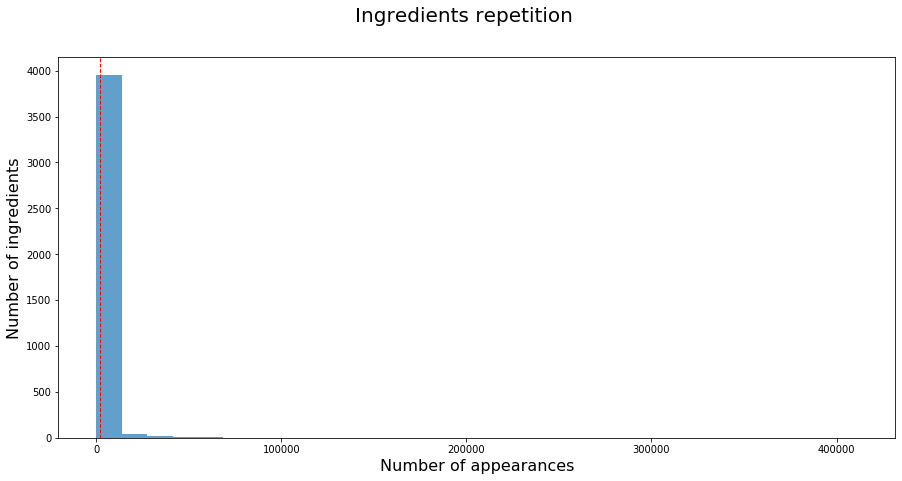

In [42]:
initial_time = time.time()
sorted_ingredients = sorted(dic_ingredients.items(), key=operator.itemgetter(1), reverse=True)
repetitionArray = []
_mean = 0
for i in sorted_ingredients:
    repetitionArray.append(i[1])
    _mean += i[1]
    
_mean = _mean/len(repetitionArray)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
print(color.GREEN + "Number of total ingredients:", len(repetitionArray), color.END)
printMain("Average of appearances of the ingredients in recipes: " + str(round(_mean, 2)) + " appearances.")
fig, ax = plt.subplots(figsize=(15, 7))
fig.suptitle('Ingredients repetition', fontsize=20)
plt.xlabel('Number of appearances', fontsize=16)
plt.ylabel('Number of ingredients', fontsize=16)
plt.axvline(_mean, color='red', linestyle='dashed', linewidth=1, label="mean")
ax.hist(repetitionArray,bins=30, alpha=0.7)
plt.show(fig)

In the above plot we can not really see how the distribution of the ingredients' appearances is in the high repetion area of the plto. However, we can know that the big majority of ingredients (> 3800, nearly 100%) appear in a low amount of recipes. 

Let's do the same analysis but with ingredients with more than 2000 appearances.

(Time: 0.0 seconds)
Ingredients in more than 2000 recipes:
Number of total ingredients: 228 
Average of appearances of the ingredients in recpies: 25944.43 appearances.


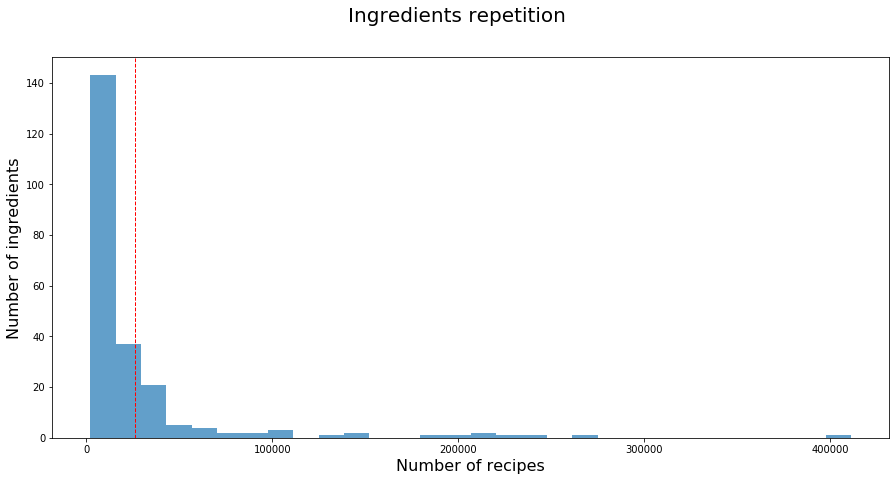

In [43]:
initial_time = time.time()
repetitionArray2 = []
_mean = 0
for i in sorted_ingredients:
    if i[1] > 2000:
        _mean += i[1]
        repetitionArray2.append(i[1])
        
_mean = _mean/len(repetitionArray2)

print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Ingredients in more than 2000 recipes:")
print(color.GREEN + "Number of total ingredients:", len(repetitionArray2), color.END)
printMain("Average of appearances of the ingredients in recpies: " + str(round(_mean, 2)) + " appearances.")
fig, ax = plt.subplots(figsize=(15, 7))
fig.suptitle('Ingredients repetition', fontsize=20)
plt.xlabel('Number of recipes', fontsize=16)
plt.ylabel('Number of ingredients', fontsize=16)
plt.axvline(_mean, color='red', linestyle='dashed', linewidth=1, label="mean")
ax.hist(repetitionArray2, bins=30, alpha=0.7)
plt.show(fig)

Eventhough we have zoomed to avoid the ingredients repeated a few number of times, we still see that there are much more ingredients in the lower repetition part of the histogram. This shows us that we base our diet on a small amount of ingredients, depending a lot on them. This leads us into the next question:

### Are there dominant ingredients?

The answer is yes, but let's see which ones they are, and how dominant they are. For this, let's print a bar plot of the top 10 ingredients appearance.

(Time: 0.04 seconds)


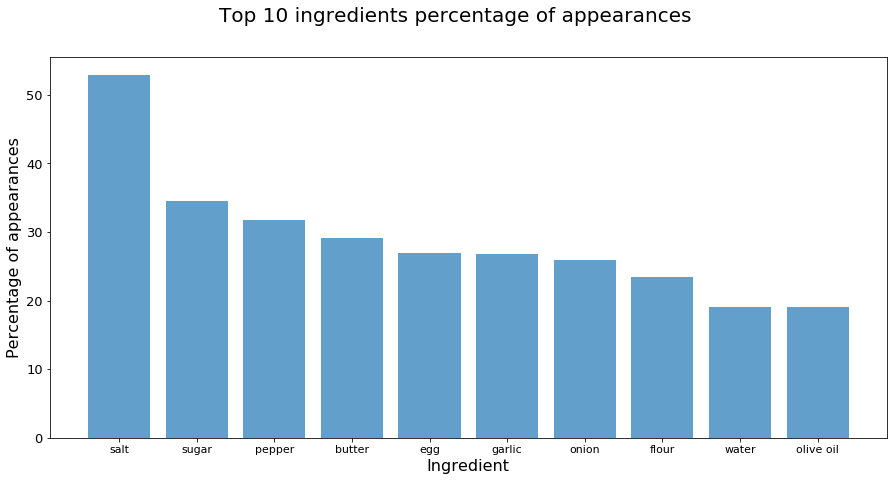

In [44]:
initial_time = time.time()
df_common_ing = df_common_ing.sort_values(by=['Quantity'], ascending=False)
top265_ingredients = df_common_ing.index.tolist()
top10_ingredients = top265_ingredients[:10]
top10_percentages = []
top10_appareances = []
hovers = []
count = 0
for i in repetitionArray2[:10]:
    top10_appareances.append(i)
    top10_percentages.append(100*(i/len(df_ingredients)))
    hovers.append(top10_ingredients[count] + " appears in " + str(round(100*(i/len(df_ingredients)), 2)) + "% of the recipes (" + str(i) + ").")
    count += 1
fig, ax = plt.subplots(figsize=(15, 7))
plt.bar(np.arange(len(top10_percentages)), top10_percentages,
       align='center',
       alpha=0.7,
       ecolor='black',
       capsize=10, 
       tick_label=top10_ingredients) 
fig.suptitle('Top 10 ingredients percentage of appearances', fontsize=20)
plt.ylabel('Percentage of appearances', fontsize=16)
plt.xlabel('Ingredient', fontsize=16)
plt.xticks(fontsize=11)
plt.yticks(fontsize=13)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
plt.show()

(Time: 1.52 seconds)


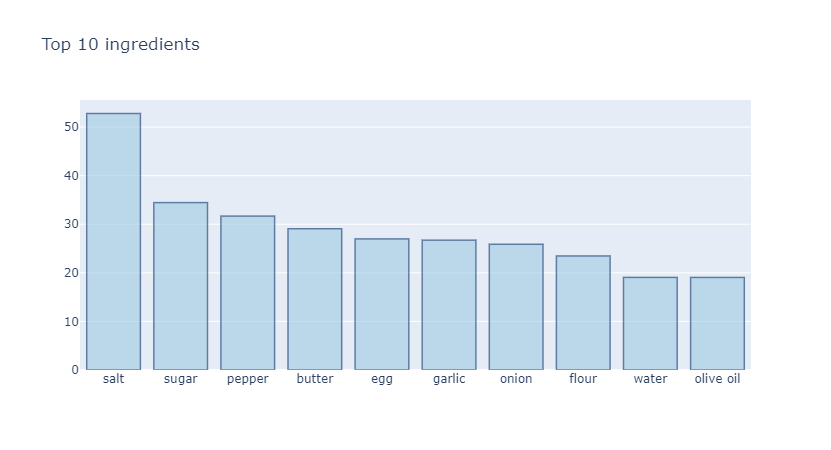

In [45]:
# Use the hovertext kw argument for hover text
initial_time = time.time()
fig = go.Figure(data=[go.Bar(x=top10_ingredients,
                             y=top10_percentages,
                             hovertext=hovers,
                             hoverinfo="text",
                            )])
# Customize aspect
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(title_text='Top 10 ingredients')
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
fig.show()

We can already see a decrease in the top 10 ingredients. From the `salt` the basic ingredient in our diet, to `olive oil` that falls below the 20% of the recipes.

Let's see the dominance of the most common ingredients in a scatter plot of the top 265 ingredients.

(Time: 0.23 seconds)


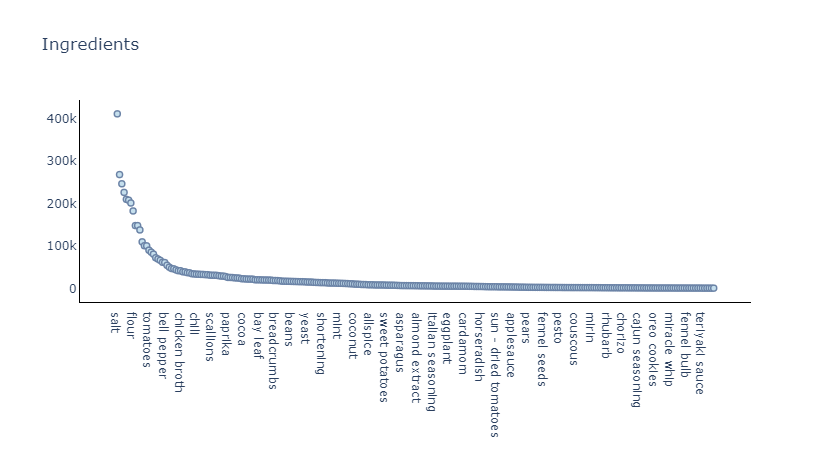

In [47]:
initial_time = time.time()
hovers = []
for row in df_common_ing.itertuples():
    hovers.append(row[0] + ": " + str(row[11]))

fig = go.Figure(
    data=go.Scatter(
        y=df_common_ing["Quantity"].tolist(),
        x=df_common_ing.index.tolist(),
        mode='markers',
        text=hovers,
        hoverinfo="text",
    )
)
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(title_text='Ingredients', plot_bgcolor='white')
fig.update_xaxes(showline=True, linewidth=1, linecolor='black')
fig.update_yaxes(showline=True, linewidth=1, linecolor='black')
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
fig.show()

In this second plot we can clearly see how a few ingredients (the top 25) are so much more present in recipes that dominate the other ingredients. This means that in our diet analysis, we will obviusly see as most present the dominant ingredients in every diet. We need to take this into account in the future.

This dominance of ingredients, confirms us that the decision made of concentrating effort in the top 265 ingredients is, indeed, a good idea.

*Before the formatting of the ingredients' names with the aforementioned dictionary, the sugar was in the 3rd postion with a percentage of appearances of 30% (now it's above 40%). This is just an example of why the formatting was so important. In the case of the sugars, there were a lot of names for sugar, which is actually an important distinction for someone reading the recipe, but not for health, and, therefore, for us.*

### Are the most common ingredients healthy?

To answer this, let's get the unhealthy ingredients in the top 265 into a list and plot the top 10 (of the unhealthy) in a bar plot. 

In [49]:
df_common_ing = df_common_ing.sort_values(by=['Quantity'], ascending=False)
df_unhealthy_ingredients = df_common_ing[df_common_ing["Unhealthy"] == 1]
unhealthy_ingredients = list(df_unhealthy_ingredients.index)

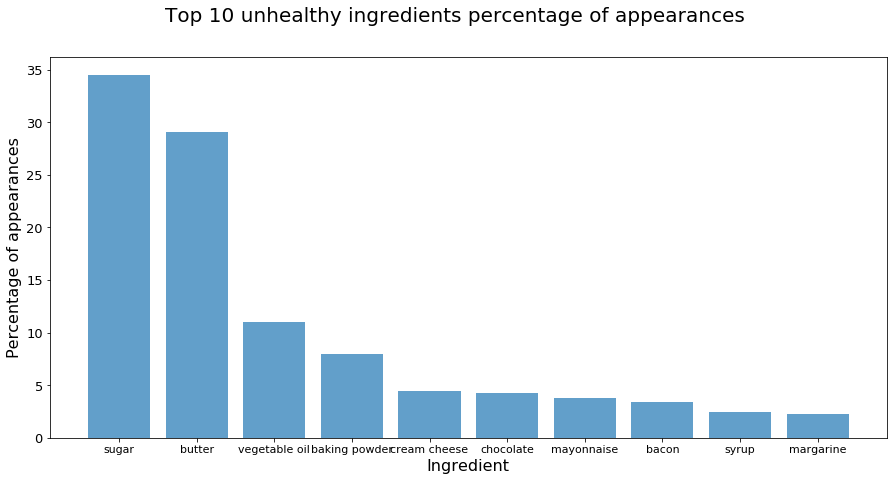

In [50]:
top10_percentages_unhealthy = []

for i in unhealthy_ingredients[:10]:
    top10_percentages_unhealthy.append(100*(dic_ingredients[i]/len(df_ingredients)))

fig, ax = plt.subplots(figsize=(15, 7))
plt.bar(np.arange(10), top10_percentages_unhealthy,
       align='center',
       alpha=0.7,
       ecolor='black',
       capsize=10, 
       tick_label=unhealthy_ingredients[:10]) 
fig.suptitle('Top 10 unhealthy ingredients percentage of appearances', fontsize=20)
plt.ylabel('Percentage of appearances', fontsize=16)
plt.xlabel('Ingredient', fontsize=16)
plt.xticks(fontsize=11)
plt.yticks(fontsize=13)
plt.show()

We can see that there are some really dominant ingredients that are unhealthy (especially `sugar` and `butter`). This is going to make a lot of recipes unhealthy. This is really important for the future analysis, any diet that bans one of this ingredient will see the number of unhealthy recipes reduced drasticaly (e.g. vegan with butter).

**Important note:** We understand that it is also important to the "healthiness" of a recipe the quantity of these "unhealthy" ingredients in the recipes. There are two reasons why we do not take this into account. Firstly, given, the way the quantities are defined in the dataset, it's impossible to automate the reading of the values, as they are directly extracted form the real recipes in web pages. Secondly, we believe we can still make the analysis we try to do, as we make the assumption that in the big majority of recipes where unhealthy ingredients are used, they are used in a high enough quantity to consider them unhealthy. We assume that it is not common to use these unhealthy ingredients in such a low quantity that the meal created can be cataloged as healthy.

Let's finally see how this really affects the recipes. Let's see what the percentage of unhealthy recipes is.

In [51]:
printMain("Number of unhealthy recipes: " + str(len(df_ingredients[df_ingredients["Unhealthy"] == 1])))
printMain("Number of healthy recipes: " + str(len(df_ingredients[df_ingredients["Unhealthy"] == 0])))
printMain("Percentage of unhealthy recipes: " + str(100*round(len(df_ingredients[df_ingredients["Unhealthy"] == 1])/len(df_ingredients),2)) + "%")

Number of unhealthy recipes: 537524
Number of healthy recipes: 241564
Percentage of unhealthy recipes: 69.0%


Now that we have seen the analysis of ingredients. Let's do a general analysis of the recipes. First of all lets answer the following question:

### What is the reduction in number of recipes per diet?

(Time: 0.62 seconds)


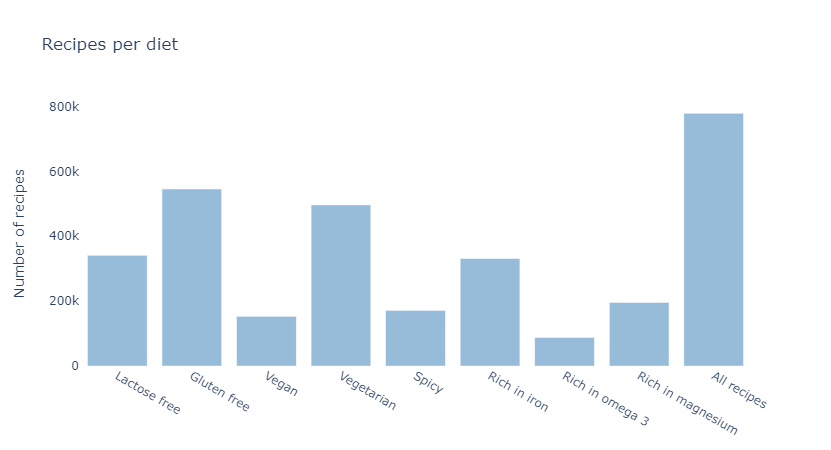

In [52]:
initial_time = time.time()
_keys_diets = ["Lactose free", "Gluten free", "Vegan", "Vegetarian", "Spicy", "Rich in iron", "Rich in omega 3", "Rich in magnesium", "All recipes"]
diets_keys = ["LactoseFree", "GlutenFree", "Vegan", "Vegetarian", "Spicy", "IronRich", "Omega3Rich", "MagnesiumRich"]
_data = []
_hovers = []
total = len(df_ingredients)
for i in diets_keys:
    value = len(df_ingredients[df_ingredients[i] == 1])
    _data.append(value)
    _hovers.append(i.capitalize() + " recipes: " + str(value) + " (" + str(round(value*100/total, 2)) + "%)")
    
_data.append(total)
_hovers.append("Total number of recipes: " + str(total))
fig = go.Figure(data=[go.Bar(x=_keys_diets,
                             y=_data,
                             hovertext=_hovers,
                             hoverinfo="text",
                            )])
# Customize aspect
fig.update_traces(marker_color='#1769aa', opacity=0.45)
fig.update_yaxes(title_text='Number of recipes')
fig.update_layout(title_text='Recipes per diet', plot_bgcolor='white')
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
fig.show()

We can see that the reduction in number of recipes is big precentage-wise, however, the ammount of recipes is still high enough for analysis. The lowest diet is the one rich in omega 3. There are not so many ingredients rich in omega 3. But there are still ~90000 recipes rich in omega 3.

In the previous question, we saw that only ~30% of the recipes are healthy. This lead us into the next question.

### Is it easier or harder to eat healthy with the selected diets?

Let's plot the precentage of healthy recipes per type of diet.

(Time: 0.91 seconds)


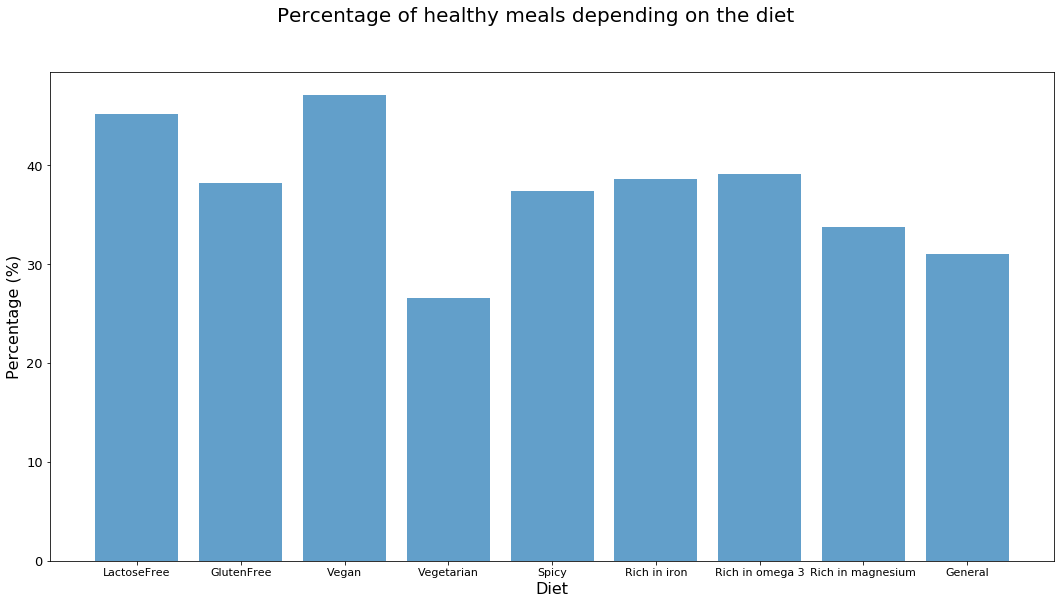

In [54]:
initial_time = time.time()
_data_healthyness = []
_data_healthyness.append(100*len(df_ingredients[(df_ingredients["LactoseFree"] == 1) & (df_ingredients["Unhealthy"] == 0)])/len(df_ingredients[df_ingredients["LactoseFree"] == 1]))
_data_healthyness.append(100*len(df_ingredients[(df_ingredients["GlutenFree"] == 1) & (df_ingredients["Unhealthy"] == 0)])/len(df_ingredients[df_ingredients["GlutenFree"] == 1]))
_data_healthyness.append(100*len(df_ingredients[(df_ingredients["Vegan"] == 1) & (df_ingredients["Unhealthy"] == 0)])/len(df_ingredients[df_ingredients["Vegan"] == 1]))
_data_healthyness.append(100*len(df_ingredients[(df_ingredients["Vegetarian"] == 1) & (df_ingredients["Unhealthy"] == 0)])/len(df_ingredients[df_ingredients["Vegetarian"] == 1]))
_data_healthyness.append(100*len(df_ingredients[(df_ingredients["Spicy"] == 1) & (df_ingredients["Unhealthy"] == 0)])/len(df_ingredients[df_ingredients["Spicy"] == 1]))
_data_healthyness.append(100*len(df_ingredients[(df_ingredients["IronRich"] == 1) & (df_ingredients["Unhealthy"] == 0)])/len(df_ingredients[df_ingredients["IronRich"] == 1]))
_data_healthyness.append(100*len(df_ingredients[(df_ingredients["Omega3Rich"] == 1) & (df_ingredients["Unhealthy"] == 0)])/len(df_ingredients[df_ingredients["Omega3Rich"] == 1]))
_data_healthyness.append(100*len(df_ingredients[(df_ingredients["MagnesiumRich"] == 1) & (df_ingredients["Unhealthy"] == 0)])/len(df_ingredients[df_ingredients["MagnesiumRich"] == 1]))
_data_healthyness.append(100*len(df_ingredients[df_ingredients["Unhealthy"] == 0])/len(df_ingredients))
_keys_diets = ["LactoseFree", "GlutenFree", "Vegan", "Vegetarian", "Spicy", "Rich in iron", "Rich in omega 3", "Rich in magnesium", "General"]
fig, ax = plt.subplots(figsize=(18, 9))
plt.bar(np.arange(9), _data_healthyness,
       align='center',
       alpha=0.7,
       ecolor='black',
       capsize=10, 
       tick_label=_keys_diets) 
fig.suptitle('Percentage of healthy meals depending on the diet', fontsize=20)
plt.ylabel('Percentage (%)', fontsize=16)
plt.xlabel('Diet', fontsize=16)
plt.xticks(fontsize=11)
plt.yticks(fontsize=13)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
plt.show()

(Time: 0.18 seconds)


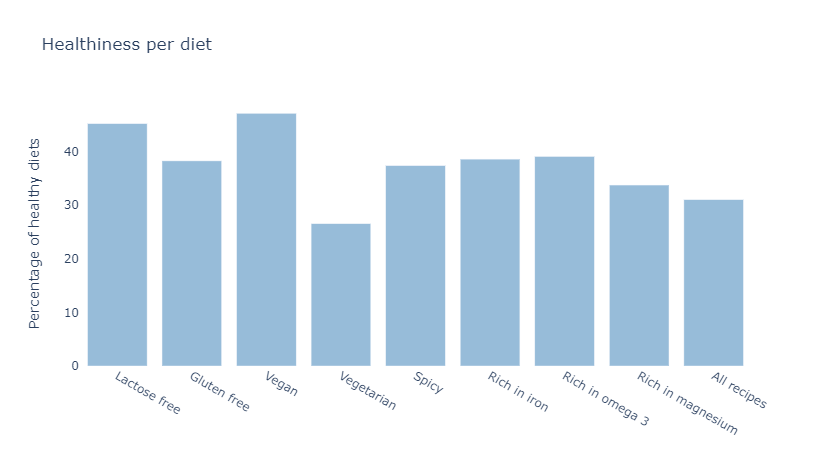

In [55]:
initial_time = time.time()
_keys_diets = ["Lactose free", "Gluten free", "Vegan", "Vegetarian", "Spicy", "Rich in iron", "Rich in omega 3", "Rich in magnesium", "All recipes"]
diets_keys = ["LactoseFree", "GlutenFree", "Vegan", "Vegetarian", "Spicy", "IronRich", "Omega3Rich", "MagnesiumRich"]
from plotly.graph_objs import Layout
_hovers = []
count = 0
layout = Layout(
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)
for i in _keys_diets:
    _hovers.append(i.capitalize() + " diet: " + str(round(_data_healthyness[count], 2)) + "% of the recipes are healthy")
    count += 1
    
_data.append(total)
_hovers.append("Total number of recipes: " + str(total))
fig = go.Figure(data=[go.Bar(x=_keys_diets,
                             y=_data_healthyness,
                             hovertext=_hovers,
                             hoverinfo="text",
                             #layout=layout
                            )])
# Customize aspect
fig.update_traces(marker_color='#1769aa', opacity=0.45)
fig.update_yaxes(title_text='Percentage of healthy diets')
fig.update_layout(title_text='Healthiness per diet', plot_bgcolor='white')
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
fig.show()

We can see that there are changes in the results. All diets, except vegetarian are in general more healthy. For example, for a vegan, it's easier to avoid unhealthy food than for a person with a regular diet. Obviously, this is a simple approach, as we are not taking other things into account. 

We can also see that vegetarian recipes are in general more healthy. This is because the vegetarian diet does not avoid any unhealthy dominant ingredients. But... gluten free does not either. Probably becasue it avoids a lot of bakery that contains sugar. We will see in future analysis!

### What is the distribution of the number of ingredients of recipes?

Let's add a new feature to the dataframe `df_ingredients`that has the amount of ingredients per recipe. Then, let's plot the distribution of values of this column.

In [57]:
initial_time = time.time()
df_ingredients['length'] = df_ingredients['ingredients'].apply(lambda x: len(x))
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("DataFrame with new column: ")
df_ingredients.head()

(Time: 0.39 seconds)
DataFrame with new column: 


id                                        ingredients  LactoseFree  \
1  000033e39b  [celery, pasta, dill, salt, bell pepper, mayon...            0   
2  000035f7ed  [tomatoes, onion, cucumber, salt, olive oil, b...            1   
3  00003a70b1  [butter, corn, water, french - fried onions, m...            0   
5  0000631d90  [pepper, soy sauce, lemon, garlic, salt, cashe...            1   
6  000075604a                             [tea, chicken, pepper]            1   

   GlutenFree  Vegan  Vegetarian  IronRich  Omega3Rich  MagnesiumRich  Spicy  \
1           1      0           1         0           0              0      0   
2           1      1           1         0           0              0      0   
3           1      0           1         1           0              0      0   
5           1      0           0         1           0              0      0   
6           1      0           0         0           0              0      0   

   Unhealthy  length  
1          1       9  
2          0       7  
3          1       7  
5          0      11  
6          0       3

(Time: 0.08 seconds)


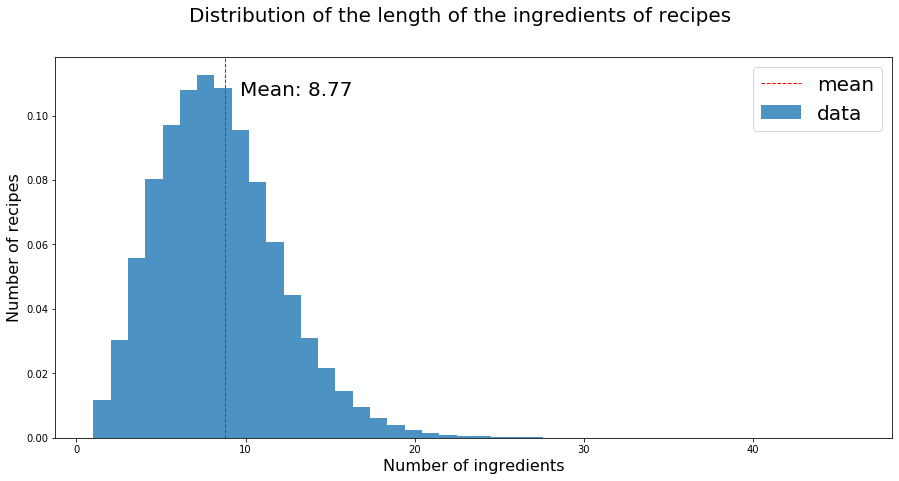

In [58]:
initial_time = time.time()
fig, ax = plt.subplots(figsize=(15, 7))
_data = df_ingredients["length"]
_mean = df_ingredients["length"].mean()
fig.suptitle('Distribution of the length of the ingredients of recipes', fontsize=20)
plt.xlabel('Number of ingredients', fontsize=16)
plt.ylabel('Number of recipes', fontsize=16)
plt.hist(_data, density=True, bins=44, alpha=0.8, label="data")
plt.axvline(_mean, color='red', linestyle='dashed', linewidth=1, label="mean")
ax.legend(prop={'size': 20})
min_ylim, max_ylim = plt.ylim()
plt.text(_mean*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(_mean), fontsize=20)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
plt.show(fig)

*In this analysis, we found some outliers with a large amount of ingredients (>100). We discovered the problem was that some ingredients were repeated in the list. We actually solve this in the formating of ingredients in the section 1.

### Does the distribution change when taking into account the diets?

Let's see.

(Time: 0.24 seconds)


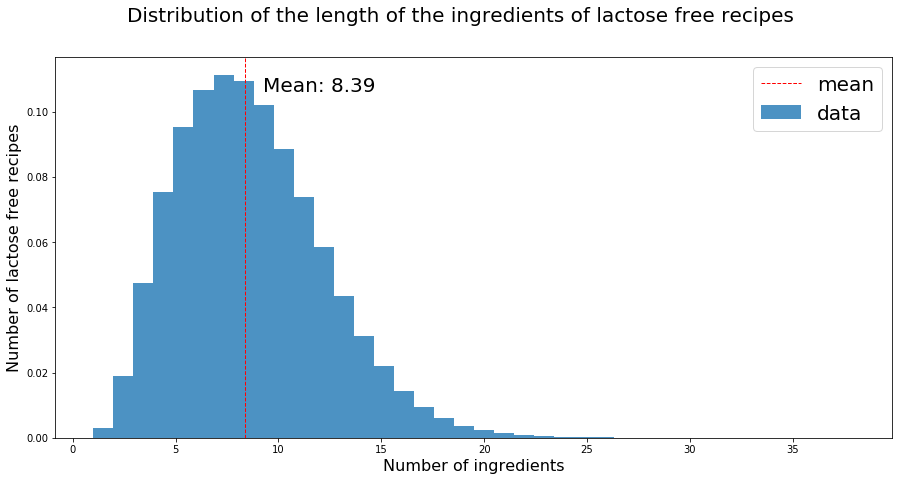

In [59]:
initial_time = time.time()
fig, ax = plt.subplots(figsize=(15, 7))
_data = df_ingredients[df_ingredients["LactoseFree"] == 1]["length"]
_mean = df_ingredients[df_ingredients["LactoseFree"] == 1]["length"].mean()
fig.suptitle('Distribution of the length of the ingredients of lactose free recipes', fontsize=20)
plt.xlabel('Number of ingredients', fontsize=16)
plt.ylabel('Number of lactose free recipes', fontsize=16)
plt.hist(_data, density=True, bins=38, alpha=0.8, label="data")
plt.axvline(_mean, color='red', linestyle='dashed', linewidth=1, label="mean")
ax.legend(prop={'size': 20})
plt.text(_mean*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(_mean), fontsize=20)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
plt.show(fig)

(Time: 0.23 seconds)


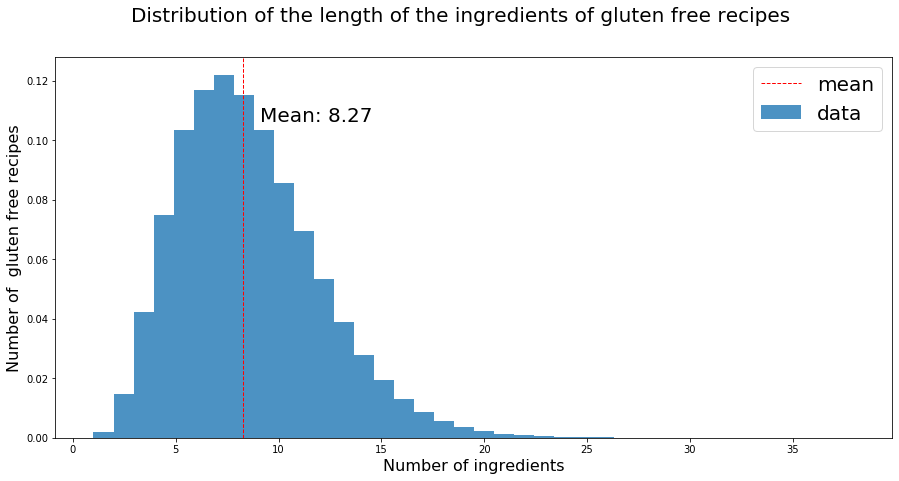

In [60]:
initial_time = time.time()
fig, ax = plt.subplots(figsize=(15, 7))
_data = df_ingredients[df_ingredients["GlutenFree"] == 1]["length"]
_mean = df_ingredients[df_ingredients["GlutenFree"] == 1]["length"].mean()
fig.suptitle('Distribution of the length of the ingredients of gluten free recipes', fontsize=20)
plt.xlabel('Number of ingredients', fontsize=16)
plt.ylabel('Number of  gluten free recipes', fontsize=16)
plt.hist(_data, density=True, bins=38, alpha=0.8, label="data")
plt.axvline(_mean, color='red', linestyle='dashed', linewidth=1, label="mean")
ax.legend(prop={'size': 20})
plt.text(_mean*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(_mean), fontsize=20)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
plt.show(fig)

We see there are small changes in the distributions in the different diets, but they are not significant.

(Time: 0.11 seconds)


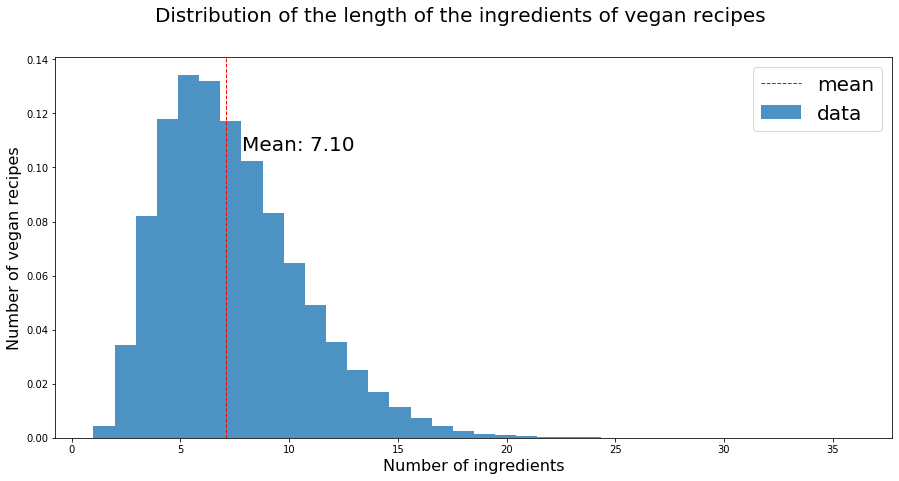

In [61]:
initial_time = time.time()
fig, ax = plt.subplots(figsize=(15, 7))
_data = df_ingredients[df_ingredients["Vegan"] == 1]["length"]
_mean = df_ingredients[df_ingredients["Vegan"] == 1]["length"].mean()
fig.suptitle('Distribution of the length of the ingredients of vegan recipes', fontsize=20)
plt.xlabel('Number of ingredients', fontsize=16)
plt.ylabel('Number of vegan recipes', fontsize=16)
plt.hist(_data, density=True, bins=36, alpha=0.8, label="data")
plt.axvline(_mean, color='red', linestyle='dashed', linewidth=1, label="mean")
ax.legend(prop={'size': 20})
plt.text(_mean*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(_mean), fontsize=20)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
plt.show(fig)

(Time: 0.22 seconds)


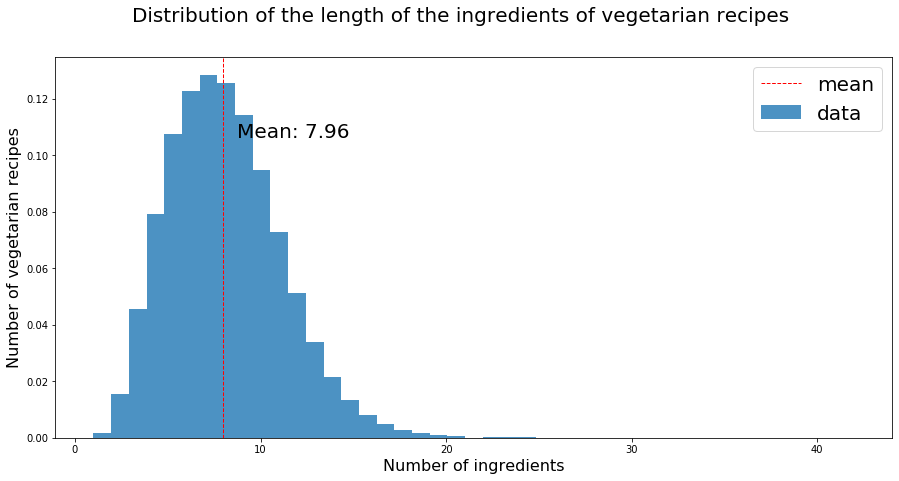

In [62]:
initial_time = time.time()
fig, ax = plt.subplots(figsize=(15, 7))
_data = df_ingredients[df_ingredients["Vegetarian"] == 1]["length"]
_mean = df_ingredients[df_ingredients["Vegetarian"] == 1]["length"].mean()
fig.suptitle('Distribution of the length of the ingredients of vegetarian recipes', fontsize=20)
plt.xlabel('Number of ingredients', fontsize=16)
plt.ylabel('Number of vegetarian recipes', fontsize=16)
plt.hist(_data, density=True, bins=43, alpha=0.8, label="data")
plt.axvline(_mean, color='red', linestyle='dashed', linewidth=1, label="mean")
ax.legend(prop={'size': 20})
plt.text(_mean*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(_mean), fontsize=20)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
plt.show(fig)

(Time: 0.21 seconds)


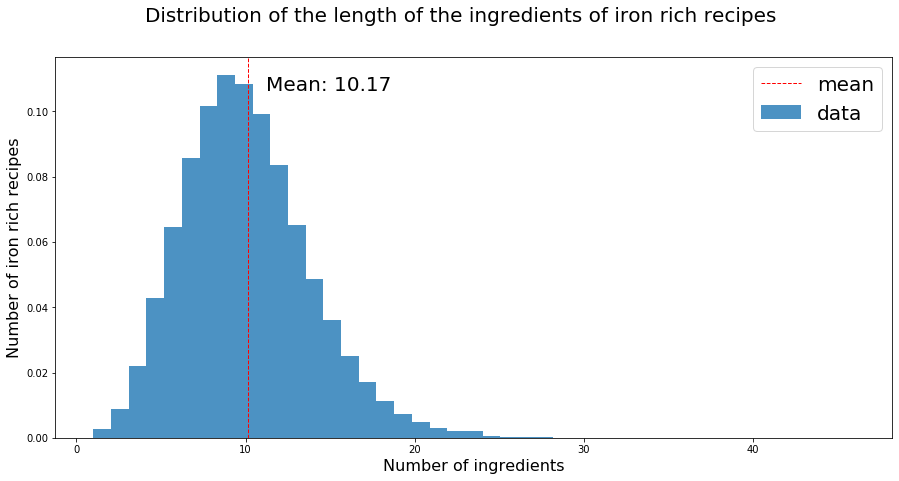

In [63]:
initial_time = time.time()
fig, ax = plt.subplots(figsize=(15, 7))
_data = df_ingredients[df_ingredients["IronRich"] == 1]["length"]
_mean = df_ingredients[df_ingredients["IronRich"] == 1]["length"].mean()
fig.suptitle('Distribution of the length of the ingredients of iron rich recipes', fontsize=20)
plt.xlabel('Number of ingredients', fontsize=16)
plt.ylabel('Number of iron rich recipes', fontsize=16)
plt.hist(_data, density=True, bins=43, alpha=0.8, label="data")
plt.axvline(_mean, color='red', linestyle='dashed', linewidth=1, label="mean")
ax.legend(prop={'size': 20})
plt.text(_mean*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(_mean), fontsize=20)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
plt.show(fig)

(Time: 0.12 seconds)


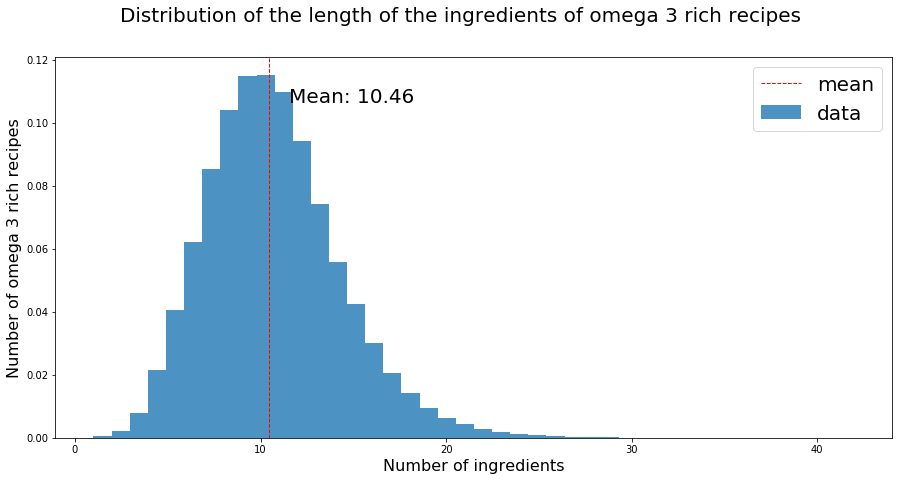

In [64]:
initial_time = time.time()
fig, ax = plt.subplots(figsize=(15, 7))
_data = df_ingredients[df_ingredients["Omega3Rich"] == 1]["length"]
_mean = df_ingredients[df_ingredients["Omega3Rich"] == 1]["length"].mean()
fig.suptitle('Distribution of the length of the ingredients of omega 3 rich recipes', fontsize=20)
plt.xlabel('Number of ingredients', fontsize=16)
plt.ylabel('Number of omega 3 rich recipes', fontsize=16)
plt.hist(_data, density=True, bins=42, alpha=0.8, label="data")
plt.axvline(_mean, color='red', linestyle='dashed', linewidth=1, label="mean")
ax.legend(prop={'size': 20})
plt.text(_mean*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(_mean), fontsize=20)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
plt.show(fig)

(Time: 0.15 seconds)


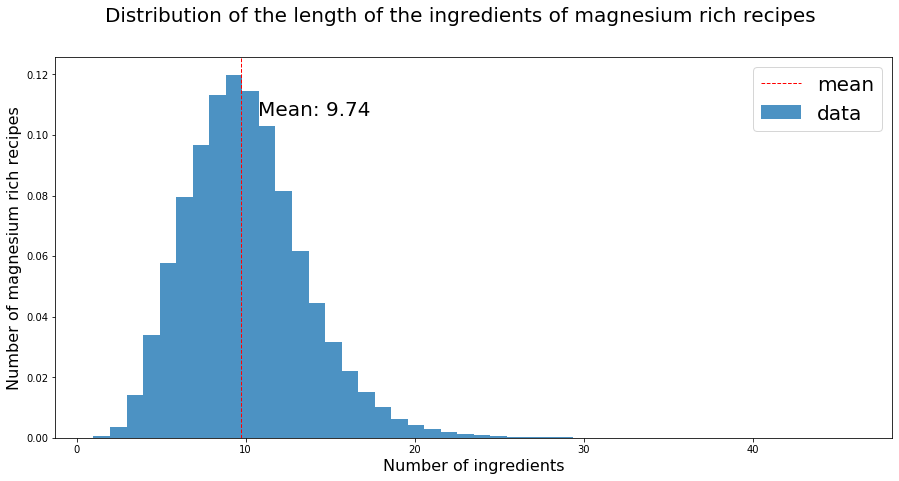

In [65]:
initial_time = time.time()
fig, ax = plt.subplots(figsize=(15, 7))
_data = df_ingredients[df_ingredients["MagnesiumRich"] == 1]["length"]
_mean = df_ingredients[df_ingredients["MagnesiumRich"] == 1]["length"].mean()
fig.suptitle('Distribution of the length of the ingredients of magnesium rich recipes', fontsize=20)
plt.xlabel('Number of ingredients', fontsize=16)
plt.ylabel('Number of magnesium rich recipes', fontsize=16)
plt.hist(_data, density=True, bins=46, alpha=0.8, label="data")
plt.axvline(_mean, color='red', linestyle='dashed', linewidth=1, label="mean")
ax.legend(prop={'size': 20})
plt.text(_mean*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(_mean), fontsize=20)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
plt.show(fig)

(Time: 0.14 seconds)


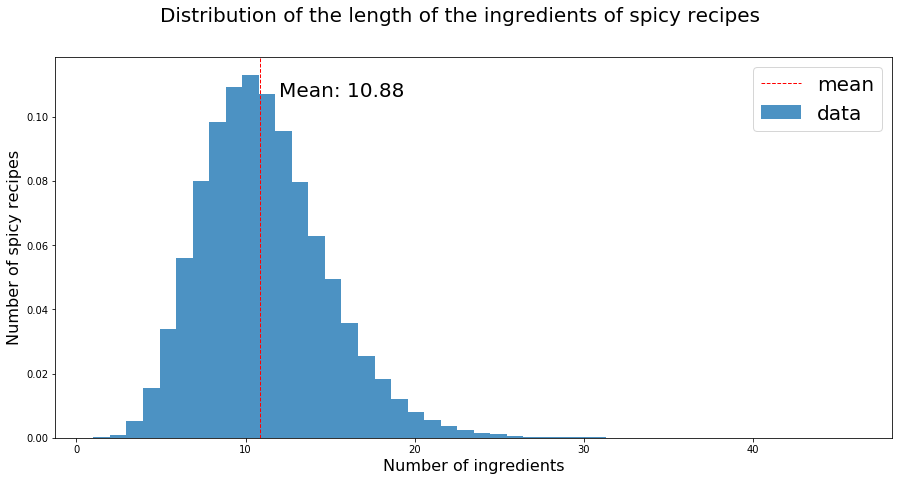

In [66]:
initial_time = time.time()
fig, ax = plt.subplots(figsize=(15, 7))
_data = df_ingredients[df_ingredients["Spicy"] == 1]["length"]
_mean = df_ingredients[df_ingredients["Spicy"] == 1]["length"].mean()
fig.suptitle('Distribution of the length of the ingredients of spicy recipes', fontsize=20)
plt.xlabel('Number of ingredients', fontsize=16)
plt.ylabel('Number of spicy recipes', fontsize=16)
plt.hist(_data, density=True, bins=46, alpha=0.8, label="data")
plt.axvline(_mean, color='red', linestyle='dashed', linewidth=1, label="mean")
ax.legend(prop={'size': 20})
plt.text(_mean*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(_mean), fontsize=20)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
plt.show(fig)

(Time: 0.29 seconds)


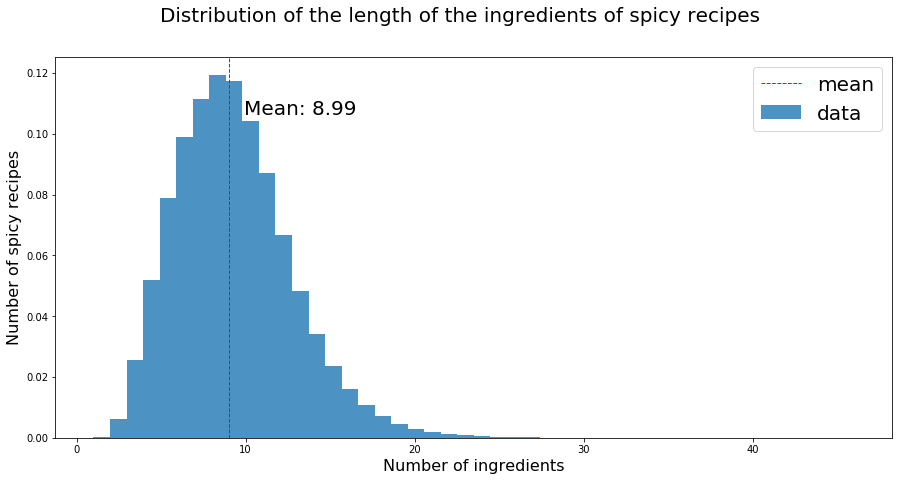

In [67]:
initial_time = time.time()
fig, ax = plt.subplots(figsize=(15, 7))
_data = df_ingredients[df_ingredients["Unhealthy"] == 1]["length"]
_mean = df_ingredients[df_ingredients["Unhealthy"] == 1]["length"].mean()
fig.suptitle('Distribution of the length of the ingredients of spicy recipes', fontsize=20)
plt.xlabel('Number of ingredients', fontsize=16)
plt.ylabel('Number of spicy recipes', fontsize=16)
plt.hist(_data, density=True, bins=46, alpha=0.8, label="data")
plt.axvline(_mean, color='red', linestyle='dashed', linewidth=1, label="mean")
ax.legend(prop={'size': 20})
plt.text(_mean*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(_mean), fontsize=20)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
plt.show(fig)

## 4) Starting the core analysis

In this part we will start with the core analysis of the project. 

First we will create a correlation matrix in which each row and column are the top 265 ingredients and the cells are the percentage of recipes with the column ingredient also contain the row ingredient.

In [68]:
# We want to find, for each ingredient, how often they occur together with another ingredient
initial_time = time.time()
occurrence_dict = {}
for ingredient_list in df_ingredients["ingredients"]:
    for ingredient in ingredient_list:
        if ingredient not in common_ing:
            continue
        if ingredient not in occurrence_dict.keys():
            occurrence_dict[ingredient] = {}
        for other_ingredient in ingredient_list:
            if other_ingredient not in common_ing:
                continue
            # Iterate through each other ingredient in the recipe
            if other_ingredient not in occurrence_dict[ingredient].keys():
                occurrence_dict[ingredient][other_ingredient] = 0
            occurrence_dict[ingredient][other_ingredient] = occurrence_dict[ingredient][other_ingredient] + 1
print("(Time:", round(time.time() - initial_time, 2), "seconds)")


(Time: 104.83 seconds)


In [69]:
# We calculate the ratio at which two ingredients appear in the same recipe, for each ingredient
initial_time = time.time()
ratios_dict_toExport = {}
ratios_dict = {}
for ingredient in occurrence_dict.keys():
    occurrences = occurrence_dict[ingredient]
    ratios = {}
    ratios_export = {}
    for other_ingredient in occurrences:
        if other_ingredient != ingredient:
            ratios_export[other_ingredient] = occurrences[other_ingredient] / occurrences[ingredient]
        ratios[other_ingredient] = occurrences[other_ingredient] / occurrences[ingredient]
    ratios_dict[ingredient] = ratios
    ratios_dict_toExport[ingredient] = ratios_export

print("(Time:", round(time.time() - initial_time, 2), "seconds)")

(Time: 0.05 seconds)


In [70]:
initial_time = time.time()
df_ratios = pd.DataFrame(ratios_dict)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
df_ratios

(Time: 0.05 seconds)


celery     pasta      dill      salt  bell pepper  \
celery                 1.000000  0.082816  0.128937  0.067776     0.155528   
pasta                  0.055810  1.000000  0.041670  0.040384     0.075967   
dill                   0.043466  0.020844  1.000000  0.022310     0.018049   
salt                   0.659225  0.582868  0.643704  1.000000     0.581756   
bell pepper            0.226198  0.163947  0.077867  0.086988     1.000000   
...                         ...       ...       ...       ...          ...   
graham cracker crumbs  0.000024       NaN       NaN  0.001661          NaN   
graham crackers             NaN       NaN  0.000070  0.000900     0.000033   
butterscotch chips          NaN       NaN       NaN  0.001250          NaN   
white chocolate             NaN       NaN       NaN  0.002213     0.000033   
oreo cookies                NaN       NaN       NaN  0.000486          NaN   

                       mayonnaise    cheese   vinegar  tomatoes     onion  \
celery                   0.174272  0.046034  0.085120  0.112942  0.153600   
pasta                    0.038667  0.122552  0.029464  0.094133  0.055312   
dill                     0.094166  0.019942  0.033602  0.020221  0.028095   
salt                     0.510647  0.540393  0.656002  0.656727  0.661291   
bell pepper              0.106672  0.120034  0.144982  0.211003  0.197112   
...                           ...       ...       ...       ...       ...   
graham cracker crumbs    0.000034  0.000673  0.000261  0.000077  0.000035   
graham crackers          0.000068  0.000398  0.000165  0.000044  0.000025   
butterscotch chips            NaN  0.000043  0.000110       NaN       NaN   
white chocolate               NaN  0.000297  0.000192  0.000033  0.000020   
oreo cookies                  NaN  0.000065  0.000069       NaN       NaN   

                       ...  sunflower seeds  corn flakes  egg substitute  \
celery                 ...         0.055463     0.025012        0.017241   
pasta                  ...         0.016681     0.007874        0.011700   
dill                   ...         0.019600     0.009264        0.011084   
salt                   ...         0.460801     0.474294        0.532635   
bell pepper            ...         0.065054     0.021769        0.084360   
...                    ...              ...          ...             ...   
graham cracker crumbs  ...         0.001668          NaN        0.010468   
graham crackers        ...         0.000417     0.000926        0.004926   
butterscotch chips     ...         0.001668     0.016211        0.002463   
white chocolate        ...         0.000834     0.002779        0.000616   
oreo cookies           ...              NaN          NaN        0.000616   

                       graham crackers  lemongrass  marshmallows   anchovy  \
celery                             NaN    0.032323      0.011820  0.034068   
pasta                              NaN    0.006734      0.004728  0.111723   
dill                          0.000477    0.004714           NaN  0.013026   
salt                          0.176527    0.434343      0.179275  0.620240   
bell pepper                   0.000954    0.080808           NaN  0.086673   
...                                ...         ...           ...       ...   
graham cracker crumbs         0.014790         NaN      0.044129  0.001002   
graham crackers               1.000000         NaN      0.057132       NaN   
butterscotch chips            0.012882         NaN      0.032703       NaN   
white chocolate               0.020515    0.000673      0.017336       NaN   
oreo cookies                  0.005248         NaN      0.020095       NaN   

                       poppy seeds  lemon pepper       gin  
celery                    0.031935      0.089562  0.008886  
pasta                     0.014621      0.054768  0.000684  
dill                      0.013851      0.095361  0.006835  
salt                      0.612543      0.512242  0.066986  
bell pep

With this we can see that actually yes, with the data that we have we can do the analysis we want to do. If we print the same matrix as above but with only the top ten ingredients we will see the conclusion better. This is not useful for the future analysis, but it is for viewing the results.

In [71]:
df_ratios_dominant = df_ratios.drop(columns=common_ing[10:])
df_ratios_dominant = df_ratios_dominant.drop(common_ing[10:])

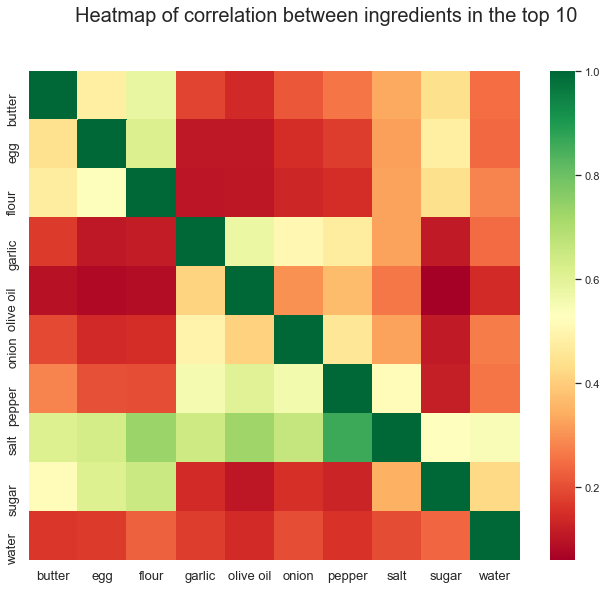

In [72]:
import seaborn as sns
sns.set()
plt.figure(figsize = (11,9))
df_ratios_dominant = df_ratios_dominant.sort_index(ascending=True)
df_ratios_dominant = df_ratios_dominant.sort_index(ascending=True, axis=1)
plt.suptitle('Heatmap of correlation between ingredients in the top 10', fontsize=20)
ax = sns.heatmap(df_ratios_dominant, cmap="RdYlGn")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.set_ylim(10, 0)
plt.show()

In [73]:
hover_heatmap = []
for row in df_ratios_dominant.itertuples():
    i = 0
    hover_row = []
    for col in df_ratios_dominant.index.tolist():
        #print(i, row[i+1])
        hover_row.append(col.capitalize() + " shares " + str(round(row[i+1]*100, 2)) + "% of its recipes with " + row[0])
        i += 1
    hover_heatmap.append(hover_row)


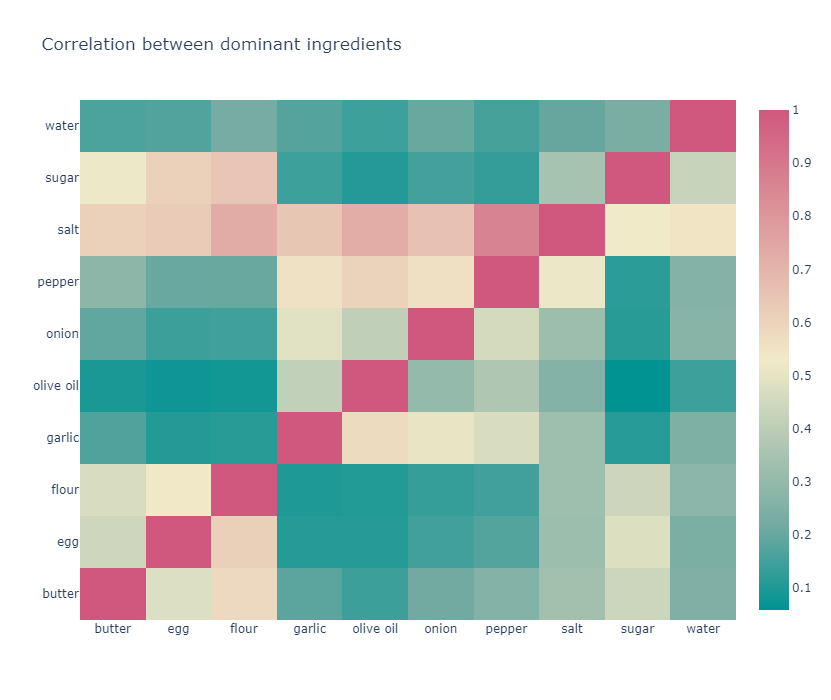

In [74]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Heatmap(
                   z=df_ratios_dominant.values.tolist(),
                   x=df_ratios_dominant.index.tolist(),
                   y=df_ratios_dominant.index.tolist(),
                   colorscale="Tealrose",
                   hoverinfo='text',
                   hovertext=hover_heatmap
))

fig.update_layout(
    title="Correlation between dominant ingredients",
    width=700,
    height=700,
    paper_bgcolor="White"
)

fig.show()

*The heat map is not symmetric because the ratio of, for example, egg in the recipes with butter is not the same as the ratio of butter in recipes with egg* 

---

Let's do the analysis of each diet on it's own. We will do the following analysis in each case:

- See which ingredients vary their appearances drasticaly. 
- How does the number of average number of ingredients per recipe varies.
- How much does the number of recipes and their healthyness varies.

## LactoseFree

Let's find tendencies on it. 

In [76]:
ingredient_list = df_common_ing.index.tolist()

In [77]:
dic_ingredients_per = {}
for key in ingredient_list:
    dic_ingredients_per[key] = (dic_ingredients[key]/len(df_ingredients))*100

In [78]:
df_lactoseFree = df_ingredients[df_ingredients["LactoseFree"] == 1]
df_lactoseFree.head()

id                                        ingredients  \
2   000035f7ed  [tomatoes, onion, cucumber, salt, olive oil, b...   
5   0000631d90  [pepper, soy sauce, lemon, garlic, salt, cashe...   
6   000075604a                             [tea, chicken, pepper]   
12  0000c79afb  [wine, orange liqueur, water, lemon, brandy, o...   
14  00010379bf  [soy sauce, water, vegetable oil, sugar, bakin...   

    LactoseFree  GlutenFree  Vegan  Vegetarian  IronRich  Omega3Rich  \
2             1           1      1           1         0           0   
5             1           1      0           0         1           0   
6             1           1      0           0         0           0   
12            1           1      1           1         0           0   
14            1           0      1           1         1           0   

    MagnesiumRich  Spicy  Unhealthy  length  
2               0      0          0       7  
5               0      0          0      11  
6               0      0          0       3  
12              0      0          1       8  
14              1      0          1       7

In [79]:
# Getting the lactoseFree ingredients
ingredients_lactoseFree = df_common_ing[df_common_ing["LactoseFree"] == 1].index.tolist()
printMain("Ingredients abailable for lactose intolerance people: " + str(len(ingredients_lactoseFree)))

Ingredients abailable for lactose intolerance people: 249


In [80]:
# First, we recalculate the dictionary of ingredients
initial_time = time.time()
dic_ingredients_lactoseFree = {}
 
for row in df_lactoseFree.itertuples():
    for ing in row[2]:
        if ing in ingredients_lactoseFree:
            if ing in dic_ingredients_lactoseFree:
                dic_ingredients_lactoseFree[ing] += 1
            else:
                dic_ingredients_lactoseFree[ing] = 1

print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of different ingredients: " + str(len(dic_ingredients_lactoseFree)))

(Time: 4.02 seconds)
Number of different ingredients: 249


In [81]:
len(df_ingredients)

779088

In [82]:
len(df_lactoseFree)

341240

In [83]:
inital_time = time.time()
dic_ingredients_lactoseFree_per = {}
ingredients_lactoseFree_per = []
ingredients_lactoseFree_per_general = []
keys_lactoseFree = []

for key in ingredients_lactoseFree:
    
    ingredients_lactoseFree_per_general.append(dic_ingredients_per[key])
    keys_lactoseFree.append(key)
    if key in dic_ingredients_lactoseFree:
        ingredients_lactoseFree_per.append((dic_ingredients_lactoseFree[key]/len(df_lactoseFree))*100)
        dic_ingredients_lactoseFree_per[key] = (dic_ingredients_lactoseFree[key]/len(df_lactoseFree))*100
    else: 
        ingredients_lactoseFree_per.append(0)
        dic_ingredients_lactoseFree_per[key] = 0
print("(Time:", round(time.time() - initial_time, 2), "seconds)")


(Time: 4.06 seconds)


In [84]:
dic_more_per_lactoseFree = {}
dic_less_per_lactoseFree = {}
dic_double_lactoseFree = {}
dic_half_lactoseFree = {}
mean_change_lactoseFree = 0
absolute_change_lactoseFree = 0
dic_changes_lactoseFree = {}
mean_total = 0
initial_time = time.time()

for key in dic_ingredients_lactoseFree_per:
    change = dic_ingredients_lactoseFree_per[key] - dic_ingredients_per[key]
    dic_changes_lactoseFree[key] = change
    mean_change_lactoseFree += change
    absolute_change_lactoseFree += abs(change)
    mean_total += dic_ingredients_per[key]
    if dic_ingredients_lactoseFree_per[key] - 2 > dic_ingredients_per[key]:
        dic_more_per_lactoseFree[key] = [dic_ingredients_per[key], dic_ingredients_lactoseFree_per[key]]
    elif dic_ingredients_lactoseFree_per[key] + 2 < dic_ingredients_per[key]:
        dic_less_per_lactoseFree[key] = [dic_ingredients_per[key], dic_ingredients_lactoseFree_per[key]]
        
    if dic_ingredients_lactoseFree_per[key] > 2*dic_ingredients_per[key]:
        dic_double_lactoseFree[key] = [dic_ingredients_per[key], dic_ingredients_lactoseFree_per[key]]
    elif dic_ingredients_lactoseFree_per[key]*2 < dic_ingredients_per[key]:
        dic_half_lactoseFree[key] = [dic_ingredients_per[key], dic_ingredients_lactoseFree_per[key]]

mean_change_lactoseFree = mean_change_lactoseFree/len(dic_ingredients_lactoseFree_per)
absolute_change_lactoseFree = absolute_change_lactoseFree/len(dic_ingredients_lactoseFree_per)
mean_total = mean_total/len(dic_ingredients_lactoseFree_per)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")

printMain("Ingredients increasing more than 2%:")
print(dic_more_per_lactoseFree)
print()
printMain("Ingredients decreasing more than 2%:")
print(dic_less_per_lactoseFree)
print()
printMain("Ingredients multipling by 2 their percentage of appearances:")
print(dic_double_lactoseFree)
print()
printMain("Ingredients dividing by 2 their percentage of appearances:")
print(dic_half_lactoseFree)

(Time: 0.0 seconds)
Ingredients increasing more than 2%:
{'pepper': [31.675754215184938, 34.241589497128125], 'garlic': [26.720986589448177, 33.793224709881606], 'onion': [25.87653769535662, 30.63181338647286], 'water': [19.055870453658635, 23.909858164341813], 'olive oil': [19.051121311071405, 24.51002227171492], 'tomatoes': [11.635142628303862, 14.790470050404409], 'vegetable oil': [11.030589612469965, 15.70478255773063], 'vinegar': [9.335659129649025, 15.338471457039034], 'bell pepper': [7.89384511120695, 10.395909037627476], 'carrot': [6.0914813217505595, 8.447720079709296], 'ginger': [5.686007228965149, 9.146934708709413], 'soy sauce': [4.516306245250858, 9.147813855351073], 'cumin': [4.371264863532746, 6.536162231860275], 'lime': [4.225838416199454, 7.229222834368773], 'cilantro': [4.08914012281026, 6.422752315086157]}

Ingredients decreasing more than 2%:
{'sugar': [34.45451604953484, 28.52391278865315], 'egg': [26.97975068284969, 14.181514476614698], 'flour': [23.47064773170682

**The conclusions are presented in the data story.**

In [85]:
printMain("Mean change: " + str(mean_change_lactoseFree))
printMain("Mean change in absolute value: " + str(absolute_change_lactoseFree))
printMain("Mean total: " + str(mean_total))
printMain("Percentual mean change: " + str(absolute_change_lactoseFree*100/mean_total))

Mean change: 0.1496331452400559
Mean change in absolute value: 0.7450364039208263
Mean total: 2.730081705253232
Percentual mean change: 27.28989401625691


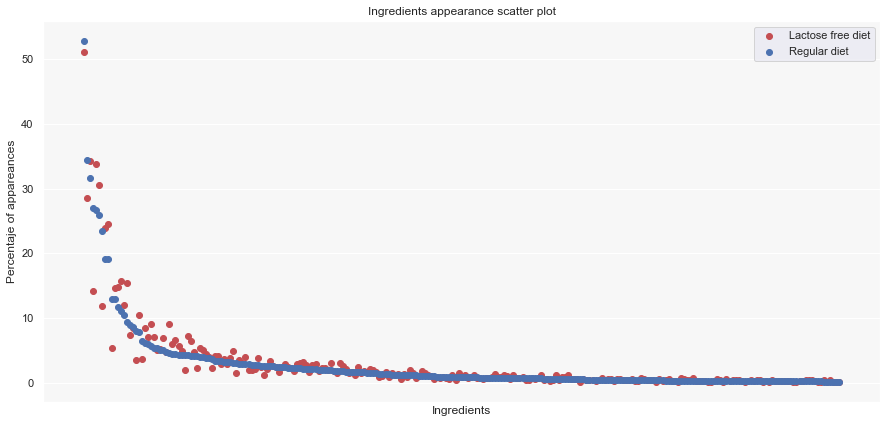

In [86]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.scatter(list(range(len(keys_lactoseFree))), ingredients_lactoseFree_per, color='r', label="Lactose free diet")
ax.scatter(list(range(len(keys_lactoseFree))), ingredients_lactoseFree_per_general, color='b', label="Regular diet")
ax.set_xlabel('Ingredients')
ax.set_ylabel('Percentaje of appareances')
ax.set_title('Ingredients appearance scatter plot')
ax.set_facecolor((0.97, 0.97, 0.97))
plt.legend(loc="upper right")
plt.xticks([])
plt.show()

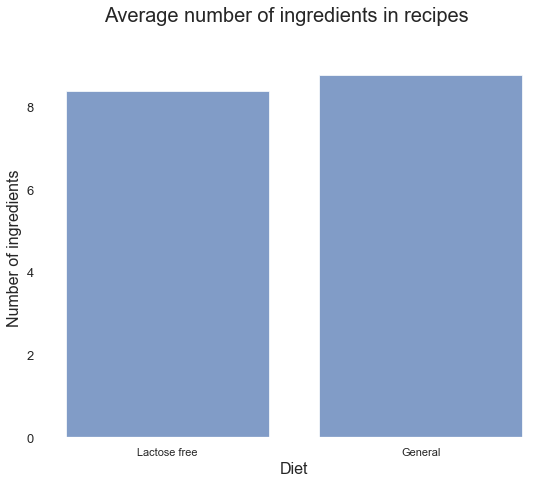

In [87]:
mean_lactoseFree = df_ingredients[df_ingredients["LactoseFree"] == 1]["length"].mean()
mean_general = df_ingredients["length"].mean()
_data = [mean_lactoseFree, mean_general]
_keys = ["Lactose free", "General"]
fig, ax = plt.subplots(figsize=(9, 7))
plt.bar(np.arange(2), _data,
       align='center',
       alpha=0.7,
       ecolor='black',
       capsize=10, 
       tick_label=_keys) 
fig.suptitle('Average number of ingredients in recipes', fontsize=20)
plt.ylabel('Number of ingredients', fontsize=16)
plt.xlabel('Diet', fontsize=16)
ax.set_facecolor('xkcd:white')
#ax.set_facecolor((1.0, 0.47, 0.42))
plt.xticks(fontsize=11)
plt.yticks(fontsize=13)
plt.show()


(Time: 0.12 seconds)


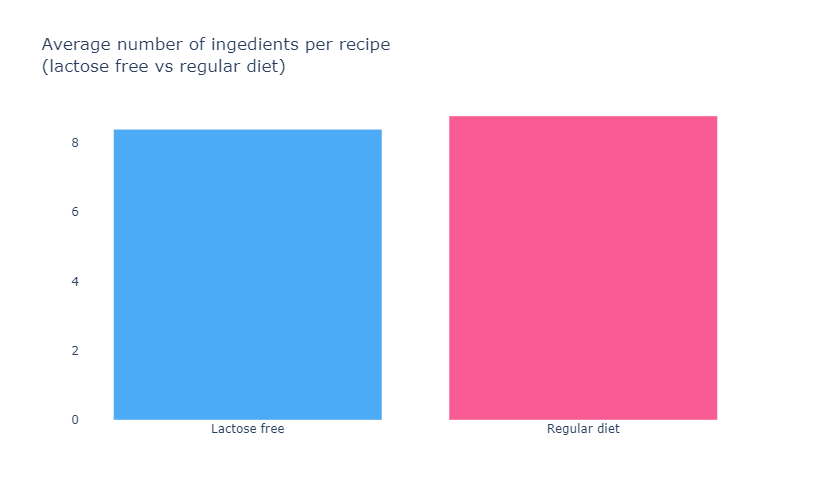

In [88]:
initial_time = time.time()
_keys_diets = ["Lactose free", "Regular diet"]
_hovers = []

_hovers.append("Lactose free diet has " + str(round(mean_lactoseFree, 2)) + " ingredients in average per diet.")
_hovers.append("Regular diet has " + str(round(mean_general, 2)) + " ingredients in average per diet.")

_hovers.append("Total number of recipes: " + str(total))
fig = go.Figure(data=[go.Bar(x=_keys_diets,
                             y=_data,
                             hovertext=_hovers,
                             hoverinfo="text",
                             marker_color=["#2196f3", "#f73378"]
                            )])
# Customize aspect
fig.update_traces(opacity=0.8)
fig.update_layout(
    title_text='Average number of ingedients per recipe <br>(lactose free vs regular diet)',
    width=500,
    height=500,
    plot_bgcolor='white'
)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
fig.show()

(Time: 0.28 seconds)


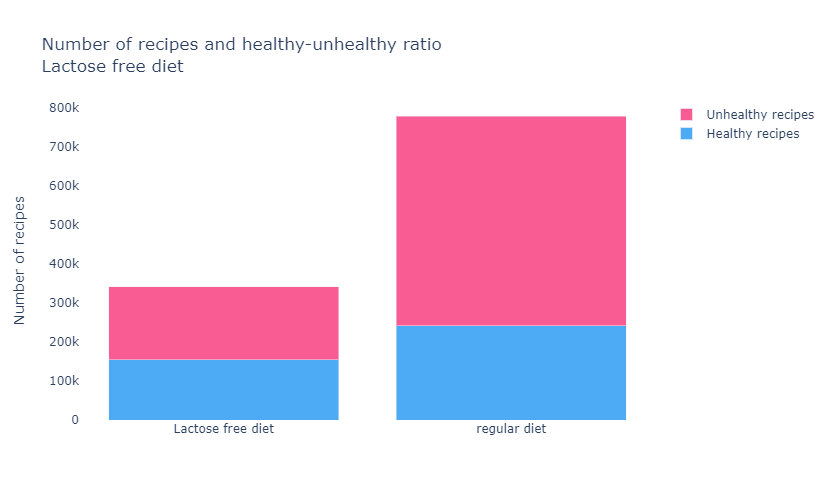

In [90]:
initial_time = time.time()
diets=['Lactose free diet', 'regular diet']
numberOfHealthyLactoseFreeRecipes = len(df_ingredients[(df_ingredients["LactoseFree"] == 1) & (df_ingredients["Unhealthy"] == 0)])
numberOfLactoseFreeRecipes = len(df_ingredients[df_ingredients["LactoseFree"] == 1])

numberOfHealthyRecipes = len(df_ingredients[df_ingredients["Unhealthy"] == 0])
numberOfRecipes = len(df_ingredients)

_hover_healthy1 = "Lactose free:<br><br>"
_hover_healthy1 += "Healthy recipes: " + str(numberOfHealthyLactoseFreeRecipes) + "<br>"
_hover_healthy1 += "Total recipes: " + str(numberOfLactoseFreeRecipes) + "<br>"
_hover_healthy1 += "Percentage of healthy recipes: " + str(round(numberOfHealthyLactoseFreeRecipes*100/numberOfLactoseFreeRecipes, 2)) + "%"

_hover_healthy2 = "No diet:<br><br>"
_hover_healthy2 += "Healthy recipes: " + str(numberOfHealthyRecipes) + "<br>"
_hover_healthy2 += "Total recipes: " + str(numberOfRecipes) + "<br>"
_hover_healthy2 += "Percentage of unhealthy recipes: " + str(round(numberOfHealthyRecipes*100/numberOfRecipes, 2)) + "%"

_hover_unhealthy1 = "Lactose free:<br><br>"
_hover_unhealthy1 += "Unhealthy recipes: " + str(numberOfLactoseFreeRecipes - numberOfHealthyLactoseFreeRecipes) + "<br>"
_hover_unhealthy1 += "Total recipes: " + str(numberOfLactoseFreeRecipes) + "<br>"
_hover_unhealthy1 += "Percentage of healthy recipes: " + str(round((numberOfLactoseFreeRecipes - numberOfHealthyLactoseFreeRecipes)*100/numberOfLactoseFreeRecipes, 2)) + "%"

_hover_unhealthy2 = "No diet:<br><br>"
_hover_unhealthy2 += "Unhealthy recipes: " + str(numberOfHealthyRecipes) + "<br>"
_hover_unhealthy2 += "Total recipes: " + str(numberOfRecipes) + "<br>"
_hover_unhealthy2 += "Percentage of unhealthy recipes: " + str(round((numberOfRecipes - numberOfHealthyRecipes)*100/numberOfRecipes, 2)) + "%"

fig = go.Figure(data=[
    go.Bar(
        name='Healthy recipes',
        x=diets,
        y=[numberOfHealthyLactoseFreeRecipes, numberOfHealthyRecipes],
        hovertext=[_hover_healthy1, _hover_healthy2],
        hoverinfo="text",
        marker=dict(color='#2196f3')
        
    ),
    go.Bar(
        name='Unhealthy recipes',
        x=diets,
        y=[numberOfLactoseFreeRecipes - numberOfHealthyLactoseFreeRecipes, numberOfRecipes - numberOfHealthyRecipes],
        hovertext=[_hover_unhealthy1, _hover_unhealthy2],
        hoverinfo="text",
        marker=dict(color='#f73378')
        
    )
])
fig.update_traces(opacity=0.8)
# Change the bar mode
fig.update_layout(
    title_text='Number of recipes and healthy-unhealthy ratio<br>Lactose free diet',
    barmode='stack',
    width=500,
    height=500,
    plot_bgcolor="white",
)
fig.update_yaxes(title_text='Number of recipes')
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
fig.show()

## Gluten free

In [92]:
df_glutenFree = df_ingredients[df_ingredients["GlutenFree"] == 1]
df_glutenFree.head()

id                                        ingredients  LactoseFree  \
1  000033e39b  [celery, pasta, dill, salt, bell pepper, mayon...            0   
2  000035f7ed  [tomatoes, onion, cucumber, salt, olive oil, b...            1   
3  00003a70b1  [butter, corn, water, french - fried onions, m...            0   
5  0000631d90  [pepper, soy sauce, lemon, garlic, salt, cashe...            1   
6  000075604a                             [tea, chicken, pepper]            1   

   GlutenFree  Vegan  Vegetarian  IronRich  Omega3Rich  MagnesiumRich  Spicy  \
1           1      0           1         0           0              0      0   
2           1      1           1         0           0              0      0   
3           1      0           1         1           0              0      0   
5           1      0           0         1           0              0      0   
6           1      0           0         0           0              0      0   

   Unhealthy  length  
1          1       9  
2          0       7  
3          1       7  
5          0      11  
6          0       3

In [93]:
# Getting the lactoseFree ingredients
ingredients_glutenFree = df_common_ing[df_common_ing["GlutenFree"] == 1].index.tolist()
printMain("Ingredients abailable for gluten intolerance people: " + str(len(ingredients_glutenFree)))

Ingredients abailable for gluten intolerance people: 256


In [94]:
# First, we recalculate the dictionary of ingredients
initial_time = time.time()
dic_ingredients_glutenFree = {}
 
for row in df_glutenFree.itertuples():
    for ing in row[2]:
        if ing in ingredients_glutenFree:
            if ing in dic_ingredients_glutenFree:
                dic_ingredients_glutenFree[ing] += 1
            else:
                dic_ingredients_glutenFree[ing] = 1

print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of different ingredients: " + str(len(dic_ingredients_glutenFree)))

(Time: 6.57 seconds)
Number of different ingredients: 256


In [95]:
len(df_ingredients)

779088

In [96]:
len(df_glutenFree)

545587

In [97]:
initial_time = time.time()
dic_ingredients_glutenFree_per = {}
ingredients_glutenFree_per = []
ingredients_glutenFree_per_general = []
keys_glutenFree = []

for key in ingredients_glutenFree:
    
    ingredients_glutenFree_per_general.append(dic_ingredients_per[key])
    keys_glutenFree.append(key)
    if key in dic_ingredients_glutenFree:
        ingredients_glutenFree_per.append((dic_ingredients_glutenFree[key]/len(df_glutenFree))*100)
        dic_ingredients_glutenFree_per[key] = (dic_ingredients_glutenFree[key]/len(df_glutenFree))*100
    else: 
        ingredients_glutenFree_per.append(0)
        dic_ingredients_glutenFree_per[key] = 0
print("(Time:", round(time.time() - initial_time, 2), "seconds)")

(Time: 0.0 seconds)


In [98]:
dic_more_per_glutenFree = {}
dic_less_per_glutenFree = {}
dic_double_glutenFree = {}
dic_half_glutenFree = {}
mean_change_glutenFree = 0
absolute_change_glutenFree = 0
dic_changes_glutenFree = {}
mean_total = 0
initial_time = time.time()

for key in dic_ingredients_glutenFree_per:
    change = dic_ingredients_glutenFree_per[key] - dic_ingredients_per[key]
    dic_changes_glutenFree[key] = change
    mean_change_glutenFree += change
    absolute_change_glutenFree += abs(change)
    mean_total += dic_ingredients_per[key]
    if dic_ingredients_glutenFree_per[key] - 2 > dic_ingredients_per[key]:
        dic_more_per_glutenFree[key] = [dic_ingredients_per[key], dic_ingredients_glutenFree_per[key]]
    elif dic_ingredients_glutenFree_per[key] + 2 < dic_ingredients_per[key]:
        dic_less_per_glutenFree[key] = [dic_ingredients_per[key], dic_ingredients_glutenFree_per[key]]
        
    if dic_ingredients_glutenFree_per[key] > 2*dic_ingredients_per[key]:
        dic_double_glutenFree[key] = [dic_ingredients_per[key], dic_ingredients_glutenFree_per[key]]
    elif dic_ingredients_glutenFree_per[key]*2 < dic_ingredients_per[key]:
        dic_half_glutenFree[key] = [dic_ingredients_per[key], dic_ingredients_glutenFree_per[key]]

mean_change_glutenFree = mean_change_glutenFree/len(dic_ingredients_glutenFree_per)
absolute_change_glutenFree = absolute_change_glutenFree/len(dic_ingredients_glutenFree_per)
mean_total = mean_total/len(dic_ingredients_glutenFree_per)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")

printMain("Ingredients increasing more than 2%:")
print(dic_more_per_glutenFree)
print()
printMain("Ingredients decreasing more than 2%:")
print(dic_less_per_glutenFree)
print()
printMain("Ingredients multipling by 2 their percentage of appearances:")
print(dic_double_glutenFree)
print()
printMain("Ingredients dividing by 2 their percentage of appearances:")
print(dic_half_glutenFree)

(Time: 0.0 seconds)
Ingredients increasing more than 2%:
{'pepper': [31.675754215184938, 34.91083915122611], 'garlic': [26.720986589448177, 31.369149191604638], 'onion': [25.87653769535662, 29.129909620280543], 'olive oil': [19.051121311071405, 22.155403262907658], 'tomatoes': [11.635142628303862, 13.854435681202082], 'vinegar': [9.335659129649025, 11.659918583104071]}

Ingredients decreasing more than 2%:
{'salt': [52.792239130881235, 46.03702067681231], 'sugar': [34.45451604953484, 25.671066209422143], 'butter': [29.072839011767606, 19.233412819586977], 'egg': [26.97975068284969, 14.206533513445152], 'milk': [14.144871952847431, 8.816192467929037], 'vanilla': [12.97517096913314, 6.927950995899828], 'cinnamon': [8.955085946645308, 5.940757386081414], 'baking soda': [6.496313638510669, 0.6501254612005052]}

Ingredients multipling by 2 their percentage of appearances:
{}

Ingredients dividing by 2 their percentage of appearances:
{'baking soda': [6.496313638510669, 0.6501254612005052], 

In [99]:
printMain("Mean change: " + str(mean_change_glutenFree))
printMain("Mean change in absolute value: " + str(absolute_change_glutenFree))
printMain("Mean total: " + str(mean_total))
printMain("Percentual mean change: " + str(absolute_change_glutenFree*100/mean_total))

Mean change: -0.08742822679937691
Mean change in absolute value: 0.5520097249449218
Mean total: 2.843282385943566
Percentual mean change: 19.41452342806017


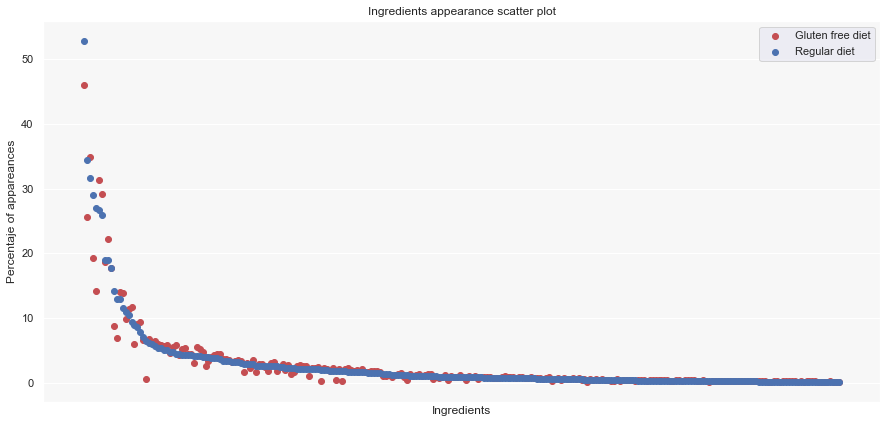

In [100]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.scatter(list(range(len(keys_glutenFree))), ingredients_glutenFree_per, color='r', label="Gluten free diet")
ax.scatter(list(range(len(keys_glutenFree))), ingredients_glutenFree_per_general, color='b', label="Regular diet")
ax.set_xlabel('Ingredients')
ax.set_ylabel('Percentaje of appareances')
ax.set_title('Ingredients appearance scatter plot')
ax.set_facecolor((0.97, 0.97, 0.97))
plt.legend(loc="upper right")
plt.xticks([])
plt.show()

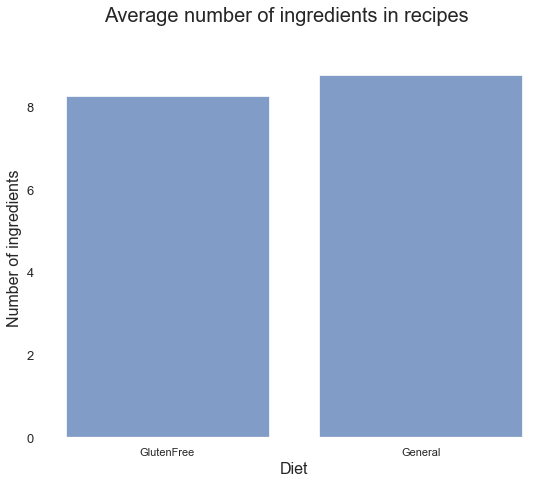

In [101]:
mean_glutenFree = df_ingredients[df_ingredients["GlutenFree"] == 1]["length"].mean()
mean_general = df_ingredients["length"].mean()
_data = [mean_glutenFree, mean_general]
_keys = ["GlutenFree", "General"]
fig, ax = plt.subplots(figsize=(9, 7))
plt.bar(np.arange(2), _data,
       align='center',
       alpha=0.7,
       ecolor='black',
       capsize=10, 
       tick_label=_keys) 
fig.suptitle('Average number of ingredients in recipes', fontsize=20)
plt.ylabel('Number of ingredients', fontsize=16)
plt.xlabel('Diet', fontsize=16)
ax.set_facecolor('xkcd:white')
#ax.set_facecolor((1.0, 0.47, 0.42))
plt.xticks(fontsize=11)
plt.yticks(fontsize=13)
plt.show()


(Time: 0.15 seconds)


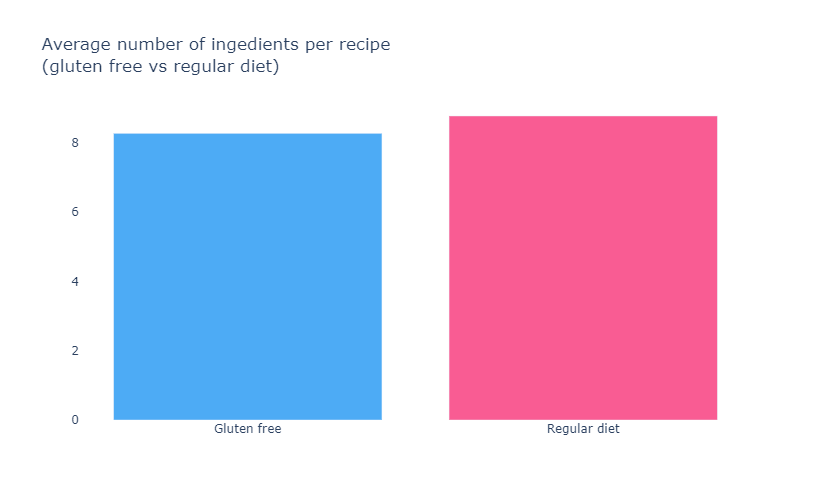

In [102]:
initial_time = time.time()
_keys_diets = ["Gluten free", "Regular diet"]
_hovers = []

_hovers.append("Gluten free diet has " + str(round(mean_glutenFree, 2)) + " ingredients in average per diet.")
_hovers.append("Regular diet has " + str(round(mean_general, 2)) + " ingredients in average per diet.")

_hovers.append("Total number of recipes: " + str(total))
fig = go.Figure(data=[go.Bar(x=_keys_diets,
                             y=_data,
                             hovertext=_hovers,
                             hoverinfo="text",
                             marker_color=["#2196f3", "#f73378"]
                            )])
# Customize aspect
fig.update_traces(opacity=0.8)
fig.update_layout(
    title_text='Average number of ingedients per recipe <br>(gluten free vs regular diet)',
    width=500,
    height=500,
    plot_bgcolor='white'
)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
fig.show()

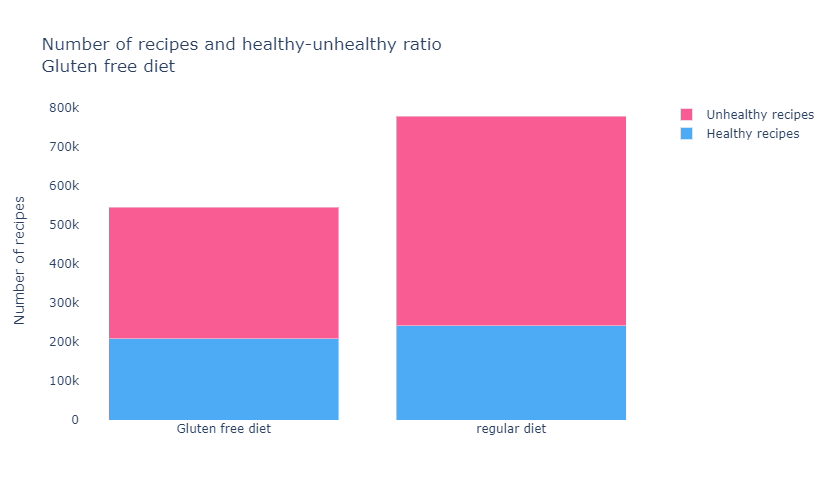

In [104]:
import plotly.graph_objects as go
diets=['Gluten free diet', 'regular diet']
numberOfHealthyGlutenFreeRecipes = len(df_ingredients[(df_ingredients["GlutenFree"] == 1) & (df_ingredients["Unhealthy"] == 0)])
numberOfGlutenFreeRecipes = len(df_ingredients[df_ingredients["GlutenFree"] == 1])

numberOfHealthyRecipes = len(df_ingredients[df_ingredients["Unhealthy"] == 0])
numberOfRecipes = len(df_ingredients)

_hover_healthy1 = "Gluten free:<br><br>"
_hover_healthy1 += "Healthy recipes: " + str(numberOfHealthyGlutenFreeRecipes) + "<br>"
_hover_healthy1 += "Total recipes: " + str(numberOfGlutenFreeRecipes) + "<br>"
_hover_healthy1 += "Percentage of healthy recipes: " + str(round(numberOfHealthyGlutenFreeRecipes*100/numberOfGlutenFreeRecipes, 2)) + "%"

_hover_healthy2 = "No diet:<br><br>"
_hover_healthy2 += "Healthy recipes: " + str(numberOfHealthyRecipes) + "<br>"
_hover_healthy2 += "Total recipes: " + str(numberOfRecipes) + "<br>"
_hover_healthy2 += "Percentage of unhealthy recipes: " + str(round(numberOfHealthyRecipes*100/numberOfRecipes, 2)) + "%"

_hover_unhealthy1 = "Gluten free:<br><br>"
_hover_unhealthy1 += "Unhealthy recipes: " + str(numberOfGlutenFreeRecipes - numberOfHealthyGlutenFreeRecipes) + "<br>"
_hover_unhealthy1 += "Total recipes: " + str(numberOfGlutenFreeRecipes) + "<br>"
_hover_unhealthy1 += "Percentage of healthy recipes: " + str(round((numberOfGlutenFreeRecipes - numberOfHealthyGlutenFreeRecipes)*100/numberOfGlutenFreeRecipes, 2)) + "%"

_hover_unhealthy2 = "No diet:<br><br>"
_hover_unhealthy2 += "Unhealthy recipes: " + str(numberOfHealthyRecipes) + "<br>"
_hover_unhealthy2 += "Total recipes: " + str(numberOfRecipes) + "<br>"
_hover_unhealthy2 += "Percentage of unhealthy recipes: " + str(round((numberOfRecipes - numberOfHealthyRecipes)*100/numberOfRecipes, 2)) + "%"

fig = go.Figure(data=[
    go.Bar(
        name='Healthy recipes',
        x=diets,
        y=[numberOfHealthyGlutenFreeRecipes, numberOfHealthyRecipes],
        hovertext=[_hover_healthy1, _hover_healthy2],
        hoverinfo="text",
        marker_color= '#2196f3'
    ),
    go.Bar(
        name='Unhealthy recipes',
        x=diets,
        y=[numberOfGlutenFreeRecipes - numberOfHealthyGlutenFreeRecipes, numberOfRecipes - numberOfHealthyRecipes],
        hovertext=[_hover_unhealthy1, _hover_unhealthy2],
        hoverinfo="text",
        marker_color= '#f73378'
    )
])
fig.update_traces(opacity=0.8)
# Change the bar mode
fig.update_layout(
    title_text='Number of recipes and healthy-unhealthy ratio<br>Gluten free diet',
    barmode='stack',
    width=500,
    height=500,
    plot_bgcolor="white",
)
fig.update_yaxes(title_text='Number of recipes')
fig.show()

## Vegan

In [106]:
df_vegan = df_ingredients[df_ingredients["Vegan"] == 1]
df_vegan.head()

id                                        ingredients  \
2   000035f7ed  [tomatoes, onion, cucumber, salt, olive oil, b...   
12  0000c79afb  [wine, orange liqueur, water, lemon, brandy, o...   
14  00010379bf  [soy sauce, water, vegetable oil, sugar, bakin...   
31  0001cba765  [triple sec, orange, tequila, orange wedges, c...   
36  0002491373  [pepper, vegetable oil, cilantro, onion, garli...   

    LactoseFree  GlutenFree  Vegan  Vegetarian  IronRich  Omega3Rich  \
2             1           1      1           1         0           0   
12            1           1      1           1         0           0   
14            1           0      1           1         1           0   
31            1           1      1           1         0           0   
36            1           1      1           1         1           0   

    MagnesiumRich  Spicy  Unhealthy  length  
2               0      0          0       7  
12              0      0          1       8  
14              1      0          1       7  
31              0      0          1       6  
36              0      1          1      14

In [107]:
# Getting the lactoseFree ingredients
ingredients_vegan = df_common_ing[df_common_ing["Vegan"] == 1].index.tolist()
printMain("Ingredients abailable for gluten intolerance people: " + str(len(ingredients_vegan)))

Ingredients abailable for gluten intolerance people: 224


In [108]:
# First, we recalculate the dictionary of ingredients
initial_time = time.time()
dic_ingredients_vegan = {}
 
for row in df_vegan.itertuples():
    for ing in row[2]:
        if ing in ingredients_vegan:
            if ing in dic_ingredients_vegan:
                dic_ingredients_vegan[ing] += 1
            else:
                dic_ingredients_vegan[ing] = 1

print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of different ingredients: " + str(len(dic_ingredients_vegan)))

(Time: 1.65 seconds)
Number of different ingredients: 224


In [109]:
len(df_ingredients)

779088

In [110]:
len(df_glutenFree)

545587

In [111]:
dic_ingredients_vegan_per = {}
ingredients_vegan_per = []
ingredients_vegan_per_general = []
keys_vegan = []

for key in ingredients_vegan:
    
    ingredients_vegan_per_general.append(dic_ingredients_per[key])
    keys_vegan.append(key)
    if key in dic_ingredients_vegan:
        ingredients_vegan_per.append((dic_ingredients_vegan[key]/len(df_vegan))*100)
        dic_ingredients_vegan_per[key] = (dic_ingredients_vegan[key]/len(df_vegan))*100
    else: 
        ingredients_vegan_per.append(0)
        dic_ingredients_vegan_per[key] = 0

In [112]:
dic_more_per_vegan = {}
dic_less_per_vegan = {}
dic_double_vegan = {}
dic_half_vegan = {}
mean_change_vegan = 0
absolute_change_vegan = 0
dic_changes_vegan = {}
mean_total = 0
initial_time = time.time()

for key in dic_ingredients_vegan_per:
    change = dic_ingredients_vegan_per[key] - dic_ingredients_per[key]
    dic_changes_vegan[key] = change
    mean_change_vegan += change
    absolute_change_vegan += abs(change)
    mean_total += dic_ingredients_per[key]
    if dic_ingredients_vegan_per[key] - 2 > dic_ingredients_per[key]:
        dic_more_per_vegan[key] = [dic_ingredients_per[key], dic_ingredients_vegan_per[key]]
    elif dic_ingredients_vegan_per[key] + 2 < dic_ingredients_per[key]:
        dic_less_per_vegan[key] = [dic_ingredients_per[key], dic_ingredients_vegan_per[key]]
        
    if dic_ingredients_vegan_per[key] > 2*dic_ingredients_per[key]:
        dic_double_vegan[key] = [dic_ingredients_per[key], dic_ingredients_vegan_per[key]]
    elif dic_ingredients_vegan_per[key]*2 < dic_ingredients_per[key]:
        dic_half_vegan[key] = [dic_ingredients_per[key], dic_ingredients_vegan_per[key]]

mean_change_vegan = mean_change_vegan/len(dic_ingredients_vegan_per)
absolute_change_vegan = absolute_change_vegan/len(dic_ingredients_vegan_per)
mean_total = mean_total/len(dic_ingredients_vegan_per)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")

printMain("Ingredients increasing more than 2%:")
print(dic_more_per_vegan)
print()
printMain("Ingredients decreasing more than 2%:")
print(dic_less_per_vegan)
print()
printMain("Ingredients multipling by 2 their percentage of appearances:")
print(dic_double_vegan)
print()
printMain("Ingredients dividing by 2 their percentage of appearances:")
print(dic_half_vegan)

(Time: 0.0 seconds)
Ingredients increasing more than 2%:
{'water': [19.055870453658635, 27.82002534854246], 'olive oil': [19.051121311071405, 23.757072112683417], 'lemon': [12.936279341999876, 15.21892516953471], 'vinegar': [9.335659129649025, 16.10873740739289], 'ginger': [5.686007228965149, 7.85020840683104], 'cumin': [4.371264863532746, 6.494584035644754], 'lime': [4.225838416199454, 9.062757241974051], 'cilantro': [4.08914012281026, 6.8754654854768535], 'orange': [3.9057205347791264, 6.435132557197548]}

Ingredients decreasing more than 2%:
{'salt': [52.792239130881235, 44.87475990749088], 'sugar': [34.45451604953484, 31.462898357571245], 'pepper': [31.675754215184938, 25.42302013510512], 'onion': [25.87653769535662, 23.340258450603006], 'flour': [23.47064773170682, 7.619588935491879], 'vanilla': [12.97517096913314, 4.792050488024774], 'baking powder': [7.974452179984803, 2.0102439470555185], 'baking soda': [6.496313638510669, 1.942299400258712], 'chocolate': [4.234438214938492, 2.

In [113]:
printMain("Mean change: " + str(mean_change_vegan))
printMain("Mean change in absolute value: " + str(absolute_change_vegan))
printMain("Mean total: " + str(mean_total))
printMain("Percentual mean change: " + str(absolute_change_vegan*100/mean_total))

Mean change: -0.06544073336245676
Mean change in absolute value: 0.8069343207438727
Mean total: 2.664176736132503
Percentual mean change: 30.288317955785192


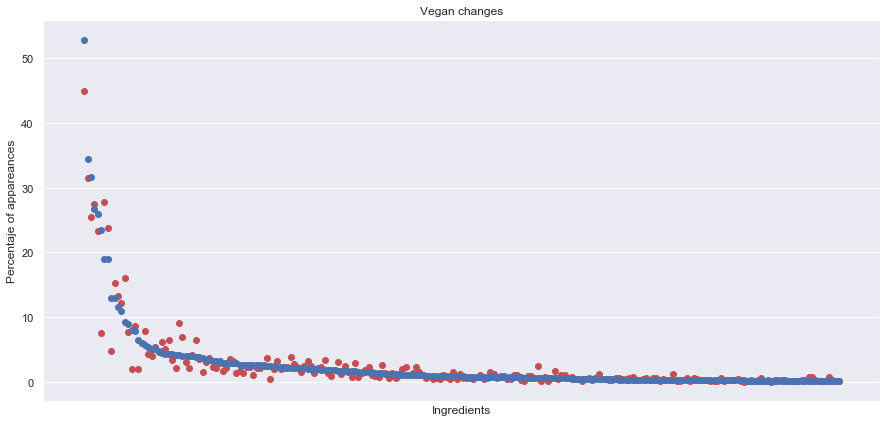

In [114]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.scatter(list(range(len(ingredients_vegan_per))), ingredients_vegan_per, color='r')
ax.scatter(list(range(len(ingredients_vegan_per))), ingredients_vegan_per_general, color='b')
ax.set_xlabel('Ingredients')
ax.set_ylabel('Percentaje of appareances')
ax.set_title('Vegan changes')
plt.xticks([])
plt.show()

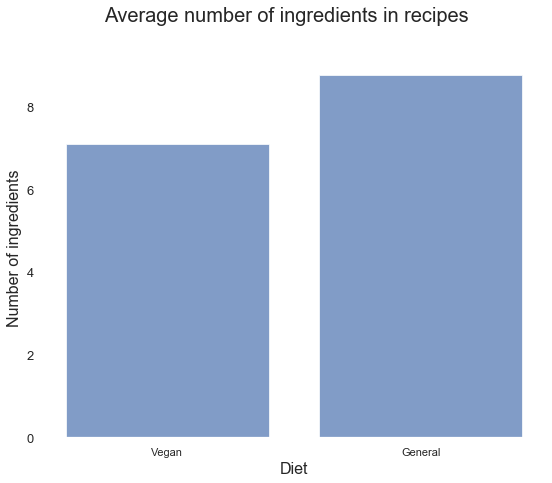

In [115]:
mean_vegan = df_ingredients[df_ingredients["Vegan"] == 1]["length"].mean()
mean_general = df_ingredients["length"].mean()
_data = [mean_vegan, mean_general]
_keys = ["Vegan", "General"]
fig, ax = plt.subplots(figsize=(9, 7))
plt.bar(np.arange(2), _data,
       align='center',
       alpha=0.7,
       ecolor='black',
       capsize=10, 
       tick_label=_keys) 
fig.suptitle('Average number of ingredients in recipes', fontsize=20)
plt.ylabel('Number of ingredients', fontsize=16)
plt.xlabel('Diet', fontsize=16)
ax.set_facecolor('xkcd:white')
#ax.set_facecolor((1.0, 0.47, 0.42))
plt.xticks(fontsize=11)
plt.yticks(fontsize=13)
plt.show()


(Time: 0.13 seconds)


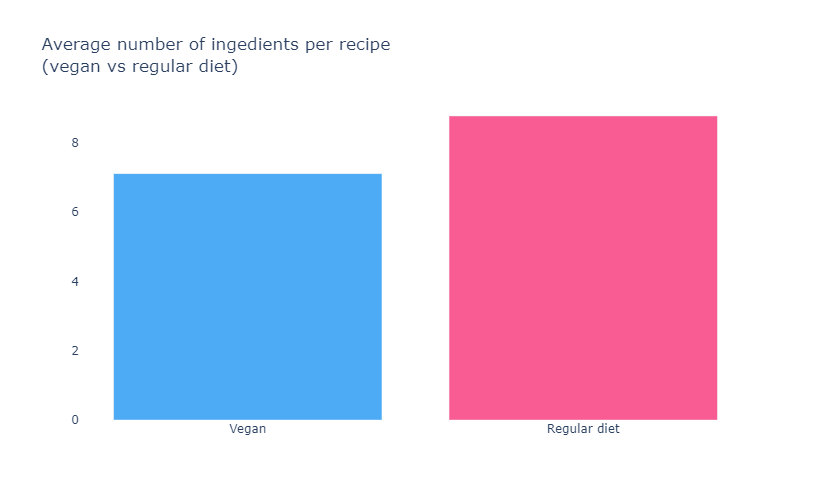

In [116]:
initial_time = time.time()
_keys_diets = ["Vegan", "Regular diet"]
_hovers = []

_hovers.append("Vegan diet has " + str(round(mean_vegan, 2)) + " ingredients in average per diet.")
_hovers.append("Regular diet has " + str(round(mean_general, 2)) + " ingredients in average per diet.")

_hovers.append("Total number of recipes: " + str(total))
fig = go.Figure(data=[go.Bar(x=_keys_diets,
                             y=_data,
                             hovertext=_hovers,
                             hoverinfo="text",
                             marker_color=["#2196f3", "#f73378"]
                            )])
# Customize aspect
fig.update_traces(opacity=0.8)
fig.update_layout(
    title_text='Average number of ingedients per recipe <br>(vegan vs regular diet)',
    width=500,
    height=500,
    plot_bgcolor='white'
)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
fig.show()

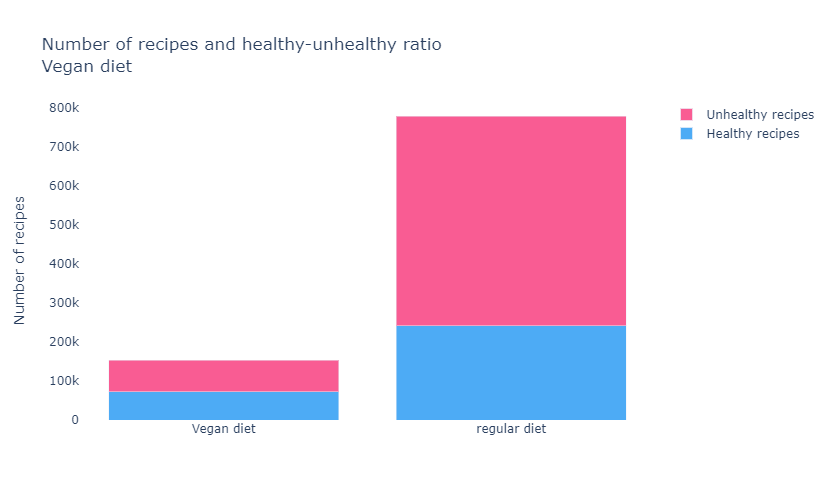

In [118]:
import plotly.graph_objects as go
diets=['Vegan diet', 'regular diet']
numberOfHealthyVeganRecipes = len(df_ingredients[(df_ingredients["Vegan"] == 1) & (df_ingredients["Unhealthy"] == 0)])
numberOfVeganRecipes = len(df_ingredients[df_ingredients["Vegan"] == 1])

numberOfHealthyRecipes = len(df_ingredients[df_ingredients["Unhealthy"] == 0])
numberOfRecipes = len(df_ingredients)

_hover_healthy1 = "Vegan:<br><br>"
_hover_healthy1 += "Healthy recipes: " + str(numberOfHealthyVeganRecipes) + "<br>"
_hover_healthy1 += "Total recipes: " + str(numberOfVeganRecipes) + "<br>"
_hover_healthy1 += "Percentage of healthy recipes: " + str(round(numberOfHealthyVeganRecipes*100/numberOfVeganRecipes, 2)) + "%"

_hover_healthy2 = "No diet:<br><br>"
_hover_healthy2 += "Healthy recipes: " + str(numberOfHealthyRecipes) + "<br>"
_hover_healthy2 += "Total recipes: " + str(numberOfRecipes) + "<br>"
_hover_healthy2 += "Percentage of unhealthy recipes: " + str(round(numberOfHealthyRecipes*100/numberOfRecipes, 2)) + "%"

_hover_unhealthy1 = "Vegan:<br><br>"
_hover_unhealthy1 += "Unhealthy recipes: " + str(numberOfVeganRecipes - numberOfHealthyVeganRecipes) + "<br>"
_hover_unhealthy1 += "Total recipes: " + str(numberOfVeganRecipes) + "<br>"
_hover_unhealthy1 += "Percentage of healthy recipes: " + str(round((numberOfVeganRecipes - numberOfHealthyVeganRecipes)*100/numberOfVeganRecipes, 2)) + "%"

_hover_unhealthy2 = "No diet:<br><br>"
_hover_unhealthy2 += "Unhealthy recipes: " + str(numberOfHealthyRecipes) + "<br>"
_hover_unhealthy2 += "Total recipes: " + str(numberOfRecipes) + "<br>"
_hover_unhealthy2 += "Percentage of unhealthy recipes: " + str(round((numberOfRecipes - numberOfHealthyRecipes)*100/numberOfRecipes, 2)) + "%"

fig = go.Figure(data=[
    go.Bar(
        name='Healthy recipes',
        x=diets,
        y=[numberOfHealthyVeganRecipes, numberOfHealthyRecipes],
        hovertext=[_hover_healthy1, _hover_healthy2],
        hoverinfo="text",
        marker_color= '#2196f3'
    ),
    go.Bar(
        name='Unhealthy recipes',
        x=diets,
        y=[numberOfVeganRecipes - numberOfHealthyVeganRecipes, numberOfRecipes - numberOfHealthyRecipes],
        hovertext=[_hover_unhealthy1, _hover_unhealthy2],
        hoverinfo="text",
        marker_color= '#f73378'
    )
])
fig.update_traces(opacity=0.8)
# Change the bar mode
fig.update_layout(
    title_text='Number of recipes and healthy-unhealthy ratio<br>Vegan diet',
    barmode='stack',
    width=500,
    height=500,
    plot_bgcolor="white",
)
fig.update_yaxes(title_text='Number of recipes')

fig.show()

## Vegetarian

In [120]:
df_vegetarian = df_ingredients[df_ingredients["Vegetarian"] == 1]
df_vegetarian.head()

id                                        ingredients  LactoseFree  \
1  000033e39b  [celery, pasta, dill, salt, bell pepper, mayon...            0   
2  000035f7ed  [tomatoes, onion, cucumber, salt, olive oil, b...            1   
3  00003a70b1  [butter, corn, water, french - fried onions, m...            0   
7  00007bfd16  [butter, water, gelatin, sugar, rhubarb, white...            0   
8  000095fc1d          [yogurt, low - fat granola, strawberries]            0   

   GlutenFree  Vegan  Vegetarian  IronRich  Omega3Rich  MagnesiumRich  Spicy  \
1           1      0           1         0           0              0      0   
2           1      1           1         0           0              0      0   
3           1      0           1         1           0              0      0   
7           1      0           1         0           0              0      0   
8           1      0           1         0           0              0      0   

   Unhealthy  length  
1          1       9  
2          0       7  
3          1       7  
7          1       6  
8          0       3

In [121]:
# Getting the lactoseFree ingredients
ingredients_vegetarian = df_common_ing[df_common_ing["Vegetarian"] == 1].index.tolist()
printMain("Ingredients abailable for gluten intolerance people: " + str(len(ingredients_vegetarian)))

Ingredients abailable for gluten intolerance people: 244


In [122]:
# First, we recalculate the dictionary of ingredients
initial_time = time.time()
dic_ingredients_vegetarian = {}
 
for row in df_vegetarian.itertuples():
    for ing in row[2]:
        if ing in ingredients_vegetarian:
            if ing in dic_ingredients_vegetarian:
                dic_ingredients_vegetarian[ing] += 1
            else:
                dic_ingredients_vegetarian[ing] = 1

print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of different ingredients: " + str(len(dic_ingredients_vegetarian)))

(Time: 5.6 seconds)
Number of different ingredients: 244


In [123]:
len(df_ingredients)

779088

In [124]:
len(df_glutenFree)

545587

In [125]:
dic_ingredients_vegetarian_per = {}
ingredients_vegetarian_per = []
ingredients_vegetarian_per_general = []
keys_vegetarian = []

for key in ingredients_vegetarian:
    
    ingredients_vegetarian_per_general.append(dic_ingredients_per[key])
    keys_vegetarian.append(key)
    if key in dic_ingredients_vegetarian:
        ingredients_vegetarian_per.append((dic_ingredients_vegetarian[key]/len(df_vegetarian))*100)
        dic_ingredients_vegetarian_per[key] = (dic_ingredients_vegetarian[key]/len(df_vegetarian))*100
    else: 
        ingredients_vegetarian_per.append(0)
        dic_ingredients_vegetarian_per[key] = 0

In [126]:
dic_more_per_vegetarian = {}
dic_less_per_vegetarian = {}
dic_double_vegetarian = {}
dic_half_vegetarian = {}
mean_change_vegetarian = 0
absolute_change_vegetarian = 0
dic_changes_vegetarian = {}
mean_total = 0
initial_time = time.time()

for key in dic_ingredients_vegetarian_per:
    change = dic_ingredients_vegetarian_per[key] - dic_ingredients_per[key]
    dic_changes_vegetarian[key] = change
    mean_change_vegetarian += change
    absolute_change_vegetarian += abs(change)
    mean_total += dic_ingredients_per[key]
    if dic_ingredients_vegetarian_per[key] - 2 > dic_ingredients_per[key]:
        dic_more_per_vegetarian[key] = [dic_ingredients_per[key], dic_ingredients_vegetarian_per[key]]
    elif dic_ingredients_vegetarian_per[key] + 2 < dic_ingredients_per[key]:
        dic_less_per_vegetarian[key] = [dic_ingredients_per[key], dic_ingredients_vegetarian_per[key]]
        
    if dic_ingredients_vegetarian_per[key] > 2*dic_ingredients_per[key]:
        dic_double_vegetarian[key] = [dic_ingredients_per[key], dic_ingredients_vegetarian_per[key]]
    elif dic_ingredients_vegetarian_per[key]*2 < dic_ingredients_per[key]:
        dic_half_vegetarian[key] = [dic_ingredients_per[key], dic_ingredients_vegetarian_per[key]]

mean_change_vegetarian = mean_change_vegetarian/len(dic_ingredients_vegetarian_per)
absolute_change_vegetarian = absolute_change_vegetarian/len(dic_ingredients_vegetarian_per)
mean_total = mean_total/len(dic_ingredients_vegetarian_per)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")

printMain("Ingredients increasing more than 2%:")
print(dic_more_per_vegetarian)
print()
printMain("Ingredients decreasing more than 2%:")
print(dic_less_per_vegetarian)
print()
printMain("Ingredients multipling by 2 their percentage of appearances:")
print(dic_double_vegetarian)
print()
printMain("Ingredients dividing by 2 their percentage of appearances:")
print(dic_half_vegetarian)

(Time: 0.0 seconds)
Ingredients increasing more than 2%:
{'sugar': [34.45451604953484, 46.49957899062499], 'butter': [29.072839011767606, 32.72874506975864], 'egg': [26.97975068284969, 33.448086925342345], 'flour': [23.47064773170682, 29.121762357330194], 'milk': [14.144871952847431, 16.908461684118077], 'vanilla': [12.97517096913314, 20.276335244326447], 'cinnamon': [8.955085946645308, 12.613561739312606], 'baking powder': [7.974452179984803, 11.922220028765617], 'baking soda': [6.496313638510669, 9.965634354365001], 'chocolate': [4.234438214938492, 6.610048627590014]}

Ingredients decreasing more than 2%:
{'salt': [52.792239130881235, 49.618674283780464], 'pepper': [31.675754215184938, 20.045485127692746], 'garlic': [26.720986589448177, 16.588373695173097], 'onion': [25.87653769535662, 14.840479749247622], 'olive oil': [19.051121311071405, 14.15236107697824], 'cheese': [17.739074404945267, 12.938887165458699], 'tomatoes': [11.635142628303862, 7.653507269965715], 'bell pepper': [7.893

In [127]:
printMain("Mean change: " + str(mean_change_vegetarian))
printMain("Mean change in absolute value: " + str(absolute_change_vegetarian))
printMain("Mean total: " + str(mean_total))
printMain("Percentual mean change: " + str(absolute_change_vegetarian*100/mean_total))

Mean change: -0.12684509776406724
Mean change in absolute value: 0.8348566558539281
Mean total: 2.945512605238644
Percentual mean change: 28.343340115710976


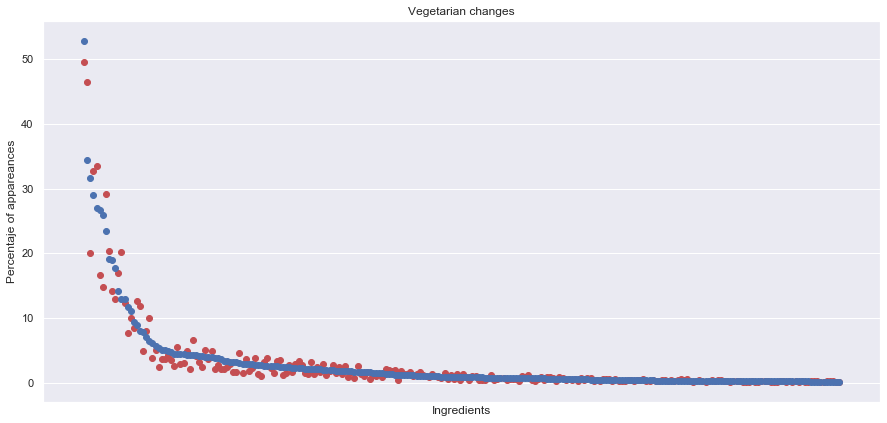

In [128]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.scatter(list(range(len(ingredients_vegetarian_per))), ingredients_vegetarian_per, color='r')
ax.scatter(list(range(len(ingredients_vegetarian_per))), ingredients_vegetarian_per_general, color='b')
ax.set_xlabel('Ingredients')
ax.set_ylabel('Percentaje of appareances')
ax.set_title('Vegetarian changes')
plt.xticks([])
plt.show()

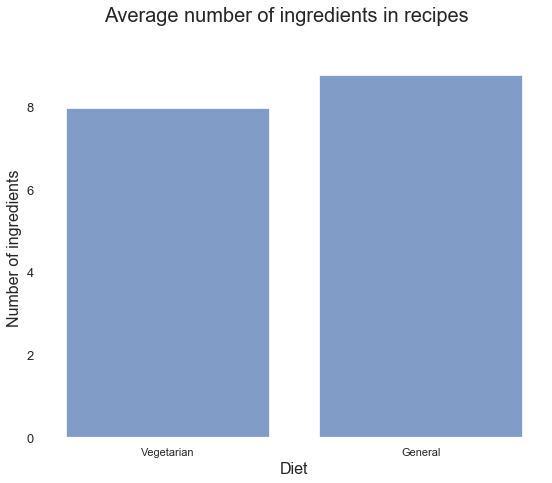

In [129]:
mean_vegetarian = df_ingredients[df_ingredients["Vegetarian"] == 1]["length"].mean()
mean_general = df_ingredients["length"].mean()
_data = [mean_vegetarian, mean_general]
_keys = ["Vegetarian", "General"]
fig, ax = plt.subplots(figsize=(9, 7))
plt.bar(np.arange(2), _data,
       align='center',
       alpha=0.7,
       ecolor='black',
       capsize=10, 
       tick_label=_keys) 
fig.suptitle('Average number of ingredients in recipes', fontsize=20)
plt.ylabel('Number of ingredients', fontsize=16)
plt.xlabel('Diet', fontsize=16)
ax.set_facecolor('xkcd:white')
#ax.set_facecolor((1.0, 0.47, 0.42))
plt.xticks(fontsize=11)
plt.yticks(fontsize=13)
plt.show()


(Time: 0.14 seconds)


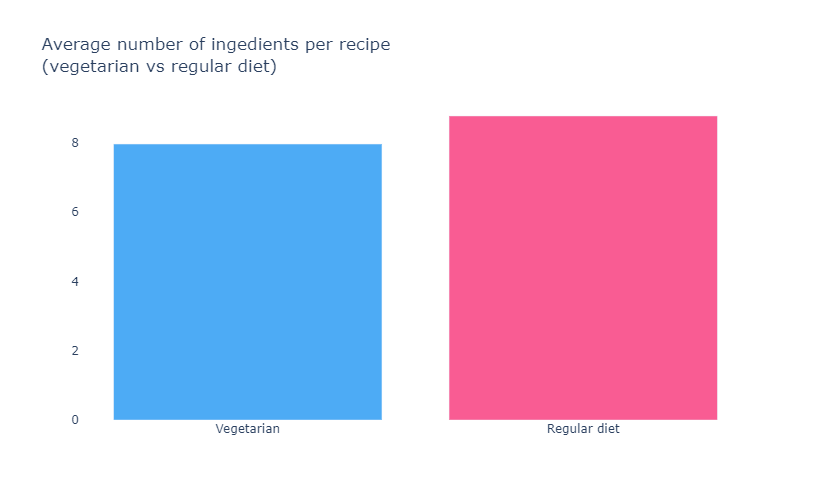

In [130]:
initial_time = time.time()
_keys_diets = ["Vegetarian", "Regular diet"]
_hovers = []

_hovers.append("Vegetarian diet has " + str(round(mean_vegetarian, 2)) + " ingredients in average per diet.")
_hovers.append("Regular diet has " + str(round(mean_general, 2)) + " ingredients in average per diet.")

_hovers.append("Total number of recipes: " + str(total))
fig = go.Figure(data=[go.Bar(x=_keys_diets,
                             y=_data,
                             hovertext=_hovers,
                             hoverinfo="text",
                             marker_color=["#2196f3", "#f73378"]
                            )])
# Customize aspect
fig.update_traces(opacity=0.8)
fig.update_layout(
    title_text='Average number of ingedients per recipe <br>(vegetarian vs regular diet)',
    width=500,
    height=500,
    plot_bgcolor='white'
)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
fig.show()

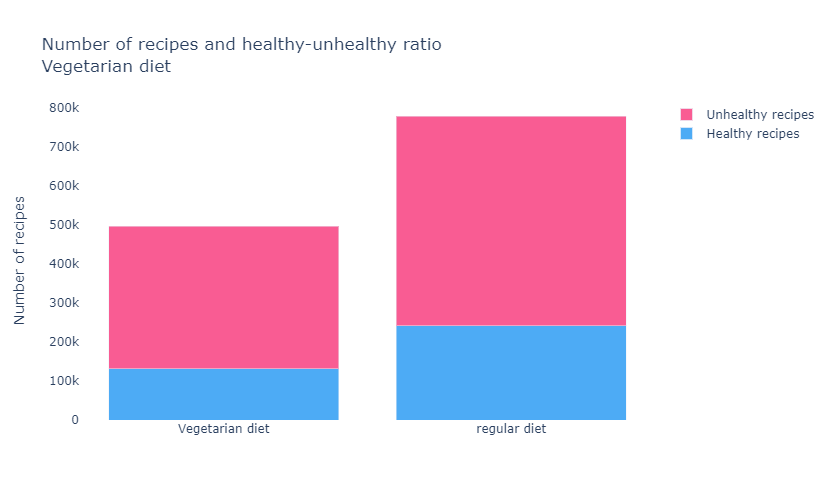

In [132]:
import plotly.graph_objects as go
diets=['Vegetarian diet', 'regular diet']
numberOfHealthyVegetarianRecipes = len(df_ingredients[(df_ingredients["Vegetarian"] == 1) & (df_ingredients["Unhealthy"] == 0)])
numberOfVegetarianRecipes = len(df_ingredients[df_ingredients["Vegetarian"] == 1])

numberOfHealthyRecipes = len(df_ingredients[df_ingredients["Unhealthy"] == 0])
numberOfRecipes = len(df_ingredients)

_hover_healthy1 = "Vegetarian:<br><br>"
_hover_healthy1 += "Healthy recipes: " + str(numberOfHealthyVegetarianRecipes) + "<br>"
_hover_healthy1 += "Total recipes: " + str(numberOfVegetarianRecipes) + "<br>"
_hover_healthy1 += "Percentage of healthy recipes: " + str(round(numberOfHealthyVegetarianRecipes*100/numberOfVegetarianRecipes, 2)) + "%"

_hover_healthy2 = "No diet:<br><br>"
_hover_healthy2 += "Healthy recipes: " + str(numberOfHealthyRecipes) + "<br>"
_hover_healthy2 += "Total recipes: " + str(numberOfRecipes) + "<br>"
_hover_healthy2 += "Percentage of unhealthy recipes: " + str(round(numberOfHealthyRecipes*100/numberOfRecipes, 2)) + "%"

_hover_unhealthy1 = "Vegetarian:<br><br>"
_hover_unhealthy1 += "Unhealthy recipes: " + str(numberOfVegetarianRecipes - numberOfHealthyVegetarianRecipes) + "<br>"
_hover_unhealthy1 += "Total recipes: " + str(numberOfVegetarianRecipes) + "<br>"
_hover_unhealthy1 += "Percentage of healthy recipes: " + str(round((numberOfVegetarianRecipes - numberOfHealthyVegetarianRecipes)*100/numberOfVegetarianRecipes, 2)) + "%"

_hover_unhealthy2 = "No diet:<br><br>"
_hover_unhealthy2 += "Unhealthy recipes: " + str(numberOfHealthyRecipes) + "<br>"
_hover_unhealthy2 += "Total recipes: " + str(numberOfRecipes) + "<br>"
_hover_unhealthy2 += "Percentage of unhealthy recipes: " + str(round((numberOfRecipes - numberOfHealthyRecipes)*100/numberOfRecipes, 2)) + "%"

fig = go.Figure(data=[
    go.Bar(
        name='Healthy recipes',
        x=diets,
        y=[numberOfHealthyVegetarianRecipes, numberOfHealthyRecipes],
        hovertext=[_hover_healthy1, _hover_healthy2],
        hoverinfo="text",
        marker_color= '#2196f3'
    ),
    go.Bar(
        name='Unhealthy recipes',
        x=diets,
        y=[numberOfVegetarianRecipes - numberOfHealthyVegetarianRecipes, numberOfRecipes - numberOfHealthyRecipes],
        hovertext=[_hover_unhealthy1, _hover_unhealthy2],
        hoverinfo="text",
        marker_color= '#f73378'
    )
])
fig.update_traces(opacity=0.8)
# Change the bar mode
fig.update_layout(
    title_text='Number of recipes and healthy-unhealthy ratio<br>Vegetarian diet',
    barmode='stack',
    width=500,
    height=500,
    plot_bgcolor="white",
)
fig.update_yaxes(title_text='Number of recipes')
fig.show()

## Iron rich

In [134]:
df_ironRich = df_ingredients[df_ingredients["IronRich"] == 1]
df_ironRich.head()

id                                        ingredients  \
3   00003a70b1  [butter, corn, water, french - fried onions, m...   
5   0000631d90  [pepper, soy sauce, lemon, garlic, salt, cashe...   
11  0000b1e2b5  [butter, chicken broth, fennel seeds, lemon, g...   
14  00010379bf  [soy sauce, water, vegetable oil, sugar, bakin...   
15  000106ec3c  [medium cheddar, onion, 1 can corn, potatoes, ...   

    LactoseFree  GlutenFree  Vegan  Vegetarian  IronRich  Omega3Rich  \
3             0           1      0           1         1           0   
5             1           1      0           0         1           0   
11            0           1      0           0         1           0   
14            1           0      1           1         1           0   
15            1           1      0           0         1           0   

    MagnesiumRich  Spicy  Unhealthy  length  
3               0      0          1       7  
5               0      0          0      11  
11              1      0          1       9  
14              1      0          1       7  
15              0      0          0       6

In [135]:
# Getting the not iron Rich ingredients
ingredients_not_ironRich = df_common_ing[df_common_ing["IronRich"] == 0].index.tolist()
printMain("Ingredients abailable for gluten intolerance people: " + str(len(ingredients_not_ironRich)))

Ingredients abailable for gluten intolerance people: 230


In [136]:
# Getting the iron rich ingredients
ingredients_ironRich = df_common_ing[df_common_ing["IronRich"] == 1].index.tolist()
printMain("Ingredients abailable for gluten intolerance people: " + str(len(ingredients_ironRich)))

Ingredients abailable for gluten intolerance people: 35


In [137]:
# First, we recalculate the dictionary of ingredients
initial_time = time.time()
dic_ingredients_not_ironRich = {}
 
for row in df_ironRich.itertuples():
    for ing in row[2]:
        if ing not in ingredient_list:
            continue
        if ing not in ingredients_ironRich:
            if ing in dic_ingredients_not_ironRich:
                dic_ingredients_not_ironRich[ing] += 1
            else:
                dic_ingredients_not_ironRich[ing] = 1

print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of different ingredients: " + str(len(dic_ingredients_not_ironRich)))

(Time: 6.58 seconds)
Number of different ingredients: 230


In [138]:
len(df_ingredients)

779088

In [139]:
len(df_glutenFree)

545587

In [140]:
dic_ingredients_ironRich_per = {}
ingredients_ironRich_per = []
ingredients_ironRich_per_general = []
keys_ironRich = []

for key in ingredients_not_ironRich:
    ingredients_ironRich_per_general.append(dic_ingredients_per[key])
    keys_ironRich.append(key)
    if key in dic_ingredients_not_ironRich:
        ingredients_ironRich_per.append((dic_ingredients_not_ironRich[key]/len(df_ironRich))*100)
        dic_ingredients_ironRich_per[key] = (dic_ingredients_not_ironRich[key]/len(df_ironRich))*100
    else: 
        ingredients_ironRich_per.append(0)
        dic_ingredients_ironRich_per[key] = 0

In [141]:
dic_more_per_ironRich = {}
dic_less_per_ironRich = {}
dic_double_ironRich = {}
dic_half_ironRich = {}
mean_change_ironRich = 0
absolute_change_ironRich = 0
dic_changes_ironRich = {}
mean_total = 0
initial_time = time.time()

for key in dic_ingredients_ironRich_per:
    change = dic_ingredients_ironRich_per[key] - dic_ingredients_per[key]
    dic_changes_ironRich[key] = change
    mean_change_ironRich += change
    absolute_change_ironRich += abs(change)
    mean_total += dic_ingredients_per[key]
    if dic_ingredients_ironRich_per[key] - 2 > dic_ingredients_per[key]:
        dic_more_per_ironRich[key] = [dic_ingredients_per[key], dic_ingredients_ironRich_per[key]]
    elif dic_ingredients_ironRich_per[key] + 2 < dic_ingredients_per[key]:
        dic_less_per_ironRich[key] = [dic_ingredients_per[key], dic_ingredients_ironRich_per[key]]
        
    if dic_ingredients_ironRich_per[key] > 2*dic_ingredients_per[key]:
        dic_double_ironRich[key] = [dic_ingredients_per[key], dic_ingredients_ironRich_per[key]]
    elif dic_ingredients_ironRich_per[key]*2 < dic_ingredients_per[key]:
        dic_half_ironRich[key] = [dic_ingredients_per[key], dic_ingredients_ironRich_per[key]]

mean_change_ironRich = mean_change_ironRich/len(dic_ingredients_ironRich_per)
absolute_change_ironRich = absolute_change_ironRich/len(dic_ingredients_ironRich_per)
mean_total = mean_total/len(dic_ingredients_ironRich_per)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")

printMain("Ingredients increasing more than 2%:")
print(dic_more_per_ironRich)
print()
printMain("Ingredients decreasing more than 2%:")
print(dic_less_per_ironRich)
print()
printMain("Ingredients multipling by 2 their percentage of appearances:")
print(dic_double_ironRich)
print()
printMain("Ingredients dividing by 2 their percentage of appearances:")
print(dic_half_ironRich)

(Time: 0.0 seconds)
Ingredients increasing more than 2%:
{'salt': [52.792239130881235, 60.35748031020669], 'pepper': [31.675754215184938, 44.598098791594595], 'garlic': [26.720986589448177, 38.90352982373522], 'onion': [25.87653769535662, 39.37958661244993], 'olive oil': [19.051121311071405, 27.392736285066547], 'cheese': [17.739074404945267, 22.97177771136529], 'tomatoes': [11.635142628303862, 17.15887376495413], 'bell pepper': [7.89384511120695, 11.728445374219277], 'carrot': [6.0914813217505595, 9.94708132209151], 'celery': [5.427628201178814, 8.855501519940349], 'chicken broth': [5.421852216951102, 7.735243597987098], 'oregano': [3.8036781467562073, 6.059535776709141], 'bay leaf': [2.674152342225782, 4.755134138131938]}

Ingredients decreasing more than 2%:
{'sugar': [34.45451604953484, 22.32667095329089], 'butter': [29.072839011767606, 26.304175232368237], 'egg': [26.97975068284969, 21.57288921491383], 'flour': [23.47064773170682, 19.480895844087627], 'milk': [14.144871952847431, 

In [142]:
printMain("Mean change: " + str(mean_change_ironRich))
printMain("Mean change in absolute value: " + str(absolute_change_ironRich))
printMain("Mean total: " + str(mean_total))
printMain("Percentual mean change: " + str(absolute_change_ironRich*100/mean_total))

Mean change: 0.25918557796389147
Mean change in absolute value: 0.9101715882158918
Mean total: 3.07909850447212
Percentual mean change: 29.559677512555947


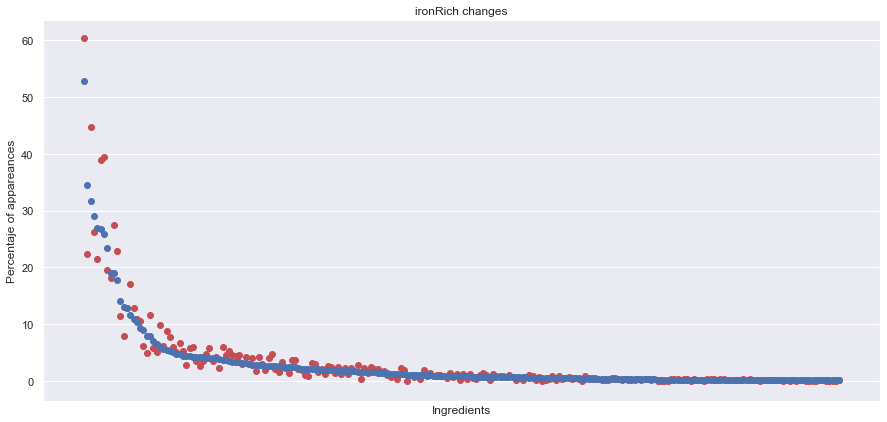

In [143]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.scatter(list(range(len(ingredients_ironRich_per))), ingredients_ironRich_per, color='r')
ax.scatter(list(range(len(ingredients_ironRich_per))), ingredients_ironRich_per_general, color='b')
ax.set_xlabel('Ingredients')
ax.set_ylabel('Percentaje of appareances')
ax.set_title('ironRich changes')
plt.xticks([])
plt.show()

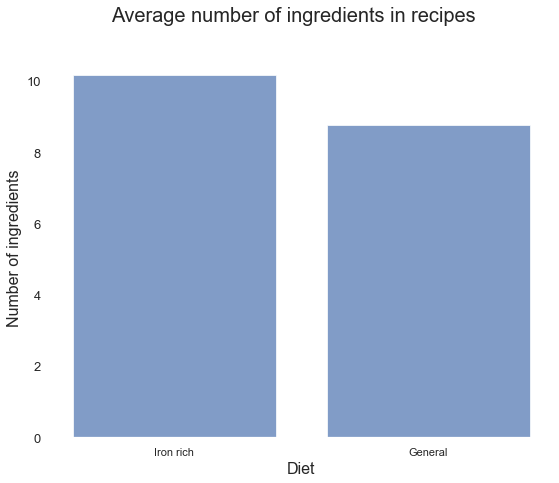

In [144]:
mean_ironRich = df_ingredients[df_ingredients["IronRich"] == 1]["length"].mean()
mean_general = df_ingredients["length"].mean()
_data = [mean_ironRich, mean_general]
_keys = ["Iron rich", "General"]
fig, ax = plt.subplots(figsize=(9, 7))
plt.bar(np.arange(2), _data,
       align='center',
       alpha=0.7,
       ecolor='black',
       capsize=10, 
       tick_label=_keys) 
fig.suptitle('Average number of ingredients in recipes', fontsize=20)
plt.ylabel('Number of ingredients', fontsize=16)
plt.xlabel('Diet', fontsize=16)
ax.set_facecolor('xkcd:white')
#ax.set_facecolor((1.0, 0.47, 0.42))
plt.xticks(fontsize=11)
plt.yticks(fontsize=13)
plt.show()


(Time: 0.15 seconds)


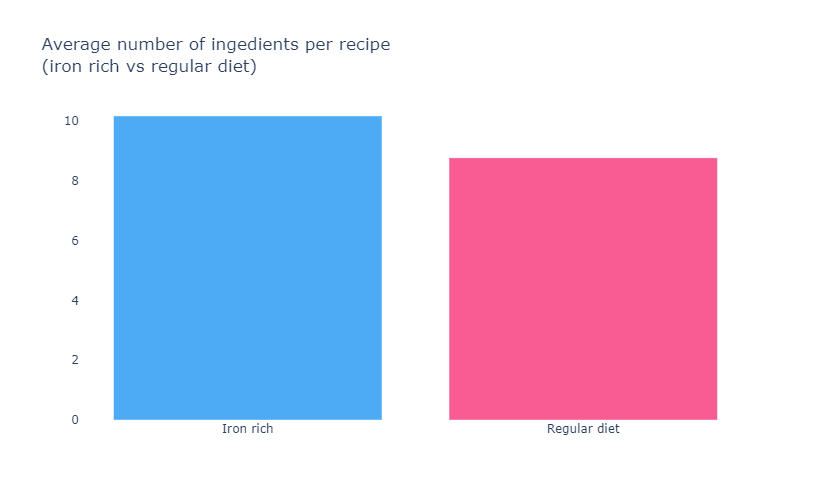

In [145]:
initial_time = time.time()
_keys_diets = ["Iron rich", "Regular diet"]
_hovers = []

_hovers.append("Iron rich diet has " + str(round(mean_ironRich, 2)) + " ingredients in average per diet.")
_hovers.append("Regular diet has " + str(round(mean_general, 2)) + " ingredients in average per diet.")

_hovers.append("Total number of recipes: " + str(total))
fig = go.Figure(data=[go.Bar(x=_keys_diets,
                             y=_data,
                             hovertext=_hovers,
                             hoverinfo="text",
                             marker_color=["#2196f3", "#f73378"]
                            )])
# Customize aspect
fig.update_traces(opacity=0.8)
fig.update_layout(
    title_text='Average number of ingedients per recipe <br>(iron rich vs regular diet)',
    width=500,
    height=500,
    plot_bgcolor='white'
)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
fig.show()

In [146]:
#ff.plot(fig, filename='plots/IronLength.html')

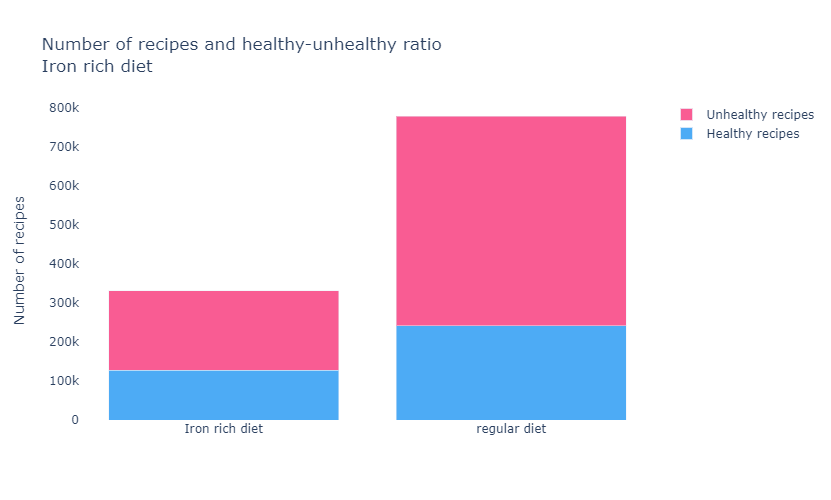

In [147]:
import plotly.graph_objects as go
diets=['Iron rich diet', 'regular diet']
numberOfHealthyIronRichRecipes = len(df_ingredients[(df_ingredients["IronRich"] == 1) & (df_ingredients["Unhealthy"] == 0)])
numberOfIronRichRecipes = len(df_ingredients[df_ingredients["IronRich"] == 1])

numberOfHealthyRecipes = len(df_ingredients[df_ingredients["Unhealthy"] == 0])
numberOfRecipes = len(df_ingredients)

_hover_healthy1 = "Iron rich:<br><br>"
_hover_healthy1 += "Healthy recipes: " + str(numberOfHealthyIronRichRecipes) + "<br>"
_hover_healthy1 += "Total recipes: " + str(numberOfIronRichRecipes) + "<br>"
_hover_healthy1 += "Percentage of healthy recipes: " + str(round(numberOfHealthyIronRichRecipes*100/numberOfIronRichRecipes, 2)) + "%"

_hover_healthy2 = "No diet:<br><br>"
_hover_healthy2 += "Healthy recipes: " + str(numberOfHealthyRecipes) + "<br>"
_hover_healthy2 += "Total recipes: " + str(numberOfRecipes) + "<br>"
_hover_healthy2 += "Percentage of unhealthy recipes: " + str(round(numberOfHealthyRecipes*100/numberOfRecipes, 2)) + "%"

_hover_unhealthy1 = "Iron rich:<br><br>"
_hover_unhealthy1 += "Unhealthy recipes: " + str(numberOfIronRichRecipes - numberOfHealthyIronRichRecipes) + "<br>"
_hover_unhealthy1 += "Total recipes: " + str(numberOfIronRichRecipes) + "<br>"
_hover_unhealthy1 += "Percentage of healthy recipes: " + str(round((numberOfIronRichRecipes - numberOfHealthyIronRichRecipes)*100/numberOfIronRichRecipes, 2)) + "%"

_hover_unhealthy2 = "No diet:<br><br>"
_hover_unhealthy2 += "Unhealthy recipes: " + str(numberOfHealthyRecipes) + "<br>"
_hover_unhealthy2 += "Total recipes: " + str(numberOfRecipes) + "<br>"
_hover_unhealthy2 += "Percentage of unhealthy recipes: " + str(round((numberOfRecipes - numberOfHealthyRecipes)*100/numberOfRecipes, 2)) + "%"

fig = go.Figure(data=[
    go.Bar(
        name='Healthy recipes',
        x=diets,
        y=[numberOfHealthyIronRichRecipes, numberOfHealthyRecipes],
        hovertext=[_hover_healthy1, _hover_healthy2],
        hoverinfo="text",
        marker_color= '#2196f3'
    ),
    go.Bar(
        name='Unhealthy recipes',
        x=diets,
        y=[numberOfIronRichRecipes - numberOfHealthyIronRichRecipes, numberOfRecipes - numberOfHealthyRecipes],
        hovertext=[_hover_unhealthy1, _hover_unhealthy2],
        hoverinfo="text",
        marker_color= '#f73378'
    )
])
fig.update_traces(opacity=0.8)
# Change the bar mode
fig.update_layout(
    title_text='Number of recipes and healthy-unhealthy ratio<br>Iron rich diet',
    barmode='stack',
    width=500,
    height=500,
    plot_bgcolor="white",
)
fig.update_yaxes(title_text='Number of recipes')
fig.show()

## Omega 3 Rich

In [149]:
df_omega3Rich = df_ingredients[df_ingredients["Omega3Rich"] == 1]
df_omega3Rich.head()

id                                        ingredients  \
20  000128a538   [pecans, oat, soy, blueberries, yogurt, coconut]   
28  00019675ca  [pepper, cilantro, onion, garlic, sour cream, ...   
34  0001d81db6  [cilantro, tomatoes, garlic, sour cream, lime,...   
52  00039c5d51  [pepper, vegetable oil, onion, garlic, stock, ...   
56  0003dc1278  [scallion, salt, sushi rice, nori, cucumber, s...   

    LactoseFree  GlutenFree  Vegan  Vegetarian  IronRich  Omega3Rich  \
20            0           1      0           1         1           1   
28            0           1      0           0         1           1   
34            0           1      0           1         0           1   
52            1           1      0           0         1           1   
56            1           1      1           1         1           1   

    MagnesiumRich  Spicy  Unhealthy  length  
20              1      0          0       6  
28              0      0          0      11  
34              1      0          1       8  
52              1      1          1      10  
56              1      0          0       8

In [150]:
# Getting the not omega 3 rich ingredients
ingredients_not_omega3Rich = df_common_ing[df_common_ing["Omega3Rich"] == 0].index.tolist()
printMain("Ingredients abailable for gluten intolerance people: " + str(len(ingredients_not_omega3Rich)))

Ingredients abailable for gluten intolerance people: 255


In [151]:
# Getting the omega3 rich ingredients
ingredients_omega3Rich = df_common_ing[df_common_ing["Omega3Rich"] == 1].index.tolist()
printMain("Ingredients abailable for gluten intolerance people: " + str(len(ingredients_omega3Rich)))

Ingredients abailable for gluten intolerance people: 10


In [152]:
# First, we recalculate the dictionary of ingredients
initial_time = time.time()
dic_ingredients_not_omega3Rich = {}
 
for row in df_omega3Rich.itertuples():
    for ing in row[2]:
        if ing not in ingredient_list:
            continue
        if ing not in ingredients_omega3Rich:
            if ing in dic_ingredients_not_omega3Rich:
                dic_ingredients_not_omega3Rich[ing] += 1
            else:
                dic_ingredients_not_omega3Rich[ing] = 1

print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of different ingredients: " + str(len(dic_ingredients_not_omega3Rich)))

(Time: 1.58 seconds)
Number of different ingredients: 255


In [153]:
len(df_ingredients)

779088

In [154]:
len(df_omega3Rich)

88072

In [155]:
dic_ingredients_omega3Rich_per = {}
ingredients_omega3Rich_per = []
ingredients_omega3Rich_per_general = []
keys_omega3Rich = []

for key in ingredients_not_omega3Rich:
    ingredients_omega3Rich_per_general.append(dic_ingredients_per[key])
    keys_omega3Rich.append(key)
    if key in dic_ingredients_not_omega3Rich:
        ingredients_omega3Rich_per.append((dic_ingredients_not_omega3Rich[key]/len(df_omega3Rich))*100)
        dic_ingredients_omega3Rich_per[key] = (dic_ingredients_not_omega3Rich[key]/len(df_omega3Rich))*100
    else: 
        ingredients_omega3Rich_per.append(0)
        dic_ingredients_omega3Rich_per[key] = 0

In [156]:
dic_more_per_omega3Rich = {}
dic_less_per_omega3Rich = {}
dic_double_omega3Rich = {}
dic_half_omega3Rich = {}
mean_change_omega3Rich = 0
absolute_change_omega3Rich = 0
dic_changes_omega3Rich = {}
mean_total = 0
initial_time = time.time()

for key in dic_ingredients_omega3Rich_per:
    change = dic_ingredients_omega3Rich_per[key] - dic_ingredients_per[key]
    dic_changes_omega3Rich[key] = change
    mean_change_omega3Rich += change
    absolute_change_omega3Rich += abs(change)
    mean_total += dic_ingredients_per[key]
    if dic_ingredients_omega3Rich_per[key] - 2 > dic_ingredients_per[key]:
        dic_more_per_omega3Rich[key] = [dic_ingredients_per[key], dic_ingredients_omega3Rich_per[key]]
    elif dic_ingredients_omega3Rich_per[key] + 2 < dic_ingredients_per[key]:
        dic_less_per_omega3Rich[key] = [dic_ingredients_per[key], dic_ingredients_omega3Rich_per[key]]
        
    if dic_ingredients_omega3Rich_per[key] > 2*dic_ingredients_per[key]:
        dic_double_omega3Rich[key] = [dic_ingredients_per[key], dic_ingredients_omega3Rich_per[key]]
    elif dic_ingredients_omega3Rich_per[key]*2 < dic_ingredients_per[key]:
        dic_half_omega3Rich[key] = [dic_ingredients_per[key], dic_ingredients_omega3Rich_per[key]]

mean_change_omega3Rich = mean_change_omega3Rich/len(dic_ingredients_omega3Rich_per)
absolute_change_omega3Rich = absolute_change_omega3Rich/len(dic_ingredients_omega3Rich_per)
mean_total = mean_total/len(dic_ingredients_omega3Rich_per)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")

printMain("Ingredients increasing more than 2%:")
print(dic_more_per_omega3Rich)
printMain("Ingredients decreasing more than 2%:")
print(dic_less_per_omega3Rich)
print()
printMain("Ingredients multipling by 2 their percentage of appearances:")
print(dic_double_omega3Rich)
print()
printMain("Ingredients dividing by 2 their percentage of appearances:")
print(dic_half_omega3Rich)

(Time: 0.0 seconds)
Ingredients increasing more than 2%:
{'salt': [52.792239130881235, 56.96929784721591], 'pepper': [31.675754215184938, 37.21273503497139], 'garlic': [26.720986589448177, 35.936506494686164], 'onion': [25.87653769535662, 33.24325551821237], 'olive oil': [19.051121311071405, 26.933645199382322], 'lemon': [12.936279341999876, 19.239940049050777], 'tomatoes': [11.635142628303862, 20.76142247252248], 'vegetable oil': [11.030589612469965, 13.735352893087475], 'parsley': [8.566041320107614, 12.26950676719048], 'bell pepper': [7.89384511120695, 13.395857934417297], 'celery': [5.427628201178814, 8.336361159051684], 'chili': [4.38718090896022, 9.416159505858843], 'cumin': [4.371264863532746, 9.222000181669543], 'lime': [4.225838416199454, 10.161004632573349], 'cilantro': [4.08914012281026, 11.446316650013626], 'scallions': [4.061800464132421, 7.887864474520846], 'mayonnaise': [3.797517096913314, 7.858343173766919], 'cayenne': [3.3924280697430844, 5.451221727677355], 'scallion'

In [157]:
printMain("Mean change: " + str(mean_change_omega3Rich))
printMain("Mean change in absolute value: " + str(absolute_change_omega3Rich))
printMain("Mean total: " + str(mean_total))
printMain("Percentual mean change: " + str(absolute_change_omega3Rich*100/mean_total))

Mean change: 0.2714389229908659
Mean change in absolute value: 0.9583703487076664
Mean total: 2.95845408789684
Percentual mean change: 32.3942951363822


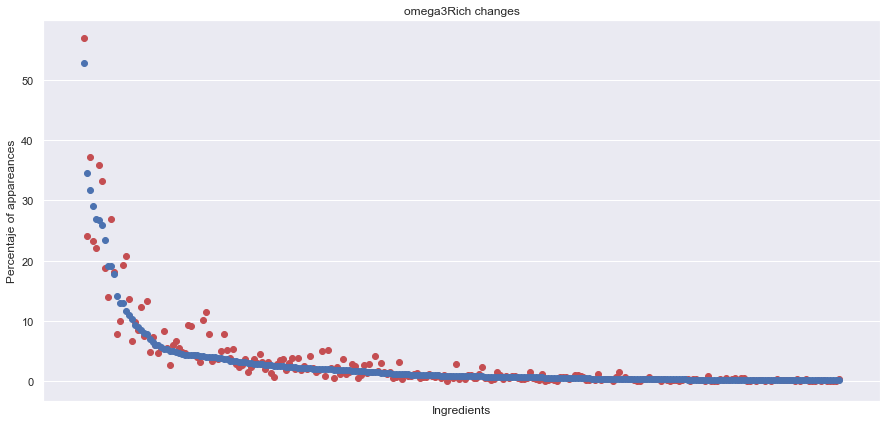

In [158]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.scatter(list(range(len(ingredients_omega3Rich_per))), ingredients_omega3Rich_per, color='r')
ax.scatter(list(range(len(ingredients_omega3Rich_per))), ingredients_omega3Rich_per_general, color='b')
ax.set_xlabel('Ingredients')
ax.set_ylabel('Percentaje of appareances')
ax.set_title('omega3Rich changes')
plt.xticks([])
plt.show()

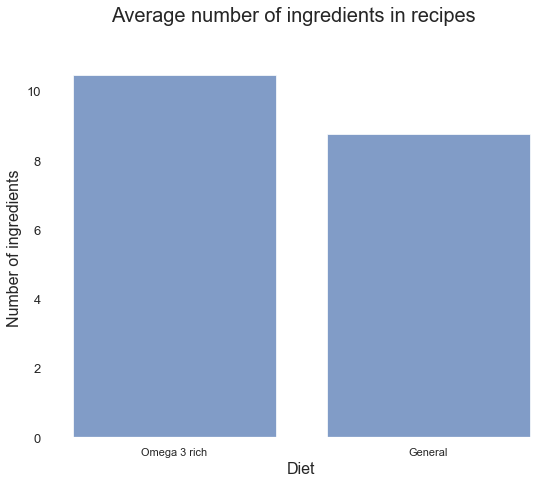

In [159]:
mean_omega3Rich = df_ingredients[df_ingredients["Omega3Rich"] == 1]["length"].mean()
mean_general = df_ingredients["length"].mean()
_data = [mean_omega3Rich, mean_general]
_keys = ["Omega 3 rich", "General"]
fig, ax = plt.subplots(figsize=(9, 7))
plt.bar(np.arange(2), _data,
       align='center',
       alpha=0.7,
       ecolor='black',
       capsize=10, 
       tick_label=_keys) 
fig.suptitle('Average number of ingredients in recipes', fontsize=20)
plt.ylabel('Number of ingredients', fontsize=16)
plt.xlabel('Diet', fontsize=16)
ax.set_facecolor('xkcd:white')
#ax.set_facecolor((1.0, 0.47, 0.42))
plt.xticks(fontsize=11)
plt.yticks(fontsize=13)
plt.show()


(Time: 0.13 seconds)


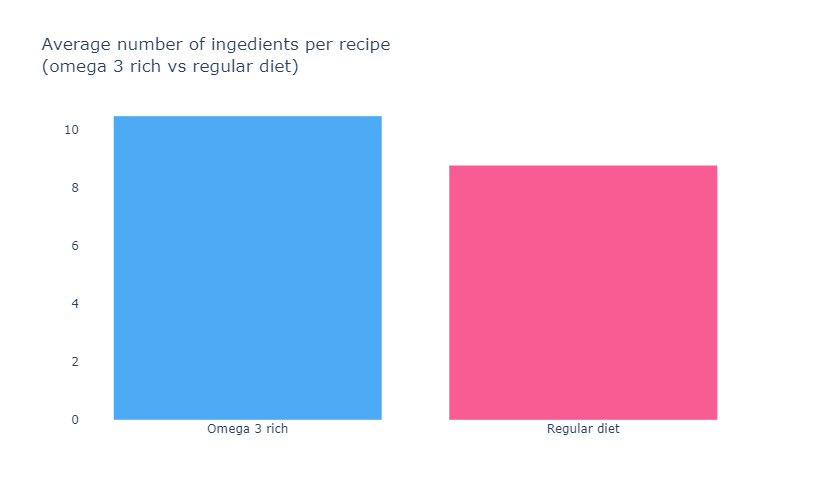

In [160]:
initial_time = time.time()
_keys_diets = ["Omega 3 rich", "Regular diet"]
_hovers = []

_hovers.append("Omega 3 rich diet has " + str(round(mean_omega3Rich, 2)) + " ingredients in average per diet.")
_hovers.append("Regular diet has " + str(round(mean_general, 2)) + " ingredients in average per diet.")

_hovers.append("Total number of recipes: " + str(total))
fig = go.Figure(data=[go.Bar(x=_keys_diets,
                             y=_data,
                             hovertext=_hovers,
                             hoverinfo="text",
                             marker_color=["#2196f3", "#f73378"]
                            )])
# Customize aspect
fig.update_traces(opacity=0.8)
fig.update_layout(
    title_text='Average number of ingedients per recipe <br>(omega 3 rich vs regular diet)',
    width=500,
    height=500,
    plot_bgcolor='white'
)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
fig.show()

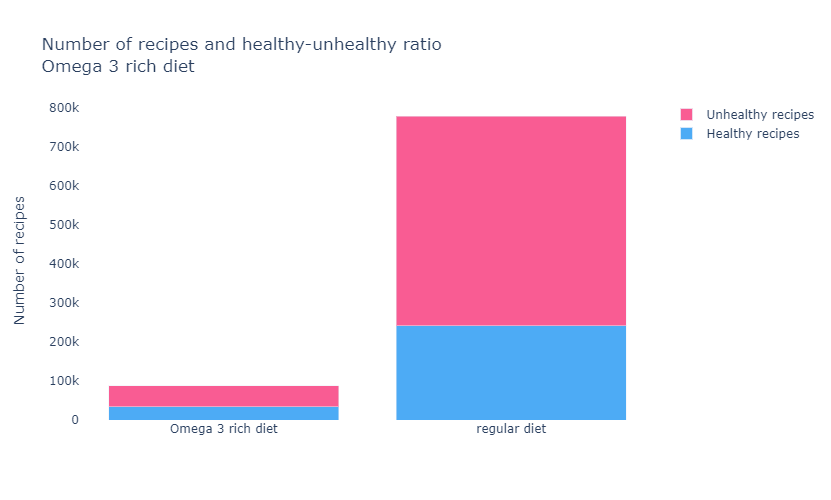

In [162]:
import plotly.graph_objects as go
diets=['Omega 3 rich diet', 'regular diet']
numberOfHealthyOmega3RichRecipes = len(df_ingredients[(df_ingredients["Omega3Rich"] == 1) & (df_ingredients["Unhealthy"] == 0)])
numberOfOmega3RichRecipes = len(df_ingredients[df_ingredients["Omega3Rich"] == 1])

numberOfHealthyRecipes = len(df_ingredients[df_ingredients["Unhealthy"] == 0])
numberOfRecipes = len(df_ingredients)

_hover_healthy1 = "Omega 3 rich:<br><br>"
_hover_healthy1 += "Healthy recipes: " + str(numberOfHealthyOmega3RichRecipes) + "<br>"
_hover_healthy1 += "Total recipes: " + str(numberOfOmega3RichRecipes) + "<br>"
_hover_healthy1 += "Percentage of healthy recipes: " + str(round(numberOfHealthyOmega3RichRecipes*100/numberOfOmega3RichRecipes, 2)) + "%"

_hover_healthy2 = "No diet:<br><br>"
_hover_healthy2 += "Healthy recipes: " + str(numberOfHealthyRecipes) + "<br>"
_hover_healthy2 += "Total recipes: " + str(numberOfRecipes) + "<br>"
_hover_healthy2 += "Percentage of unhealthy recipes: " + str(round(numberOfHealthyRecipes*100/numberOfRecipes, 2)) + "%"

_hover_unhealthy1 = "Omega 3 rich:<br><br>"
_hover_unhealthy1 += "Unhealthy recipes: " + str(numberOfOmega3RichRecipes - numberOfHealthyOmega3RichRecipes) + "<br>"
_hover_unhealthy1 += "Total recipes: " + str(numberOfOmega3RichRecipes) + "<br>"
_hover_unhealthy1 += "Percentage of healthy recipes: " + str(round((numberOfOmega3RichRecipes - numberOfHealthyOmega3RichRecipes)*100/numberOfOmega3RichRecipes, 2)) + "%"

_hover_unhealthy2 = "No diet:<br><br>"
_hover_unhealthy2 += "Unhealthy recipes: " + str(numberOfHealthyRecipes) + "<br>"
_hover_unhealthy2 += "Total recipes: " + str(numberOfRecipes) + "<br>"
_hover_unhealthy2 += "Percentage of unhealthy recipes: " + str(round((numberOfRecipes - numberOfHealthyRecipes)*100/numberOfRecipes, 2)) + "%"

fig = go.Figure(data=[
    go.Bar(
        name='Healthy recipes',
        x=diets,
        y=[numberOfHealthyOmega3RichRecipes, numberOfHealthyRecipes],
        hovertext=[_hover_healthy1, _hover_healthy2],
        hoverinfo="text",
        marker_color= '#2196f3'
    ),
    go.Bar(
        name='Unhealthy recipes',
        x=diets,
        y=[numberOfOmega3RichRecipes - numberOfHealthyOmega3RichRecipes, numberOfRecipes - numberOfHealthyRecipes],
        hovertext=[_hover_unhealthy1, _hover_unhealthy2],
        hoverinfo="text",
        marker_color= '#f73378'
    )
])
# Change the bar mode
fig.update_traces(opacity=0.8)
# Change the bar mode
fig.update_layout(
    title_text='Number of recipes and healthy-unhealthy ratio<br>Omega 3 rich diet',
    barmode='stack',
    width=500,
    height=500,
    plot_bgcolor="white",
)
fig.update_yaxes(title_text='Number of recipes')
fig.show()

## Magnesium

In [164]:
df_magnesiumRich = df_ingredients[df_ingredients["MagnesiumRich"] == 1]
df_magnesiumRich.head()

id                                        ingredients  \
11  0000b1e2b5  [butter, chicken broth, fennel seeds, lemon, g...   
14  00010379bf  [soy sauce, water, vegetable oil, sugar, bakin...   
16  00010c7867  [pepper, chili, butter, tomatoes, onion, milk,...   
17  00010d44c7  [pepper, butter, onion, garlic, broccoli, milk...   
20  000128a538   [pecans, oat, soy, blueberries, yogurt, coconut]   

    LactoseFree  GlutenFree  Vegan  Vegetarian  IronRich  Omega3Rich  \
11            0           1      0           0         1           0   
14            1           0      1           1         1           0   
16            0           0      0           0         1           0   
17            0           1      0           1         1           0   
20            0           1      0           1         1           1   

    MagnesiumRich  Spicy  Unhealthy  length  
11              1      0          1       9  
14              1      0          1       7  
16              1      1          1      14  
17              1      0          1      12  
20              1      0          0       6

In [165]:
# Getting the not omega 3 rich ingredients
ingredients_not_magnesiumRich = df_common_ing[df_common_ing["MagnesiumRich"] == 0].index.tolist()
printMain("Ingredients not rich in magnesium: " + str(len(ingredients_not_magnesiumRich)))

Ingredients not rich in magnesium: 240


In [166]:
# Getting the omega3 rich ingredients
ingredients_magnesiumRich = df_common_ing[df_common_ing["MagnesiumRich"] == 1].index.tolist()
printMain("Ingredients rich in magnesium: " + str(len(ingredients_magnesiumRich)))

Ingredients rich in magnesium: 25


In [167]:
# First, we recalculate the dictionary of ingredients
initial_time = time.time()
dic_ingredients_not_magnesiumRich = {}
 
for row in df_magnesiumRich.itertuples():
    for ing in row[2]:
        if ing not in ingredient_list:
            continue
        if ing not in ingredients_magnesiumRich:
            if ing in dic_ingredients_not_magnesiumRich:
                dic_ingredients_not_magnesiumRich[ing] += 1
            else:
                dic_ingredients_not_magnesiumRich[ing] = 1

print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of different ingredients: " + str(len(dic_ingredients_not_magnesiumRich)))

(Time: 3.49 seconds)
Number of different ingredients: 240


In [168]:
len(df_ingredients)

779088

In [169]:
len(df_magnesiumRich)

195876

In [170]:
dic_ingredients_magnesiumRich_per = {}
ingredients_magnesiumRich_per = []
ingredients_magnesiumRich_per_general = []
keys_magnesiumRich = []

for key in ingredients_not_magnesiumRich:
    ingredients_magnesiumRich_per_general.append(dic_ingredients_per[key])
    keys_magnesiumRich.append(key)
    if key in dic_ingredients_not_magnesiumRich:
        ingredients_magnesiumRich_per.append((dic_ingredients_not_magnesiumRich[key]/len(df_magnesiumRich))*100)
        dic_ingredients_magnesiumRich_per[key] = (dic_ingredients_not_magnesiumRich[key]/len(df_magnesiumRich))*100
    else: 
        ingredients_magnesiumRich_per.append(0)
        dic_ingredients_magnesiumRich_per[key] = 0

In [171]:
dic_more_per_magnesiumRich = {}
dic_less_per_magnesiumRich = {}
dic_double_magnesiumRich = {}
dic_half_magnesiumRich = {}
mean_change_magnesiumRich = 0
absolute_change_magnesiumRich = 0
dic_changes_magnesiumRich = {}
mean_total = 0
initial_time = time.time()

for key in dic_ingredients_magnesiumRich_per:
    change = dic_ingredients_magnesiumRich_per[key] - dic_ingredients_per[key]
    dic_changes_magnesiumRich[key] = change
    mean_change_magnesiumRich += change
    absolute_change_magnesiumRich += abs(change)
    mean_total += dic_ingredients_per[key]
    if dic_ingredients_magnesiumRich_per[key] - 2 > dic_ingredients_per[key]:
        dic_more_per_magnesiumRich[key] = [dic_ingredients_per[key], dic_ingredients_magnesiumRich_per[key]]
    elif dic_ingredients_magnesiumRich_per[key] + 2 < dic_ingredients_per[key]:
        dic_less_per_magnesiumRich[key] = [dic_ingredients_per[key], dic_ingredients_magnesiumRich_per[key]]
        
    if dic_ingredients_magnesiumRich_per[key] > 2*dic_ingredients_per[key]:
        dic_double_magnesiumRich[key] = [dic_ingredients_per[key], dic_ingredients_magnesiumRich_per[key]]
    elif dic_ingredients_magnesiumRich_per[key]*2 < dic_ingredients_per[key]:
        dic_half_magnesiumRich[key] = [dic_ingredients_per[key], dic_ingredients_magnesiumRich_per[key]]

mean_change_magnesiumRich = mean_change_magnesiumRich/len(dic_ingredients_magnesiumRich_per)
absolute_change_magnesiumRich = absolute_change_magnesiumRich/len(dic_ingredients_magnesiumRich_per)
mean_total = mean_total/len(dic_ingredients_magnesiumRich_per)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")

printMain("Ingredients increasing more than 2%:")
print(dic_more_per_magnesiumRich)
print()
printMain("Ingredients decreasing more than 2%:")
print(dic_less_per_magnesiumRich)
print()
printMain("Ingredients multipling by 2 their percentage of appearances:")
print(dic_double_magnesiumRich)
print()
printMain("Ingredients dividing by 2 their percentage of appearances:")
print(dic_half_magnesiumRich)

(Time: 0.0 seconds)
Ingredients increasing more than 2%:
{'vanilla': [12.97517096913314, 17.18740427617472], 'vegetable oil': [11.030589612469965, 13.570319998366315], 'baking soda': [6.496313638510669, 9.64283526312565], 'chocolate': [4.234438214938492, 6.305009291592641], 'cilantro': [4.08914012281026, 6.202903877963609]}

Ingredients decreasing more than 2%:
{'pepper': [31.675754215184938, 29.35224325593743], 'parsley': [8.566041320107614, 6.457656884968041]}

Ingredients multipling by 2 their percentage of appearances:
{'wheat germ': [0.2662086952950116, 0.6427535787947477], 'tahini': [0.2640266568089869, 0.6034429945475709]}

Ingredients dividing by 2 their percentage of appearances:
{'barbecue sauce': [0.7504928839874314, 0.35175314995201046], 'vodka': [0.6424178013266794, 0.16438971594273927], 'bourbon': [0.3715883186494979, 0.16643182421531988], 'apple cider': [0.3667108208572074, 0.14805284976209437], 'tequila': [0.3288460353644261, 0.11486859033265943], 'pepperoni': [0.275706

In [172]:
printMain("Mean change: " + str(mean_change_magnesiumRich))
printMain("Mean change in absolute value: " + str(absolute_change_magnesiumRich))
printMain("Mean total: " + str(mean_total))
printMain("Percentual mean change: " + str(absolute_change_magnesiumRich*100/mean_total))

Mean change: 0.05008109838935288
Mean change in absolute value: 0.40464754377549383
Mean total: 3.0727300168059752
Percentual mean change: 13.16899114345603


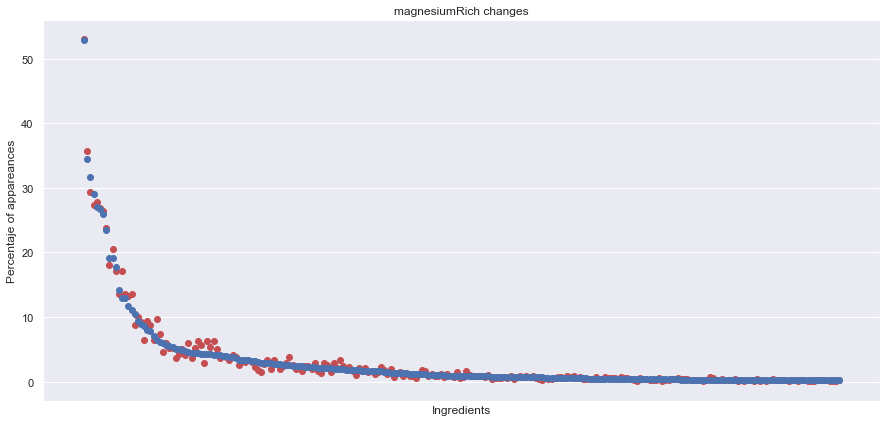

In [173]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.scatter(list(range(len(ingredients_magnesiumRich_per))), ingredients_magnesiumRich_per, color='r')
ax.scatter(list(range(len(ingredients_magnesiumRich_per))), ingredients_magnesiumRich_per_general, color='b')
ax.set_xlabel('Ingredients')
ax.set_ylabel('Percentaje of appareances')
ax.set_title('magnesiumRich changes')
plt.xticks([])
plt.show()

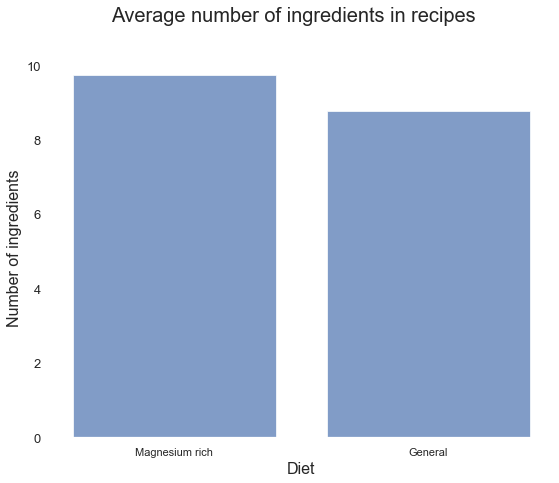

In [174]:
mean_magnesiumRich = df_ingredients[df_ingredients["MagnesiumRich"] == 1]["length"].mean()
mean_general = df_ingredients["length"].mean()
_data = [mean_magnesiumRich, mean_general]
_keys = ["Magnesium rich", "General"]
fig, ax = plt.subplots(figsize=(9, 7))
plt.bar(np.arange(2), _data,
       align='center',
       alpha=0.7,
       ecolor='black',
       capsize=10, 
       tick_label=_keys) 
fig.suptitle('Average number of ingredients in recipes', fontsize=20)
plt.ylabel('Number of ingredients', fontsize=16)
plt.xlabel('Diet', fontsize=16)
ax.set_facecolor('xkcd:white')
#ax.set_facecolor((1.0, 0.47, 0.42))
plt.xticks(fontsize=11)
plt.yticks(fontsize=13)
plt.show()


(Time: 0.14 seconds)


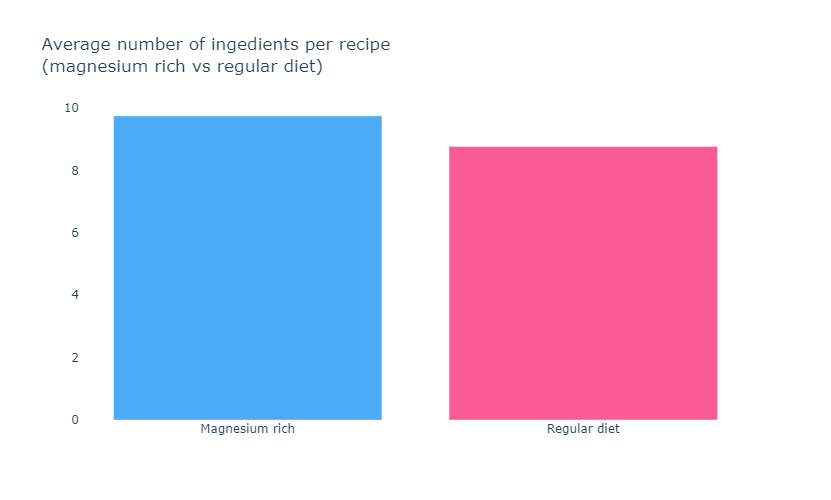

In [175]:
initial_time = time.time()
_keys_diets = ["Magnesium rich", "Regular diet"]
_hovers = []

_hovers.append("Magnesium rich diet has " + str(round(mean_magnesiumRich, 2)) + " ingredients in average per diet.")
_hovers.append("Regular diet has " + str(round(mean_general, 2)) + " ingredients in average per diet.")

_hovers.append("Total number of recipes: " + str(total))
fig = go.Figure(data=[go.Bar(x=_keys_diets,
                             y=_data,
                             hovertext=_hovers,
                             hoverinfo="text",
                             marker_color=["#2196f3", "#f73378"]
                            )])
# Customize aspect
fig.update_traces( opacity=0.8)
fig.update_layout(
    title_text='Average number of ingedients per recipe <br>(magnesium rich vs regular diet)',
    width=500,
    height=500,
    plot_bgcolor='white'
)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
fig.show()

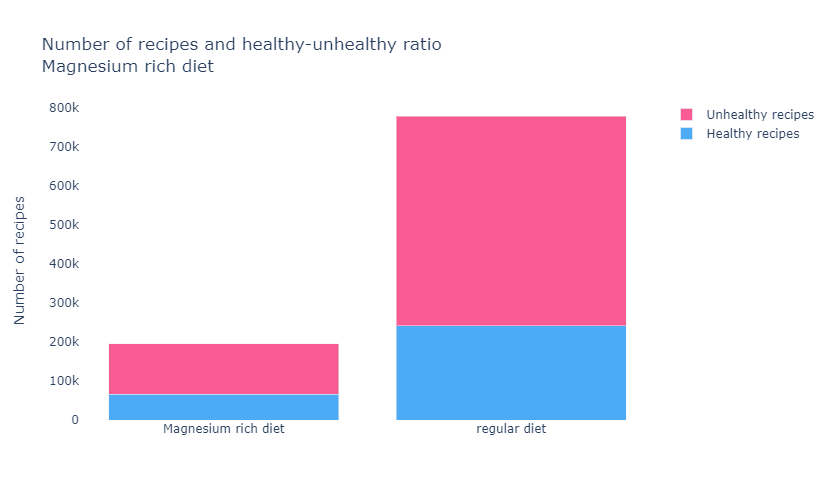

In [177]:
import plotly.graph_objects as go
diets=['Magnesium rich diet', 'regular diet']
numberOfHealthyMagnesiumRichRecipes = len(df_ingredients[(df_ingredients["MagnesiumRich"] == 1) & (df_ingredients["Unhealthy"] == 0)])
numberOfMagnesiumRichRecipes = len(df_ingredients[df_ingredients["MagnesiumRich"] == 1])

numberOfHealthyRecipes = len(df_ingredients[df_ingredients["Unhealthy"] == 0])
numberOfRecipes = len(df_ingredients)

_hover_healthy1 = "Magnesium rich:<br><br>"
_hover_healthy1 += "Healthy recipes: " + str(numberOfHealthyMagnesiumRichRecipes) + "<br>"
_hover_healthy1 += "Total recipes: " + str(numberOfMagnesiumRichRecipes) + "<br>"
_hover_healthy1 += "Percentage of healthy recipes: " + str(round(numberOfHealthyMagnesiumRichRecipes*100/numberOfMagnesiumRichRecipes, 2)) + "%"

_hover_healthy2 = "No diet:<br><br>"
_hover_healthy2 += "Healthy recipes: " + str(numberOfHealthyRecipes) + "<br>"
_hover_healthy2 += "Total recipes: " + str(numberOfRecipes) + "<br>"
_hover_healthy2 += "Percentage of unhealthy recipes: " + str(round(numberOfHealthyRecipes*100/numberOfRecipes, 2)) + "%"

_hover_unhealthy1 = "Magnesium rich:<br><br>"
_hover_unhealthy1 += "Unhealthy recipes: " + str(numberOfMagnesiumRichRecipes - numberOfHealthyMagnesiumRichRecipes) + "<br>"
_hover_unhealthy1 += "Total recipes: " + str(numberOfMagnesiumRichRecipes) + "<br>"
_hover_unhealthy1 += "Percentage of healthy recipes: " + str(round((numberOfMagnesiumRichRecipes - numberOfHealthyMagnesiumRichRecipes)*100/numberOfMagnesiumRichRecipes, 2)) + "%"

_hover_unhealthy2 = "No diet:<br><br>"
_hover_unhealthy2 += "Unhealthy recipes: " + str(numberOfHealthyRecipes) + "<br>"
_hover_unhealthy2 += "Total recipes: " + str(numberOfRecipes) + "<br>"
_hover_unhealthy2 += "Percentage of unhealthy recipes: " + str(round((numberOfRecipes - numberOfHealthyRecipes)*100/numberOfRecipes, 2)) + "%"

fig = go.Figure(data=[
    go.Bar(
        name='Healthy recipes',
        x=diets,
        y=[numberOfHealthyMagnesiumRichRecipes, numberOfHealthyRecipes],
        hovertext=[_hover_healthy1, _hover_healthy2],
        hoverinfo="text",
        marker_color= '#2196f3'
    ),
    go.Bar(
        name='Unhealthy recipes',
        x=diets,
        y=[numberOfMagnesiumRichRecipes - numberOfHealthyMagnesiumRichRecipes, numberOfRecipes - numberOfHealthyRecipes],
        hovertext=[_hover_unhealthy1, _hover_unhealthy2],
        hoverinfo="text",
        marker_color= '#f73378'
    )
])
fig.update_traces(opacity=0.8)
# Change the bar mode
fig.update_layout(
    title_text='Number of recipes and healthy-unhealthy ratio<br>Magnesium rich diet',
    barmode='stack',
    width=500,
    height=500,
    plot_bgcolor="white",
)
fig.update_yaxes(title_text='Number of recipes')

fig.show()

## Spicy food

In [179]:
df_spicy = df_ingredients[df_ingredients["Spicy"] == 1]
df_spicy.head()

id                                        ingredients  \
16  00010c7867  [pepper, chili, butter, tomatoes, onion, milk,...   
33  0001d6acb7  [pepper, butter, coarse sea salt, cilantro, wa...   
36  0002491373  [pepper, vegetable oil, cilantro, onion, garli...   
42  0002e15d76  [pepper, worcestershire sauce, water, hot dogs...   
48  00033f624d  [bacon, butter, cracked pepper, rock salt, egg...   

    LactoseFree  GlutenFree  Vegan  Vegetarian  IronRich  Omega3Rich  \
16            0           0      0           0         1           0   
33            0           0      0           1         0           0   
36            1           1      1           1         1           0   
42            1           1      0           1         0           0   
48            0           0      0           0         0           0   

    MagnesiumRich  Spicy  Unhealthy  length  
16              1      1          1      14  
33              0      1          1      18  
36              0      1          1      14  
42              0      1          1      15  
48              0      1          1       8

In [180]:
# Getting the not omega 3 rich ingredients
ingredients_not_spicy = df_common_ing[df_common_ing["Spicy"] == 0].index.tolist()
printMain("Ingredients not spciy: " + str(len(ingredients_not_spicy)))

Ingredients not spciy: 254


In [181]:
# Getting the omega3 rich ingredients
ingredients_spicy = df_common_ing[df_common_ing["Spicy"] == 1].index.tolist()
printMain("Ingredients spicy: " + str(len(ingredients_spicy)))

Ingredients spicy: 11


In [182]:
# First, we recalculate the dictionary of ingredients
initial_time = time.time()
dic_ingredients_not_spicy = {}
 
for row in df_spicy.itertuples():
    for ing in row[2]:
        if ing not in ingredient_list:
            continue
        if ing not in ingredients_spicy:
            if ing in dic_ingredients_not_spicy:
                dic_ingredients_not_spicy[ing] += 1
            else:
                dic_ingredients_not_spicy[ing] = 1

print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of different ingredients: " + str(len(dic_ingredients_not_spicy)))

(Time: 3.1 seconds)
Number of different ingredients: 254


In [183]:
len(df_ingredients)

779088

In [184]:
len(df_spicy)

171429

In [185]:
dic_ingredients_spicy_per = {}
ingredients_spicy_per = []
ingredients_spicy_per_general = []
keys_spicy = []

for key in ingredients_not_spicy:
    ingredients_spicy_per_general.append(dic_ingredients_per[key])
    keys_spicy.append(key)
    if key in dic_ingredients_not_spicy:
        ingredients_spicy_per.append((dic_ingredients_not_spicy[key]/len(df_spicy))*100)
        dic_ingredients_spicy_per[key] = (dic_ingredients_not_spicy[key]/len(df_spicy))*100
    else: 
        ingredients_spicy_per.append(0)
        dic_ingredients_spicy_per[key] = 0

In [186]:
dic_more_per_spicy = {}
dic_less_per_spicy = {}
dic_double_spicy = {}
dic_half_spicy = {}
mean_change_spicy = 0
absolute_change_spicy = 0
dic_changes_spicy = {}
mean_total = 0
initial_time = time.time()

for key in dic_ingredients_spicy_per:
    change = dic_ingredients_spicy_per[key] - dic_ingredients_per[key]
    dic_changes_spicy[key] = change
    mean_change_spicy += change
    absolute_change_spicy += abs(change)
    mean_total += dic_ingredients_per[key]
    if dic_ingredients_spicy_per[key] - 2 > dic_ingredients_per[key]:
        dic_more_per_spicy[key] = [dic_ingredients_per[key], dic_ingredients_spicy_per[key]]
    elif dic_ingredients_spicy_per[key] + 2 < dic_ingredients_per[key]:
        dic_less_per_spicy[key] = [dic_ingredients_per[key], dic_ingredients_spicy_per[key]]
        
    if dic_ingredients_spicy_per[key] > 2*dic_ingredients_per[key]:
        dic_double_spicy[key] = [dic_ingredients_per[key], dic_ingredients_spicy_per[key]]
    elif dic_ingredients_spicy_per[key]*2 < dic_ingredients_per[key]:
        dic_half_spicy[key] = [dic_ingredients_per[key], dic_ingredients_spicy_per[key]]

mean_change_spicy = mean_change_spicy/len(dic_ingredients_spicy_per)
absolute_change_spicy = absolute_change_spicy/len(dic_ingredients_spicy_per)
mean_total = mean_total/len(dic_ingredients_spicy_per)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")

printMain("Ingredients increasing more than 2%:")
print(dic_more_per_spicy)
print()
printMain("Ingredients decreasing more than 2%:")
print(dic_less_per_spicy)
print()
printMain("Ingredients multipling by 2 their percentage of appearances:")
print(dic_double_spicy)
print()
printMain("Ingredients dividing by 2 their percentage of appearances:")
print(dic_half_spicy)

(Time: 0.0 seconds)
Ingredients increasing more than 2%:
{'salt': [52.792239130881235, 64.08483978790052], 'pepper': [31.675754215184938, 45.7915521877862], 'garlic': [26.720986589448177, 46.32996750841456], 'onion': [25.87653769535662, 43.86189034527413], 'olive oil': [19.051121311071405, 25.946018468287164], 'cheese': [17.739074404945267, 20.042116561375263], 'lemon': [12.936279341999876, 15.332295002595828], 'tomatoes': [11.635142628303862, 19.982033378249888], 'vegetable oil': [11.030589612469965, 15.16137876321976], 'chicken': [10.426164951841127, 16.101709745725636], 'vinegar': [9.335659129649025, 16.724124856354525], 'parsley': [8.566041320107614, 11.653804198822836], 'bell pepper': [7.89384511120695, 14.222797776338892], 'beef': [5.990979196188364, 9.356059943183476], 'ginger': [5.686007228965149, 10.660390015691627], 'celery': [5.427628201178814, 8.548145296303426], 'chicken broth': [5.421852216951102, 7.520314532547003], 'cumin': [4.371264863532746, 13.832548751961454], 'lime

In [187]:
printMain("Mean change: " + str(mean_change_spicy))
printMain("Mean change in absolute value: " + str(absolute_change_spicy))
printMain("Mean total: " + str(mean_total))
printMain("Percentual mean change: " + str(absolute_change_spicy*100/mean_total))

Mean change: 0.42304679295079667
Mean change in absolute value: 1.329057431809012
Mean total: 2.9083753246881354
Percentual mean change: 45.69759000934746


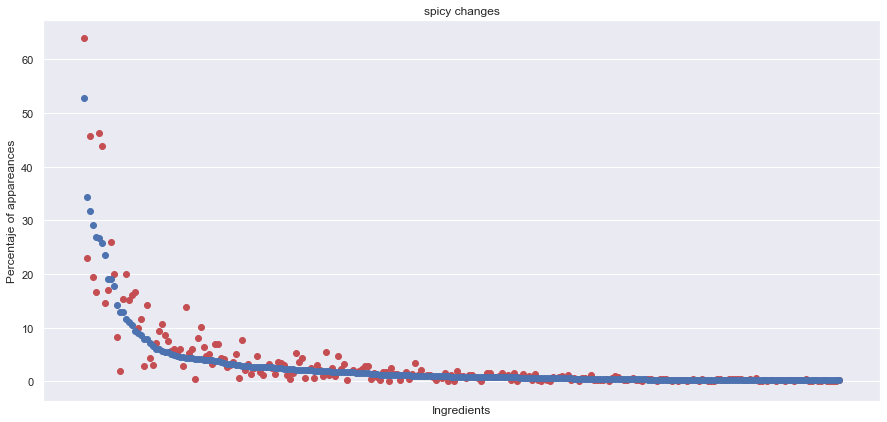

In [188]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.scatter(list(range(len(ingredients_spicy_per))), ingredients_spicy_per, color='r')
ax.scatter(list(range(len(ingredients_spicy_per))), ingredients_spicy_per_general, color='b')
ax.set_xlabel('Ingredients')
ax.set_ylabel('Percentaje of appareances')
ax.set_title('spicy changes')
plt.xticks([])
plt.show()

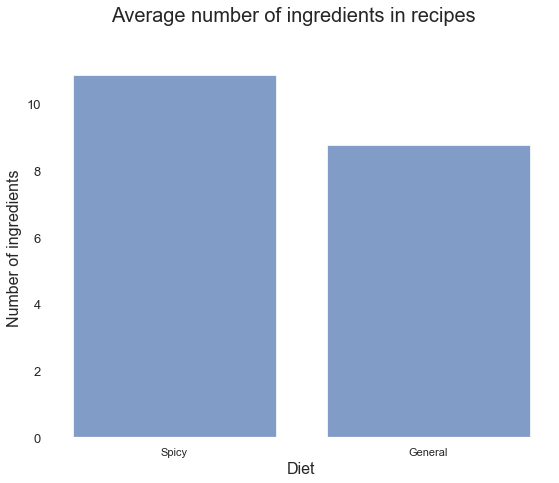

In [189]:
mean_spicy = df_ingredients[df_ingredients["Spicy"] == 1]["length"].mean()
mean_general = df_ingredients["length"].mean()
_data = [mean_spicy, mean_general]
_keys = ["Spicy", "General"]
fig, ax = plt.subplots(figsize=(9, 7))
plt.bar(np.arange(2), _data,
       align='center',
       alpha=0.7,
       ecolor='black',
       capsize=10, 
       tick_label=_keys) 
fig.suptitle('Average number of ingredients in recipes', fontsize=20)
plt.ylabel('Number of ingredients', fontsize=16)
plt.xlabel('Diet', fontsize=16)
ax.set_facecolor('xkcd:white')
#ax.set_facecolor((1.0, 0.47, 0.42))
plt.xticks(fontsize=11)
plt.yticks(fontsize=13)
plt.show()


(Time: 0.14 seconds)


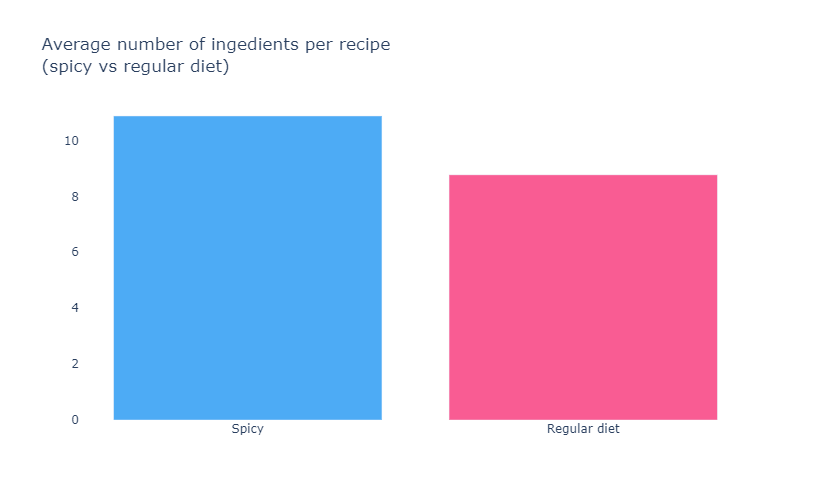

In [190]:
initial_time = time.time()
_keys_diets = ["Spicy", "Regular diet"]
_hovers = []

_hovers.append("Spicy diet has " + str(round(mean_spicy, 2)) + " ingredients in average per diet.")
_hovers.append("Regular diet has " + str(round(mean_general, 2)) + " ingredients in average per diet.")

_hovers.append("Total number of recipes: " + str(total))
fig = go.Figure(data=[go.Bar(x=_keys_diets,
                             y=_data,
                             hovertext=_hovers,
                             hoverinfo="text",
                             marker_color=["#2196f3", "#f73378"]
                            )])
# Customize aspect
fig.update_traces(#marker_color='#2196f3', marker_line_color='#1769aa', marker_line_width=1.3,
                  opacity=0.8)
fig.update_layout(
    title_text='Average number of ingedients per recipe <br>(spicy vs regular diet)',
    width=500,
    height=500,
    plot_bgcolor='white'
)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
fig.show()

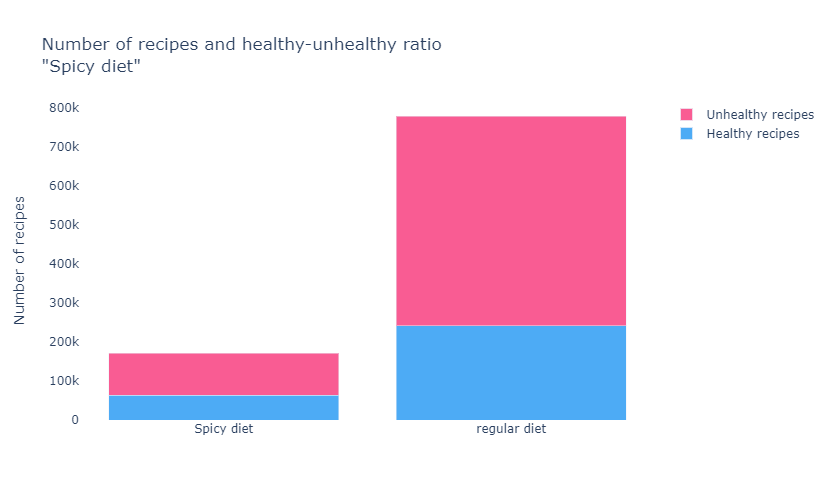

In [192]:
import plotly.graph_objects as go
diets=['Spicy diet', 'regular diet']
numberOfHealthySpicyRecipes = len(df_ingredients[(df_ingredients["Spicy"] == 1) & (df_ingredients["Unhealthy"] == 0)])
numberOfSpicyRecipes = len(df_ingredients[df_ingredients["Spicy"] == 1])

numberOfHealthyRecipes = len(df_ingredients[df_ingredients["Unhealthy"] == 0])
numberOfRecipes = len(df_ingredients)

_hover_healthy1 = "Spicy:<br><br>"
_hover_healthy1 += "Healthy recipes: " + str(numberOfHealthySpicyRecipes) + "<br>"
_hover_healthy1 += "Total recipes: " + str(numberOfSpicyRecipes) + "<br>"
_hover_healthy1 += "Percentage of healthy recipes: " + str(round(numberOfHealthySpicyRecipes*100/numberOfSpicyRecipes, 2)) + "%"

_hover_healthy2 = "No diet:<br><br>"
_hover_healthy2 += "Healthy recipes: " + str(numberOfHealthyRecipes) + "<br>"
_hover_healthy2 += "Total recipes: " + str(numberOfRecipes) + "<br>"
_hover_healthy2 += "Percentage of unhealthy recipes: " + str(round(numberOfHealthyRecipes*100/numberOfRecipes, 2)) + "%"

_hover_unhealthy1 = "Spicy:<br><br>"
_hover_unhealthy1 += "Unhealthy recipes: " + str(numberOfSpicyRecipes - numberOfHealthySpicyRecipes) + "<br>"
_hover_unhealthy1 += "Total recipes: " + str(numberOfSpicyRecipes) + "<br>"
_hover_unhealthy1 += "Percentage of healthy recipes: " + str(round((numberOfSpicyRecipes - numberOfHealthySpicyRecipes)*100/numberOfSpicyRecipes, 2)) + "%"

_hover_unhealthy2 = "No diet:<br><br>"
_hover_unhealthy2 += "Unhealthy recipes: " + str(numberOfHealthyRecipes) + "<br>"
_hover_unhealthy2 += "Total recipes: " + str(numberOfRecipes) + "<br>"
_hover_unhealthy2 += "Percentage of unhealthy recipes: " + str(round((numberOfRecipes - numberOfHealthyRecipes)*100/numberOfRecipes, 2)) + "%"

fig = go.Figure(data=[
    go.Bar(
        name='Healthy recipes',
        x=diets,
        y=[numberOfHealthySpicyRecipes, numberOfHealthyRecipes],
        hovertext=[_hover_healthy1, _hover_healthy2],
        hoverinfo="text",
        marker_color= '#2196f3',
    ),
    go.Bar(
        name='Unhealthy recipes',
        x=diets,
        y=[numberOfSpicyRecipes - numberOfHealthySpicyRecipes, numberOfRecipes - numberOfHealthyRecipes],
        hovertext=[_hover_unhealthy1, _hover_unhealthy2],
        hoverinfo="text",
        marker_color= '#f73378',
    )
])

fig.update_traces(opacity=0.8)
# Change the bar mode
fig.update_layout(
    title_text='Number of recipes and healthy-unhealthy ratio<br>"Spicy diet"',
    barmode='stack',
    width=500,
    height=500,
    plot_bgcolor="white",
)
fig.update_yaxes(title_text='Number of recipes')
fig.show()

## 4) Recipes Classification

In this last chapter, we are going to try to classificate the recepies based on their preparation information, which we don't have used it yet. Our main goal is to try to assess the difficulty of preparing each recipe. Finally, we are going to check which variation it has between the different diets or conditions we have studied.
First we are going to try to do it with a famous unsupervised machine learning technique.

### Clustering

#### TF IDF Matrix

We are going to use the preparation steps as the input to a machine learning algorithm using a Bag of Words, but each row is a sentences instead of a doc. Finally, using the TF IDF Vectorizer we convert the BOW to a TF IDF matrix which is the input for the machine learning algorithm.

In [1]:
import collections
import nltk
import warnings; warnings.simplefilter('ignore')
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from pprint import pprint
import numpy as np 
import matplotlib.pyplot as plt

First, we need to have a general idea of a good number of clusters to use with the chosen algorithm, KMeans. To do so, we use the Elbow Method:

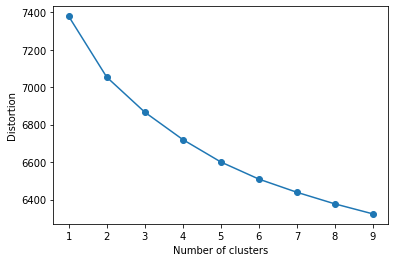

In [2]:
# We tokenize and stem with Porter stemmer the recipes preparation sentences, 
def word_tokenizer(text):
        tokens = word_tokenize(text)
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(t) for t in tokens if t not in stopwords.words('english')]
        return tokens

# This function does the clustering and the treatment of the text
def cluster_sentences(sentences):
    tfidf_vectorizer = TfidfVectorizer(tokenizer=word_tokenizer,
                                    stop_words=stopwords.words('english'),
                                    max_df=0.9,
                                    min_df=0.1,
                                    lowercase=True)
    tfidf_matrix = tfidf_vectorizer.fit_transform(sentences)

    distortions = []
    for i in range(1, 10):
        kmeans = KMeans(n_clusters=i, init='random',n_init=10, max_iter=200,tol=1e-04, random_state=0)
        kmeans.fit(tfidf_matrix)
        distortions.append(kmeans.inertia_)
    plt.plot(range(1, 10), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show()


from itertools import islice
# This file contains the instructions of each recipe, one per line. The different steps of one recipe are separated using "\t"
with open('tokenized_instructions_test.txt', 'r') as infile:
    lines_gen = islice(infile, 10000)
    lst = list(lines_gen)
    
sentences = lst
clusters = cluster_sentences(sentences)


Now that we have an idea of the number of clusters that would be appropiate we do the clustering with 5 clusters as the elbow seems to appear close to that number.

In [3]:
def cluster_sentences(sentences, nb_of_clusters=5):
        tfidf_vectorizer = TfidfVectorizer(tokenizer=word_tokenizer,
                                        stop_words=stopwords.words('english'),
                                        max_df=0.9,
                                        min_df=0.1,
                                        lowercase=True)
        tfidf_matrix = tfidf_vectorizer.fit_transform(sentences)
        kmeans = KMeans(n_clusters=nb_of_clusters)
        kmeans.fit(tfidf_matrix)
        clusters = collections.defaultdict(list)
        for i, label in enumerate(kmeans.labels_):
                clusters[label].append(i)
        return dict(clusters)

nclusters= 5
clusters = cluster_sentences(sentences, nclusters)

We are going to print two recipes per cluster:

In [4]:
for cluster in range(nclusters):
    print ("Cluster ",cluster,":")
    for i,sentence in enumerate(clusters[cluster]):
        print ("\tRecipe ",i,": ",sentences[sentence])
        if i == 1:
            break

Cluster  0 :
	Recipe  0 :  If making your own sauce ,  prepare it the day before you are planning to make the meatloaf . 	In a large bowl ,  combine the first nine ingredients  ( everything but the lamb/beef and tzatziki sauce )  . 	Crumble lamb or beef over the mixture and combine well . 	Shape into a loaf and place in a greased 11x7 "  baking dish . 	Bake uncovered at 350 for 55-60 minutes or until no pink remains and a thermostat reads 160 . 	Let stand for 15 minutes before slicing . 	Drizzle with tzatziki sauce . 	

	Recipe  1 :  Mix the mashed_potatoes together with the flour . 	DON'T knead ,  because the dumplings will  " sink "  . 	Shape the dough into small balls . 	Place in a kettle of boiling salted water . 	Once they rise to the surface ,  let them cook for 10 minutes . 	Drain and sprinkle with fresh_parsley . 	Serve as side dish . 	

Cluster  1 :
	Recipe  0 :  Heat oven to 350 degrees F . 	Cook cauliflower in boiling water in large saucepan 4 min . 	 ;  drain well . 	Melt 2

After checking the output of the algorithm, we concluded that the clustering was not being really relevant for us, and we thought that it was using other metrics to do it that weren´t really relevant for us, for example putting together the recepies with preheat the oven, or containing the word chicken, or that used similar verbs.

#### Word2Vec

We thought that one problem could dwell in that by using the TF-IDF method we were loosing important relation with other words in the sentences, or in other words, part of the context.
This is why we tried to approach the problem with Word embedding, specifically Word2Vec.

In [5]:
from gensim.models import Word2Vec
from nltk.cluster import KMeansClusterer
from sklearn import cluster
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [6]:
# Vectorizer of the sentences
def sent_vectorizer(sent, model):
    sent_vec =[]
    numw = 0
    for w in sent:
        try:
            if numw == 0:
                sent_vec = model[w]
            else:
                sent_vec = np.add(sent_vec, model[w])
            numw+=1
        except:
            pass
     
    return np.asarray(sent_vec) / numw

# Model with Word2Vec
model = Word2Vec(sentences, min_count=1)
X=[]
for sentence in sentences:
    X.append(sent_vectorizer(sentence, model))
NUM_CLUSTERS=5
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS)
kmeans.fit(X) 
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

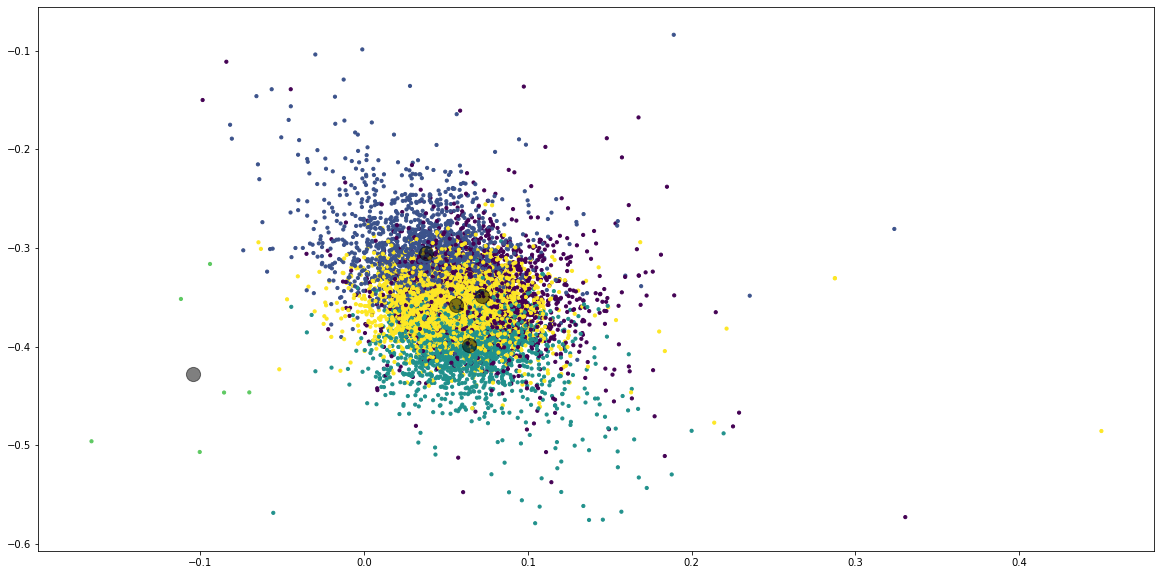

In [7]:
# Plot the clustering with KMeans
y_kmeans = kmeans.predict(X)
X = np.array(X)
plt.figure(figsize=(20,10))
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=10, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=200, alpha=0.5);

Analyzing the output we weren't obtaining realy meaningful results. This is why our next approach was filtering the preparation steps using SpaCy only taking the Verbs and Nouns, to try to reduce the complexity of the sentences, so that the algorthim would base its clustering in the features we were most interested. 

In [8]:
import spacy
import json
import pandas as pd
with open('layer1.json', 'r') as datafile:
    data = json.load(datafile)
    rawData = pd.DataFrame(data)

df_cleaned_No_Explanations = pd.read_csv('df_ingredients.csv', nrows=10000)
# df_cleaned_No_Explanations = pd.read_csv('df_ingredients.csv')
df_final = df_cleaned_No_Explanations.merge(rawData, on='id')

In [9]:
# As the preparation steps  are in JSON arrays we format it to one string
def convert_to_array(preparations_json):
    to_return = []
    for preparation in preparations_json:
        step = preparation['text'].lower()
        to_return.append(step)
    return " ".join(str(x) for x in to_return)

In [10]:
# Apply the abovementioned function
df_final['instructions'] = df_final['instructions'].apply(convert_to_array)

In [11]:
# Load nlp in english language
nlp = spacy.load('en')

In [12]:
# Function that only keeps the nouns and verbs
def verbAndNounsExc(prep):
    doc = nlp(prep)
    verbs_nouns = ''
    for token in doc:
        if token.pos_ == 'NOUN' or token.pos_ == 'VERB':
            pos_tagged = token.text
            verbs_nouns+= ' '+ pos_tagged
    return verbs_nouns

In [13]:
# Apply the abovementioned function
df_final['preptsVandN'] = df_final['instructions'].apply(verbAndNounsExc)

In [14]:
model = Word2Vec(df_final['preptsVandN'], min_count=1)
X=[]
for prep in df_final['preptsVandN']:
    X.append(sent_vectorizer(prep, model))
model[model.wv.vocab]
NUM_CLUSTERS=5
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

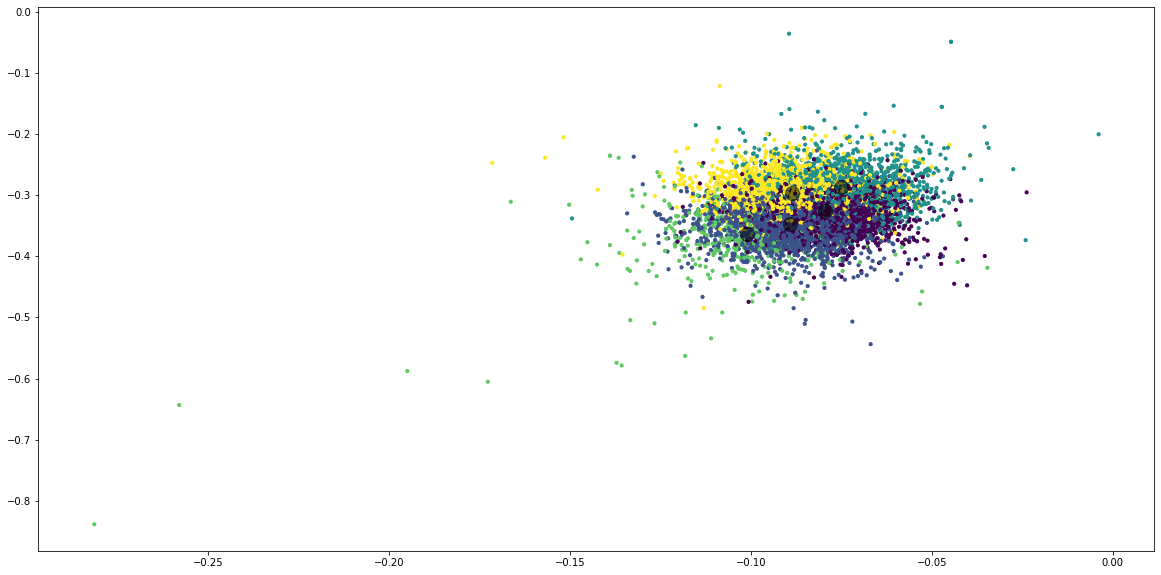

In [15]:
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
y_kmeans = kmeans.predict(X)
X = np.array(X)
plt.figure(figsize=(20,10))
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=10, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=200, alpha=0.5);

Finally, as this results were interesting but not meaninful to what we where trying to obtain, measure the complexity of the different recipes we opted for using SpaCy transformations to try to infer the complexity by ourselves

### Language processing

In [16]:
import collections
# This time we choose the Snowball Stemmer wich is better than the Porter one
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer(language='english')
# df_final = df_cleaned_No_Explanations.merge(rawData, on='id')
# df_final['instructions'] = df_final['instructions'].apply(convert_to_array)

 We use the Stemmer because we are not interested in the different forms of the verbs, only in the different verbs. Also, when not used, the number of unique verbs was almost double of the one we obtained using it, which made it harder to rank the verbs manually.

In [17]:
# Function that only keep the verbs
def onlyVerb(prep):
    doc = nlp(prep)
    verbs = []
    for token in doc:
        if token.pos_ == 'VERB':
            pos_tagged = stemmer.stem(token.text)
            verbs.append(pos_tagged)
    x = np.array(verbs)
    return np.unique(x)

listVerbs = []
def uniqueRetrieval(verbs):
    listVerbs.extend(verbs)

In [18]:
# Only save the verbs which are also stemmed
df_final['preptsVandN'] = df_final['instructions'].apply(onlyVerb)
df_final['preptsVandN'].apply(uniqueRetrieval)

0       None
1       None
2       None
3       None
4       None
        ... 
9995    None
9996    None
9997    None
9998    None
9999    None
Name: preptsVandN, Length: 10000, dtype: object

In [20]:
counter=collections.Counter(listVerbs)
listVerbs = set(listVerbs)
print("Number of unique verbs:",len(listVerbs))

Number of unique verbs: 2260


As we can see there are too many verbs to rank them individually. Our guess, is that there are verbs that are used more than others, let's see if it is the case.

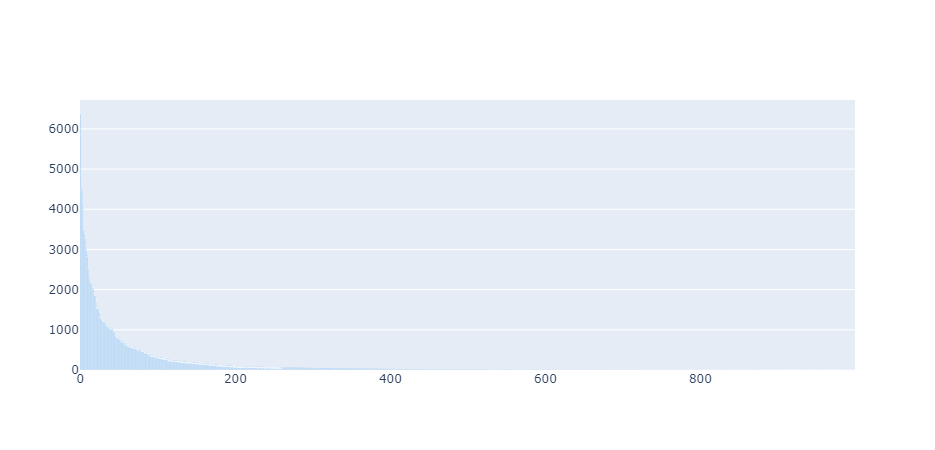

In [38]:
import plotly.graph_objects as go
y_pos = np.arange(len(x))
x = sorted(list(counter.values()),reverse=True)
# We only plot the first 1000 verbs to make the visualization more clear
fig = go.Figure(data=[go.Bar(
            x=y_pos[:1000], y=x[:1000],
            text=y_pos,
            textposition='auto',
            marker_color="#2196f3",
        )])
fig.show()

We can clearly see that there are some verbs used much more than others, following the Zipf’s law. Therefore by only ranking them and not the rest we think that is not going to affect too much the overall analysis.

In [35]:
print("Importance of the first 120 verbs:",sum(x[:120])/sum(x)*100,"%")

Importance of the first 120 verbs: 80.78180037894683 %


We can see that by only specifying 120 verbs we can cover more than 80 % of the verbs frequency.

In [39]:
listAllVerbs = sorted(counter, key=counter.get, reverse=True)
print(listAllVerbs[:120])

['add', 'stir', 'serv', 'cook', 'is', 'mix', 'combin', 'remov', 'cover', 'pour', 'preheat', 'remain', 'bake', 'use', 'are', 'cut', 'set', 'let', 'sprinkl', 'bring', 'make', 'place', 'melt', 'turn', 'drain', 'be', 'beat', 'simmer', 'spread', 'put', 'reduc', 'cool', 'can', 'heat', 'boil', 'refriger', 'brown', 'toss', 'will', 'do', 'transfer', 'coat', 'tast', 'blend', 'chop', 'saut', 'keep', 'roll', 'chill', 'desir', 'have', 'spoon', 'fill', 'fold', 'oven', 'done', 'allow', 'stand', 'continu', 'come', 'prepar', 'has', 'whisk', 'thicken', 'slice', 'leav', 'return', 'should', 'need', 'fri', 'enjoy', 'form', 'greas', 'top', 'line', 'uncov', 'garnish', 'ad', 'start', 'begin', 'soften', 'take', 'salt', 'press', 'insert', 'may', 'divid', 'discard', 'dissolv', 'spray', 'arrang', 'get', 'scrape', 'dri', 'like', 'repeat', 'accord', 'reserv', 'brush', 'mash', 'shake', 'whip', 'flour', 'break', 'sit', 'drop', 'run', 'season', 'sift', 'strain', 'adjust', 'want', "'s", 'freez', 'work', 'soak', 'roast'

We have assigned a importance level to each verb, to try to asses the difficulty of carrying out each one. By difficulty we mean either the real difficulty of doing the recipe, for example, because specialized tools have to be used, or because it takes more than time than other, for example the verb "freeze" means that in order to complete the recipe more time has to be spent.
The importancelevel ranges from 0 to 3. The verbs that are 0 is because they are auxiliary verbs and therefore they are not usually relevant to measure the steps to carry out the recipe. "serv" is also a 0 because it is commonly used when the recipe is done. 

In [40]:
listVerbs = {
    'add': 1, 'stir': 2, 'serv': 0, 'cook': 2, 'is' : 0, 'combin' : 1, 'mix' : 2, 'remov' : 1, 'cover' : 1, 'preheat': 2, 'pour': 1, 'bake': 3, 'remain': 1 , 'are': 0 , 'use': 1, 'cut' :1, 'sprinkl': 1, 'let': 0, 'bring': 1, 'set': 1, 'make': 2, 'melt': 2, 'cool': 1, 'turn': 2, 'be': 0, 'place': 1, 'drain': 2, 'brown': 2, 'simmer': 3, 'put': 1, 'reduc': 1, 'spread': 2, 'beat': 2, 'can': 0, 'transfer': 1, 'will': 0, 'heat': 1, 'do': 0, 'boil': 2, 'toss': 1, 'refriger': 3, 'oven' :0, 'chop': 1, 'saut': 2, 'blend': 2, 'fill': 1, 'coat': 2, 'roll': 3, 'spoon': 1, 'allow': 0, 'have': 0, 'stand': 2, 'come': 0, 'chill': 2, 'tast': 1, 'has': 0, 'fold': 2, 'thicken': 2, 'desir': 0, 'done': 0, 'ad': 1, 'continu': 1, 'greas': 1, 'prepar': 1, 'fri': 2, 'should': 0, 'whisk': 2, 'return': 1, 'need': 0, 'enjoy': 0, 'leav': 1, 'keep': 1, 'uncov': 1, 'garnish': 1, 'start': 0, 'slice': 1, 'begin': 0, 'form': 1, 'insert': 1, 'take': 1, 'line': 1 , 'dri': 2, 'salt': 1, 'top': 1, 'may': 0, 'soften': 2, 'press': 2, 'get': 1, 'spray': 2, 'scrape': 1, 'discard': 1, 'arrang': 1, 'repeat': 1, 'divid': 1, 'shake': 1, 'brush': 1, 'dissolv': 1, 'run': 1, 'sift': 2, 'depend': 0, 'season': 1, 'like': 0, 'freez': 3, 'reserv': 1, 'break': 1, 'whip': 2, 'toast': 1, 'sit': 2, 'strain': 2, 'want': 0, 'adjust': 1, 'flip': 1, 'flatten': 2, 'flour': 1, 'seal': 1, 'rub': 1, 'rise': 1, 'mash': 2, 'lay': 1, 'drop': 1
}
def assignWeightToRecipe (arrayRecipeVerbs):
    complexity = 0
    for verb in arrayRecipeVerbs:
        if verb in listVerbs:
            complexityOfVerb = listVerbs[verb]
            complexity += complexityOfVerb
        
    return complexity

In [41]:
df_final['Complexity'] = df_final['preptsVandN'].apply(assignWeightToRecipe)

In [42]:
complexityMean = df_final['Complexity'].mean()
print("Mean complexity",complexityMean)

Mean complexity 14.8602


The mean of the "complexity" of the recipies is almost 15. The most complex one being 51. Manually looking at the preparations of the edge cases we have realize that the measure seems to be correlated with our percieved complexity/time consumption required to prepare the recipe.

In [43]:
import plotly.express as px

def lengthIng(ingredients):
    return len(ingredients.split(","))

df_final['NIngredients'] = df_final['ingredients_x'].apply(lengthIng)

In [44]:
df_final['Spicy'] = df_final['Spicy'].astype(str)
df_final['Vegan'] = df_final['Vegan'].astype(str)
df_final['Vegetarian'] = df_final['Vegetarian'].astype(str)
df_final['LactoseFree'] = df_final['LactoseFree'].astype(str)
df_final['IronRich'] = df_final['IronRich'].astype(str)
df_final['Omega3Rich'] = df_final['Omega3Rich'].astype(str)
df_final['MagnesiumRich'] = df_final['MagnesiumRich'].astype(str)
df_final['GlutenFree'] = df_final['GlutenFree'].astype(str

In [49]:
x = range(len(df_final))

# This function calculates the means of the different diets/conditions
def getMeans(dietName):
    return df_final[df_final[dietName] == '1']['Complexity'].mean()

# This function plots the different scatter plots of the diets/conditions
def plotterScatters(dietName):
    fig = px.scatter(df_final, x=x, y="Complexity", color=dietName, size='NIngredients', hover_data=[dietName], color_discrete_map={'1':'#f73378','0':'#2196f3'}, labels={'NIngredients':'Number of Ingredients'})
    fig.add_shape(
        go.layout.Shape(
            type="line",
            x0=-500,
            y0=getMeans(dietName),
            x1=10500,
            y1=getMeans(dietName), 
            line=dict(
                color="#f73378",
                width=4,
#                 dash="dashdot",
        ),
    ))
    fig.add_shape(
        go.layout.Shape(
            type="line",
            x0=-500,
            y0=complexityMean,
            x1=10500,
            y1=complexityMean, 
            line=dict(
                color="#2196f3",
                width=4,
#                 dash="dashdot",
            ),
        ))
    
    fig.update_layout({'legend_orientation':'h','xaxis_title':'Recipes',})
    return fig

Now we can plot all the different diets and conditions to compare their complexity.

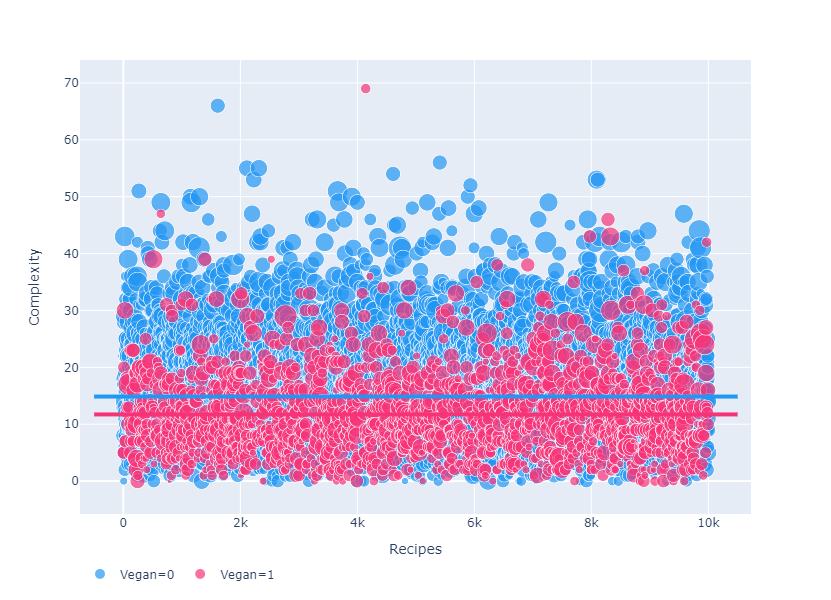

In [50]:
import plotly.offline as offline  
veganPlot = plotterScatters('Vegan')
spicyPlot = plotterScatters('Spicy')
vegetarianPlot = plotterScatters('Vegetarian')
lacFreePlot = plotterScatters('LactoseFree')
ironRichPlot = plotterScatters('IronRich')
omegaRichPlot = plotterScatters('Omega3Rich')
MagRichPlot = plotterScatters('MagnesiumRich')
GlutenFreePlot = plotterScatters('GlutenFree')
offline.plot(veganPlot, filename="VeganPlot.html", auto_open=False)
offline.plot(spicyPlot, filename="spicyPlot.html", auto_open=False)
offline.plot(vegetarianPlot, filename="vegetarianPlot.html", auto_open=False)
offline.plot(lacFreePlot, filename="lacFreePlot.html", auto_open=False)
offline.plot(ironRichPlot, filename="ironRichPlot.html", auto_open=False)
offline.plot(omegaRichPlot, filename="omegaRichPlot.html", auto_open=False)
offline.plot(MagRichPlot, filename="MagRichPlot.html", auto_open=False)
offline.plot(GlutenFreePlot, filename="gluFreePlot.html", auto_open=False)
veganPlot.show()

We only print the vegan plot, because is the one that has the greatest difference in complexity, but in the datastory all the plots can be consulted. As we can see in average vegan recipes are less "complex" to make than the rest of recipes. This is a really interesting result, also due to desserts recipies usually not being healthy but being quite complex, but also and more importantly indicating that vegan recipes are usually easier to make, therefore making it a good choice for people. This is also the case in vegetarian recipes, creating a bright future for this recipes, in the effort the world is doing right now trying to reduce meat consumption to combat climate change.

# Conclusions

In this notebook we have carried out an intensive analysis of the current food consumption and tried to give more tools for the people to have as much information as possible to make their food choices.
First, we have analyzed the food consumption in Europe, to analyze the current status of the food consumption. Doing this task, we have realized two things: 
- There is a lot of interest in and resources for analyzing what people consume, at least in Europe.
- People do not consume the recommended quantities of food, which can cause health related issues. This connects with the second part of our analysis.
Second, we have analyzed the different connections between the ingredients, analyzing the relationship between the different ingredients. Doing so, we have discovered:
- The different hidden cross-dependencies which can be of importance when being on a diet or having a certain health condition.
- With which type of diet or health condition it is easier to be healthy.
- Which diets have more time-consuming or complex recipes.

We hope that by making the tool available in the web page of this project, we can help people to make better food decisions, or at least to show them an interesting reality.